1.) refit - done
2.) error - done
3.) construct amplitude weighted time for each event using the primary cluster and these offsets
4.) plot bbtime vs new HCal time
5.) hodoscope implementation

In [1]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [2]:
pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
dxmin=-2
dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -2
dxmax: 1
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [3]:
import ROOT as r


def list_branches(rootfile_path, tree_name="Tout"):
    # Open the ROOT file
    root_file = r.TFile.Open(rootfile_path)
    
    # Check if the file was successfully opened
    if not root_file or root_file.IsZombie():
        print(f"Error: Could not open ROOT file '{rootfile_path}'.")
        return
    
    # Access the TTree
    tree = root_file.Get(tree_name)
    
    # Check if the tree exists
    if not tree:
        print(f"Error: Tree '{tree_name}' not found in file '{rootfile_path}'.")
        root_file.Close()
        return
    
    # Get the list of branches
    branch_list = tree.GetListOfBranches()
    
    # Print all branch names
    print(f"Branches in tree '{tree_name}':")
    for branch in branch_list:
        print(branch.GetName())
    
    # Close the ROOT file
    root_file.Close()

# Example usage
rootfile_path = "../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
list_branches(rootfile_path)


Branches in tree 'Tout':
runnum
WCut
pCut
nCut
fiduCut
coinCut
ebeam
nu
Q2
W2
dpel
ephi
etheta
pcentral
vz
vx
vy
xtgt
ytgt
thtgt
phtgt
thetabend
xfp
yfp
thfp
phfp
trP
trPx
trPy
trPz
ePS
xPS
eSH
xSH
ySH
eHCAL
xHCAL
yHCAL
xHCAL_exp
yHCAL_exp
dx
dy
ngrinch_hits
xGRINCH
yGRINCH
coin_time
hcal_time
bbcal_time
BPMAx
BPMAy
Rasterx
Rastery
Raster2x
Raster2y
helicity
IHWP
pblkid
tdc
atime
nblk
mag
run
tar
cblkid
cblkatime
cblktime
cblke
nclus
cid
cx
cy
catime
hodoTimes
hodoIDs
hodoTOT
nbars


Error in <TList::Clear>: A list is accessing an object (0xa7683c0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x66708f0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x6670d20) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa888b80) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa888ef0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa889260) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa889790) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa889b50) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa88a4b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa88a8a0) alread

In [32]:

import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend

pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
dxmin=-2
dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')


def Load_Hodo(config,chunk_size=100000):
    rootfile = f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
    #rootfile = f"../outfiles/oldhcal.root"
    rootfile2=f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_p_model1.root"
    C = r.TChain("Tout")
    C.Add(rootfile)
    C.SetBranchStatus("*", 0)
   
    
    #HCAL VARS_____________________________________
    C.SetBranchStatus("cx", 1)
    C.SetBranchStatus("cy", 1)
    C.SetBranchStatus("cblktime",1)
    C.SetBranchStatus("cblkatime",1)
    C.SetBranchStatus("cblkid",1)
    C.SetBranchStatus("cblke",1)
    C.SetBranchStatus("tdc",1)
    C.SetBranchStatus("atime",1)
    C.SetBranchStatus("bbcal_time",1)
    C.SetBranchStatus("pblkid",1)
    C.SetBranchStatus("nclus",1)
    C.SetBranchStatus("nblk",1)
    C.SetBranchStatus("hodoTimes",1)
    C.SetBranchStatus("hodoIDs",1)
    C.SetBranchStatus("nbars",1)
    C.SetBranchStatus("hodoTOT",1)
    bbtime=array.array('d',[0])
    tdc=array.array('d',[0])
    atime=array.array('d',[0])
    pblkid=array.array('d',[0])
    cx = array.array('d', [0]*10) 
    cy = array.array('d', [0]*10) 
    cblktime=array.array('d',[0]*25)
    cblkatime=array.array('d',[0]*25)
    cblkid=array.array('d',[0]*25)
    cblke=array.array('d',[0]*25)
    nclus=array.array('d',[0])
    nblk=array.array('i',[0])
    hodoIDs=array.array('d',[0]*6)
    hodoTimes=array.array('d',[0]*6)
    hodoTOT=array.array('d',[0]*6)
    nbars=array.array('i',[0])
    
    C.SetBranchAddress("cx", cx)
    C.SetBranchAddress("cy", cy)
    C.SetBranchAddress("cblktime",cblktime)
    C.SetBranchAddress("cblkatime",cblkatime)
    C.SetBranchAddress("cblkid",cblkid)
    C.SetBranchAddress("cblke",cblke)
    C.SetBranchAddress("tdc",tdc)
    C.SetBranchAddress("atime",atime)
    C.SetBranchAddress("pblkid",pblkid)
    C.SetBranchAddress("bbcal_time",bbtime)
    C.SetBranchAddress("nclus",nclus)
    C.SetBranchAddress("nblk",nblk)
    C.SetBranchAddress("hodoIDs",hodoIDs)
    C.SetBranchAddress("hodoTimes",hodoTimes)
    C.SetBranchAddress("nbars",nbars)
    C.SetBranchAddress("hodoTOT",hodoTOT)
    #_____________________________________
    
    
    #CUT VARS_____________________________________
    C.SetBranchStatus("W2",1)
    C.SetBranchStatus("dx",1)
    C.SetBranchStatus("dy",1)
    
    W2=array.array('d',[0])
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    
    C.SetBranchAddress("W2",W2)
    C.SetBranchAddress("dx",dx)
    C.SetBranchAddress("dy",dy)
    
    #_____________________________________
    
    cx_array=[]
    cy_array=[]
    cblktime_array=[]
    cblkatime_array=[]
    cblkid_array=[]
    cblke_array=[]
    tdc_array=[]
    bbtime_array=[]
    atime_array=[]
    pblkid_array=[]
    target=[]
    nclus_array=[]
    nblk_array=[]
    hodoID_array=[]
    hodoTime_array=[]
    nbars_array=[]
    tot_array=[]
    
    #tester=[]
    C.GetEntry(0)
    Entries=C.GetEntries()
    passedcut=0
    #Entries=2000000
    chunkValue=2000000
    totalIterations=Entries//chunkValue
    for j in range(0,totalIterations):
        
        
        print(f"Beginning Chunk {j} out of {totalIterations}")
        hodoID_array=[]
        hodoTime_array=[]
        nbars_array=[]
        for i in range(j*chunkValue,(j+1)*chunkValue):

            C.GetEntry(i)
            #tester.append(list(cblkatime))
            #print(tester,'\n')  
            #cut----------------
            
            wcut=W2min<W2[0]<W2max
            dxcut=dxmin<dx[0]<dxmax
            dycut=dymin<dy[0]<dymax
            cut=nbars[0]>1
            
            #trigbits cut
            #nbars < 3 cut
            #make correct bar primary 
            #cut = nblk[0]>1
            
            #-------------------
            EnergyOfCluster=np.sum(np.array(cblke[:nblk[0]]))
            #cut=EnergyOfCluster>.1
            if cut:
                passedcut+=1

                hodoTime_array.append(list(hodoTimes))
                hodoID_array.append(list(hodoIDs))
                tot_array.append(list(hodoTOT))
                nbars_array.append(nbars[0])

                






       # Print progress at every 'chunk_size' interval
         #COOLPROGRESSTRACKER___________________________________________________________________________   
            if i % 10000 == 0 or i == Entries - 1:
                progress = f'Processing entry {i + 1}/{Entries} ({(i + 1) / Entries * 100:.2f}%)\r'
                sys.stdout.write(progress)
                sys.stdout.flush()
            #______________________________________________________________________________________________  

        # Save the resulting arrays using numpy
        
        np.savez(f"../outfiles/HodoArrays/hodo_data{j}.npz",
                 hodoTime_array=hodoTime_array, 
                 hodoID_array=hodoID_array, nbars_array=nbars_array,hodoTOT_array=tot_array)
    
    print(f"Processing complete. Data saved to 'HodoArrays'")
    return

# To run the function


W2min: -0.5
W2max: 1.7
dxmin: -2
dxmax: 1
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [33]:
#Load_Hodo("3")
#y=np.array(y)

Beginning Chunk 0 out of 12
Beginning Chunk 1 out of 12988910 (7.96%)
Beginning Chunk 2 out of 12988910 (15.97%)
Beginning Chunk 3 out of 12988910 (23.97%)
Beginning Chunk 4 out of 12988910 (31.97%)
Beginning Chunk 5 out of 12988910 (39.98%)
Beginning Chunk 6 out of 124988910 (47.98%)
Beginning Chunk 7 out of 124988910 (55.98%)
Beginning Chunk 8 out of 124988910 (63.99%)
Beginning Chunk 9 out of 124988910 (71.99%)
Beginning Chunk 10 out of 12988910 (80.00%)
Beginning Chunk 11 out of 12988910 (88.00%)
Processing complete. Data saved to 'HodoArrays'


Error in <THashList::Delete>: A list is accessing an object (0xc9471f0) already deleted (list name = THashList)


In [34]:
dataToLoad=np.load("../outfiles/HodoArrays/hodo_data0.npz")
id_array=dataToLoad["hodoID_array"].astype(int)
time_array=dataToLoad["hodoTime_array"]
nbars_array=dataToLoad["nbars_array"].astype(int)
tot_array=dataToLoad["hodoTOT_array"]

In [5]:

"""np.savez_compressed('../outfiles/HodoArrays.npz', 
                    id_array=id_array,
                    time_array=time_array,
                    nbars_array=nbars_array)"""
                    


"np.savez_compressed('../outfiles/HodoArrays.npz', \n                    id_array=id_array,\n                    time_array=time_array,\n                    nbars_array=nbars_array)"

# Structure

In [7]:
#trigbits cut
            #nbars < 3 cut
            #make correct bar primary 
            #cut = nblk[0]>1

In [8]:
eventCheck=[0,1,2,3,4,5]

In [9]:
number=eventCheck[0]

In [10]:
number=1

In [11]:
id_array[number]

array([69, 68,  0,  0,  0,  0])

In [12]:
nbars_array[number]

2

In [43]:
for i in range(0,100):
    print(np.argmax(tot_array[i][:nbars_array[i]]))
    

0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [42]:
tot_array[2]

array([1.96092000e+001, 1.97964000e+001, 1.69563330e-320, 9.55732475e-308,
       1.42518254e+060, 9.30350507e+199])

In [13]:
hodoTIMES=time_array
hodoIDS=id_array
                     



In [14]:
hodoTIMES[1]

array([ 1.28839482e+000, -5.63846488e-001,  6.95270114e-310,
        6.95270114e-310,  0.00000000e+000,  6.95270114e-310])

In [15]:
time_array[number]

array([ 1.28839482e+000, -5.63846488e-001,  6.95270114e-310,
        6.95270114e-310,  0.00000000e+000,  6.95270114e-310])

# Visualize Clusters

In [16]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to draw a 1D vertical detector with 90 bars
def draw_1d_grid(input_array, nblk):
    rows, cols = 90, 1  # 90 bars vertically, 1 column
    grid = np.zeros((rows, cols))
    
    # Populate the grid with input data
    for idx, value in enumerate(input_array[:nblk]):
        if value >= 0 and value < rows:  # Only need to check row range
            row = value  # Since it's 1D, the row is directly the value
            col = 0      # Single column
            if idx == 0:
                grid[row, col] = 2  # Mark the first cell as blue
            else:
                grid[row, col] = 1  # Mark other cells as green
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(4, 8))  # Adjusted size for vertical display
    cmap = mcolors.ListedColormap([
        (1, 0, 0, 0.8),  # Red with alpha (pale red)
        (0, 1, 0, 0.8),  # Green with alpha (pale green)
        (0, 0, 1, 0.8)   # Blue with alpha (pale blue)
    ])
    ax.imshow(grid, cmap=cmap, aspect='auto')
    
    # Adjust gridlines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    
    # Remove tick labels
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Display the plot
    plt.show()







In [17]:
number=3

In [18]:
nbars_array[0]

2

In [19]:
id_array[number]

array([14, 12, 13,  0,  0,  0])

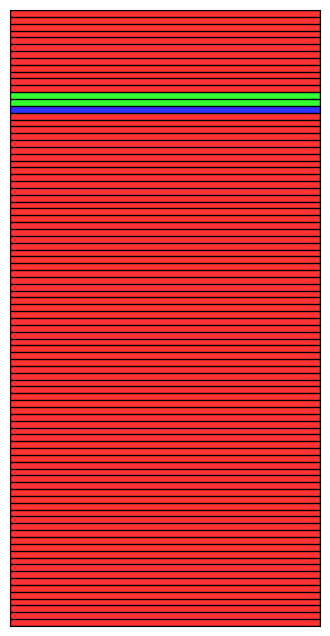

In [20]:
draw_1d_grid(id_array[number],nbars_array[number])

2


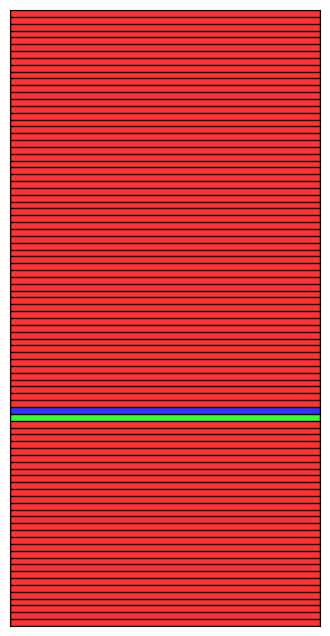

2


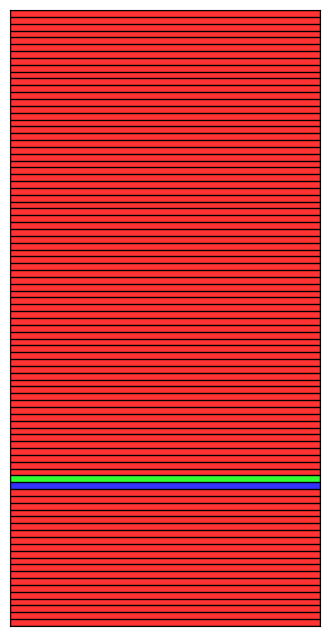

2


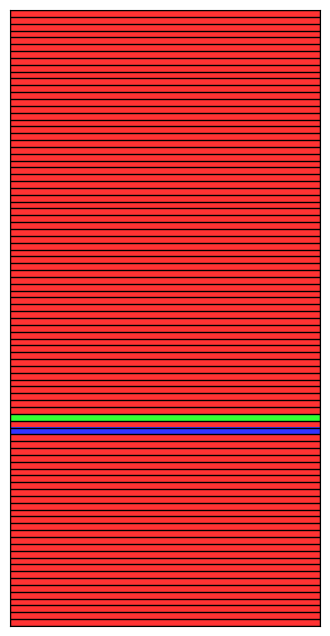

3


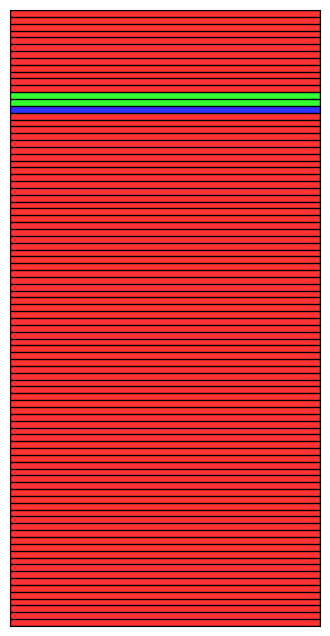

2


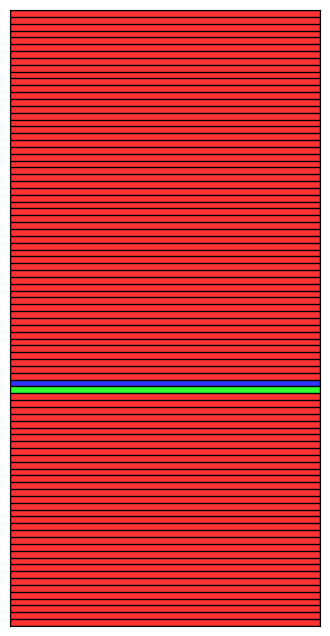

3


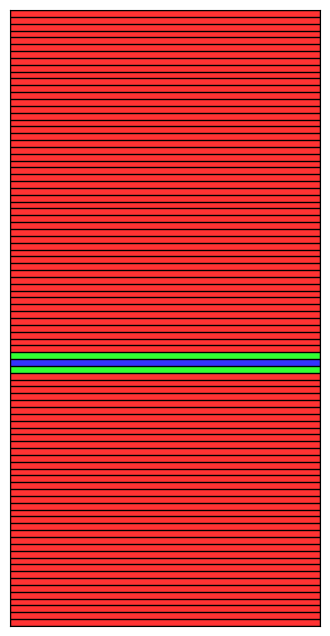

In [21]:
for i in range(0,len(eventCheck)):
    print(nbars_array[i])
    draw_1d_grid(id_array[i],nbars_array[i])


In [22]:
len(nbars_array)

802179

# PathFinding

### Define path

In [23]:
# Function to determine path from master block to any other block in 1D
def find_path_to_block_1d(master_block, target_block):
    current_block = master_block
    path = []
    
    # Traverse vertically (since it's a 1D detector, we only move up or down)
    while current_block != target_block:
        if current_block < target_block:
            next_block = current_block + 1  # Move down (increment block ID)
        else:
            next_block = current_block - 1  # Move up (decrement block ID)
        
        path.append(f"{current_block}to{next_block}")
        current_block = next_block

    return path

# Example usage:
master_block = 45  # Master block
target_block = 90  # Target block for the path calculation
path = find_path_to_block_1d(master_block, target_block)
print(f"Path from block {master_block} to block {target_block}: {path}")


Path from block 45 to block 90: ['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82', '82to83', '83to84', '84to85', '85to86', '86to87', '87to88', '88to89', '89to90']


### Path Finding Visualization

Path from 45 to 46: ['45to46']


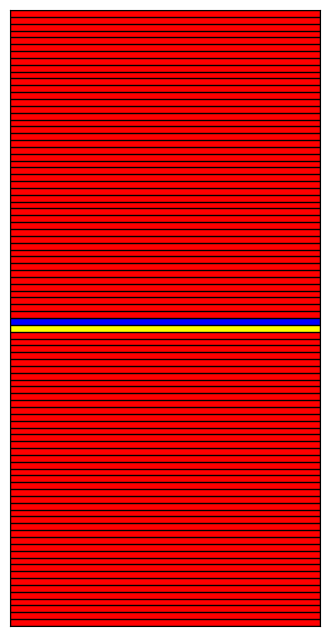

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to draw a 1D vertical detector with 90 bars and plot path from master block to target block
def draw_1d_grid_with_path(master_block, target_block, path):
    rows, cols = 90, 1  # 90 bars vertically, 1 column
    grid = np.zeros((rows, cols))
    
    # Mark the path on the grid
    for connection in path:
        start_block, end_block = map(int, connection.split('to'))
        grid[end_block, 0] = 1  # Mark path cells as green
        
    # Mark the master block and target block separately
    grid[master_block, 0] = 2  # Mark the master block as blue
    grid[target_block, 0] = 3  # Mark the target block as yellow
    
    # Create a colormap with transparency
    cmap = mcolors.ListedColormap(['red', 'green', 'blue', 'yellow'])  # Red: other, Green: path, Blue: master, Yellow: target
    
    # Plot the grid
    fig, ax = plt.subplots(figsize=(4, 8))  # Adjusted size for vertical display
    ax.imshow(grid, cmap=cmap, aspect='auto')
    
    # Draw the gridlines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Show the plot
    plt.show()

# Example usage:
master_block = 45
target_block = 46
path = find_path_to_block_1d(master_block, target_block)  # Assume you already have the path function
print(f"Path from {master_block} to {target_block}: {path}")
draw_1d_grid_with_path(master_block, target_block, path)


### Path Finding Variables

In [25]:
import random

# Function to get adjacent blocks for a 1D vertical detector
def get_adjacent_blocks_1d(block_id, max_blocks=90):
    adjacent_blocks = []
    
    # Above neighbor
    if block_id > 0:  # Block 0 has no block above it
        adjacent_blocks.append(block_id - 1)
    
    # Below neighbor
    if block_id < max_blocks - 1:  # Last block has no block below it
        adjacent_blocks.append(block_id + 1)
    
    return adjacent_blocks

# Function to initialize path variables between adjacent blocks for 1D detector
def initialize_adjacent_path_variables_1d(max_blocks=90):
    path_values = {}  # Dictionary to store path variables and their values

    # Loop through all blocks in the 1D detector
    for block in range(max_blocks):  # Blocks from 0 to 89
        adjacent_blocks = get_adjacent_blocks_1d(block, max_blocks)  # Get adjacent blocks
        
        # Create path variables for each adjacent block
        for adj_block in adjacent_blocks:
            path_name = f"{block}to{adj_block}"
            reverse_path_name = f"{adj_block}to{block}"
            
            # Assign random values between 0 and 2
            path_values[path_name] = -1000
            path_values[reverse_path_name] = -1000

    return path_values

# Example usage:
path_variables = initialize_adjacent_path_variables_1d()




In [26]:
len(path_variables)

178

### Histogram Initialization

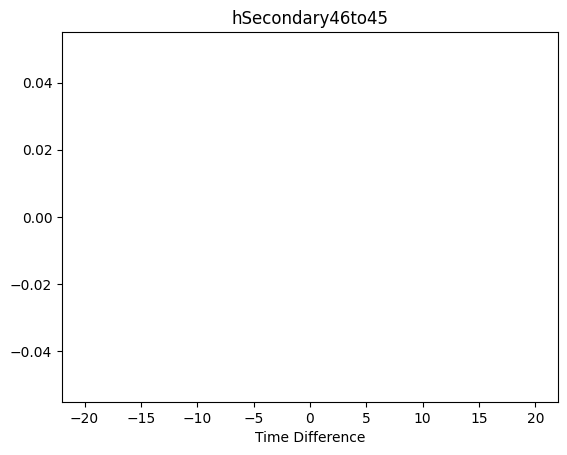

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get adjacent blocks for a 1D vertical detector
def get_adjacent_blocks_1d(block_id, max_blocks=90):
    adjacent_blocks = []
    
    # Above neighbor
    if block_id > 0:  # Block 0 has no block above it
        adjacent_blocks.append(block_id - 1)
    
    # Below neighbor
    if block_id < max_blocks - 1:  # Last block has no block below it
        adjacent_blocks.append(block_id + 1)
    
    return adjacent_blocks

# Function to initialize empty histograms for adjacent paths for 1D detector
def initialize_adjacent_histograms_1d(max_blocks=90):
    histograms = {}  # Dictionary to store histograms
    
    # Loop through all blocks in the 1D detector
    for block in range(max_blocks):  # Blocks from 0 to 89
        adjacent_blocks = get_adjacent_blocks_1d(block, max_blocks)  # Get adjacent blocks
        
        # Create empty histograms for each adjacent block pair
        for adj_block in adjacent_blocks:
            hist_name = f"hPrimary{block}to{adj_block}"
            reverse_hist_name = f"hPrimary{adj_block}to{block}"
            
            # Initialize histograms as empty arrays
            histograms[hist_name] = np.array([])  # Empty array for histogram
            histograms[reverse_hist_name] = np.array([])  # Empty array for reverse path
        for adj_block in adjacent_blocks:
            hist_name = f"hSecondary{block}to{adj_block}"
            reverse_hist_name = f"hSecondary{adj_block}to{block}"
            
            # Initialize histograms as empty arrays
            histograms[hist_name] = np.array([])  # Empty array for histogram
            histograms[reverse_hist_name] = np.array([])  # Empty array for reverse path
    return histograms

# Function to plot a specific histogram by name
def plot_histogram(histograms, hist_name):
    if hist_name in histograms:
        plt.hist(histograms[hist_name], bins=150, range=(-20, 20), alpha=0.75, color='dodgerblue')
        plt.title(f"{hist_name}")
        plt.xlabel('Time Difference')
        
        plt.show()
    else:
        print(f"Histogram {hist_name} not found!")

# Example usage:
histograms = initialize_adjacent_histograms_1d()

# Example: Plot a specific histogram, e.g., for the path 45 to 46
plot_histogram(histograms, 'hSecondary46to45')


# Populate the histograms

(array([     0.,      0., 516057., 235529.,  50593.,      0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

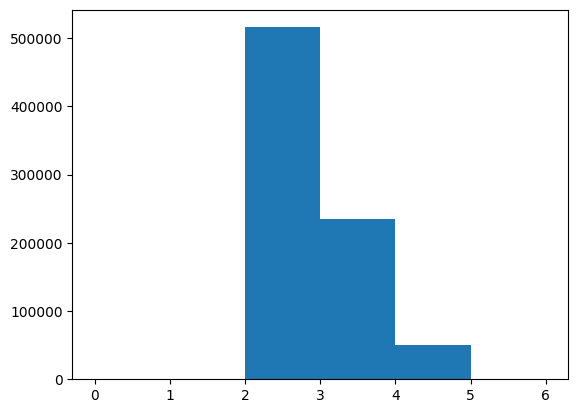

In [28]:
plt.hist(nbars_array,range=(0,6),bins=6)

In [29]:
#trigbits cut
#nbars < 3 cut
#make correct bar primary 
#cut = nblk[0]>1

# Found two distributions for if the bar is primary or secondary in the cluster

Starting File 0
Starting File 1
Starting File 2
Starting File 3
Starting File 4
Starting File 5
Starting File 6
1.0233222211892208
45 First: 154098 46 First: 150586


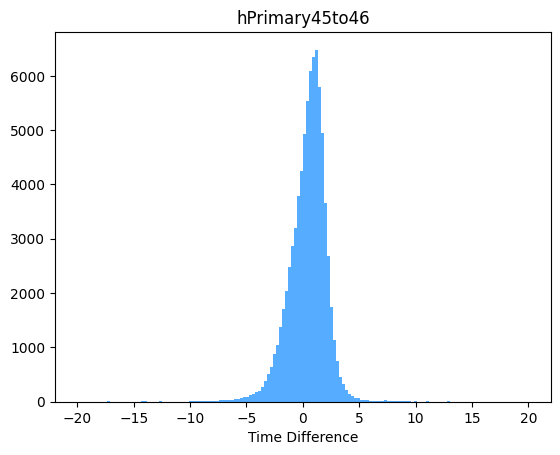

CPU times: user 5min 40s, sys: 1.03 s, total: 5min 41s
Wall time: 5min 40s


In [108]:
%%time
tot1array=[]
tot2array=[]
time45Parray=[]
time45Sarray=[]
time_diffParray=[]
time_diffSarray=[]
import numpy as np
def populate_histograms_multiple_events_1d(cblkid_2d, cblktime_2d, nbar_array, histograms):
    
    
    n45=0
    n46=0
    for k in range(0,7):
        print(f"Starting File {k}")
        dataToLoad=np.load(f"../outfiles/HodoArrays/hodo_data{k}.npz")
        id_array=dataToLoad["hodoID_array"].astype(int)
        time_array=dataToLoad["hodoTime_array"]
        nbars_array=dataToLoad["nbars_array"].astype(int)
        
        cblkid_2d=id_array
        cblktime_2d=time_array
        nbar_array=nbars_array
        
        
        num_events = len(cblkid_2d) 
        #num_events=100
        # Loop 
        for event_idx in range(num_events):
            cblkid = cblkid_2d[event_idx] # Bar IDs for this event
            cblktime = cblktime_2d[event_idx]  # Bar times for this event
            nbar = nbar_array[event_idx]  # Number of valid bars in this event
            tot_array1d=tot_array[event_idx]
            

            # Populate histograms
            for i in range(nbar):
                #print(f"Currently on bar index {i+1} out of {nbar}")
                for j in range(i + 1, nbar):  # Compare with the next bar in the list
                    #print(f"Comparing to next bar: {j+1} out of {nbar}")
                    
                    bar1 = cblkid[i]                    
                    bar2 = cblkid[j]
                    
                    tot1=tot_array1d[i]
                    tot2=tot_array1d[j]
                    
                    time1 = cblktime[i]
                    time2 = cblktime[j]
                    
                    #if int(bar1)==45 or int(bar2)==45:
                    if True:

                        
                        
                        
                        if abs(bar1-bar2) == 1:
                            time_diff=cblktime[i]-cblktime[j]
                        
                            
                            histograms[f"hPrimary{bar1}to{bar2}"] = np.append(histograms[f"hPrimary{bar1}to{bar2}"], time_diff)
                            histograms[f"hSecondary{bar2}to{bar1}"] = np.append(histograms[f"hSecondary{bar2}to{bar1}"], -time_diff)
                            if(bar1==45):
                                n45+=1
                                time45Parray.append(cblktime[i])
                                tot1array.append(tot1)
                                time_diffParray.append(time_diff)
                                #print(f"PRIMARY  : Bar45 time: {np.round(cblktime[i],3)} Bar46 time: {np.round(cblktime[j],3)}")
                            if(bar2==45):
                                n46+=1
                                time45Sarray.append(cblktime[j])
                                tot2array.append(tot2)
                                time_diffSarray.append(-time_diff)
                                #print(f"SECONDARY: Bar45 time: {np.round(cblktime[j],3)} Bar46 time: {np.round(cblktime[i],3)}")

    print(n45/n46)
    print(f"45 First: {n45} 46 First: {n46}")

histograms = initialize_adjacent_histograms_1d()  


populate_histograms_multiple_events_1d(id_array, time_array, nbars_array, histograms)


plot_histogram(histograms,  "hPrimary45to46")


In [109]:
len(time45Parray)

154098

In [110]:
len(tot1array)

154098

In [111]:
tot1array[0]

21.200400000000002

Text(10, 6.5, 'Secondary')

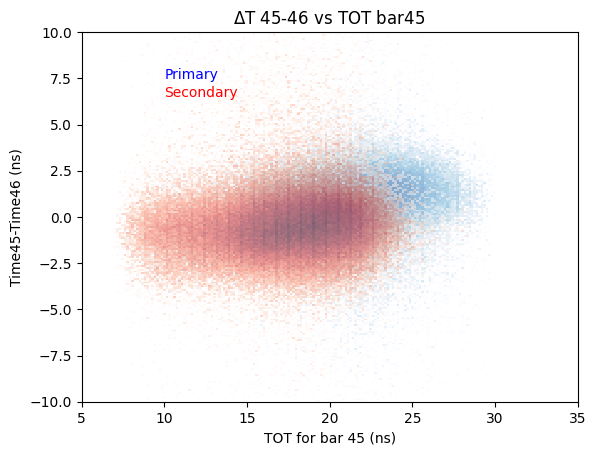

In [147]:

from matplotlib.colors import LogNorm
PRIME=plt.hist2d(tot1array,np.array(time_diffParray),alpha=.5,bins=(200,200),range=((5,35),(-10,10)),norm=LogNorm(),cmap="Blues")
plt.title("$\Delta$T 45-46 vs TOT bar45 ")
plt.xlabel("TOT for bar 45 (ns)")
plt.ylabel("Time45-Time46 (ns)")
Secondary=plt.hist2d(tot2array,np.array(time_diffSarray),alpha=.5,bins=(200,200),range=((5,35),(-10,10)),norm=LogNorm(),cmap="Reds")
plt.text(10,7.5,"Primary",color='blue')
plt.text(10,6.5,"Secondary",color='red')



Text(0, 0.5, 'Time45-Time46 (ns)')

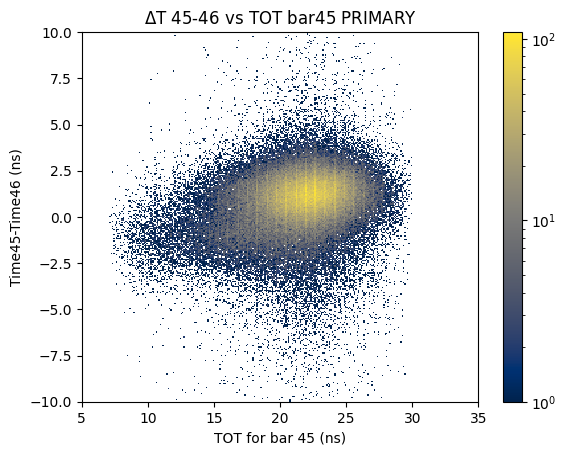

In [148]:
PRIME=plt.hist2d(tot1array,np.array(time_diffParray),bins=(300,300),range=((5,35),(-10,10)),norm=LogNorm(),cmap="cividis")
plt.title("$\Delta$T 45-46 vs TOT bar45 PRIMARY")
plt.colorbar()
plt.xlabel("TOT for bar 45 (ns)")
plt.ylabel("Time45-Time46 (ns)")

Text(0, 0.5, 'Time45-Time46 (ns)')

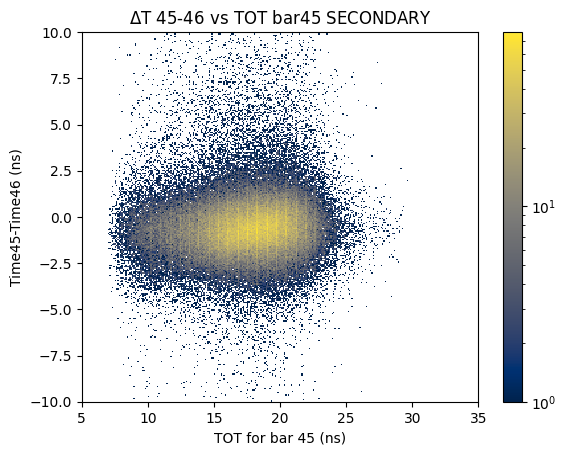

In [113]:

from matplotlib.colors import LogNorm
Secondary=plt.hist2d(tot2array,np.array(time_diffSarray),bins=(300,300),range=((5,35),(-10,10)),norm=LogNorm(),cmap="cividis")
plt.title("$\Delta$T 45-46 vs TOT bar45 SECONDARY")
plt.colorbar()
plt.xlabel("TOT for bar 45 (ns)")
plt.ylabel("Time45-Time46 (ns)")

Text(0.5, 0, 'TOT (ns)')

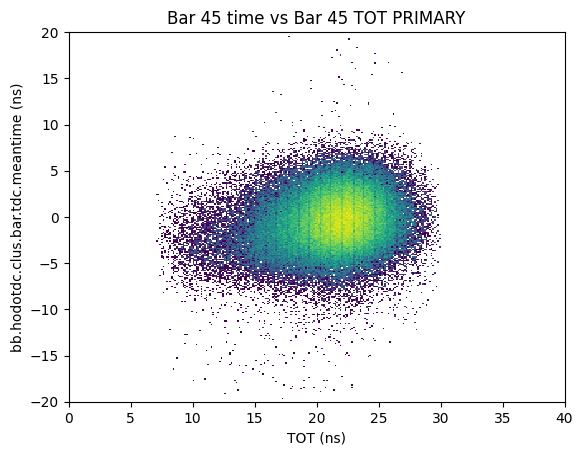

In [163]:
SECOND=plt.hist2d(tot1array,np.array(time45Parray),bins=(300,300),range=((0,40),(-20,20)),norm=LogNorm())
plt.title("Bar 45 time vs Bar 45 TOT PRIMARY")
plt.ylabel("bb.hodotdc.clus.bar.tdc.meantime (ns)")
plt.xlabel("TOT (ns)")

Text(0.5, 0, 'TOT (ns)')

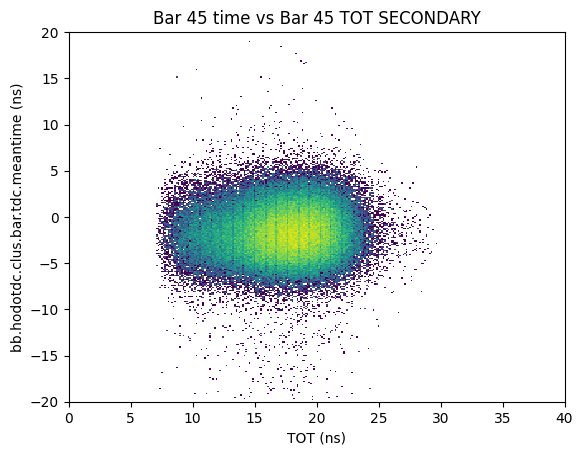

In [165]:
SECOND=plt.hist2d(tot2array,np.array(time45Sarray),bins=(300,300),range=((0,40),(-20,20)),norm=LogNorm())
plt.title("Bar 45 time vs Bar 45 TOT SECONDARY")
plt.ylabel("bb.hodotdc.clus.bar.tdc.meantime (ns)")
plt.xlabel("TOT (ns)")

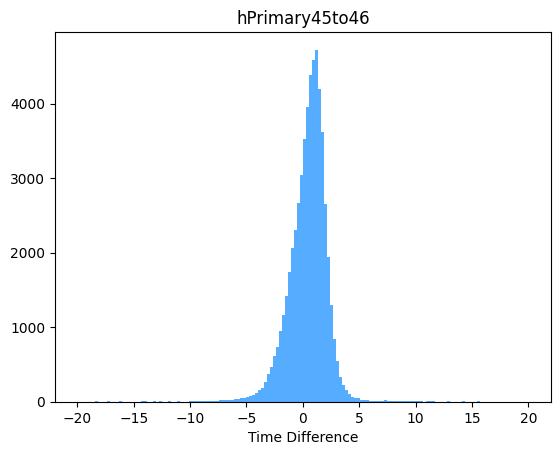

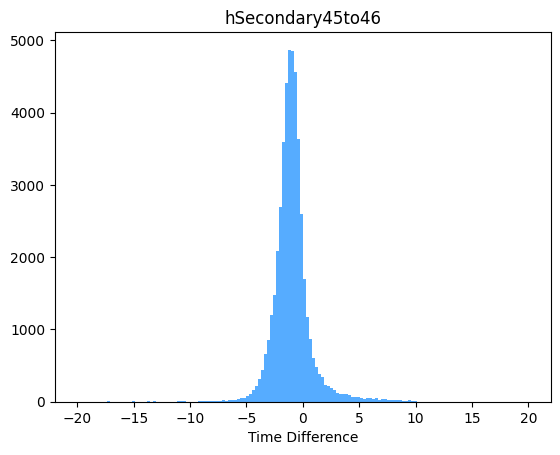

In [88]:
plot_histogram(histograms,  "hPrimary45to46")
plot_histogram(histograms,  "hSecondary45to46")


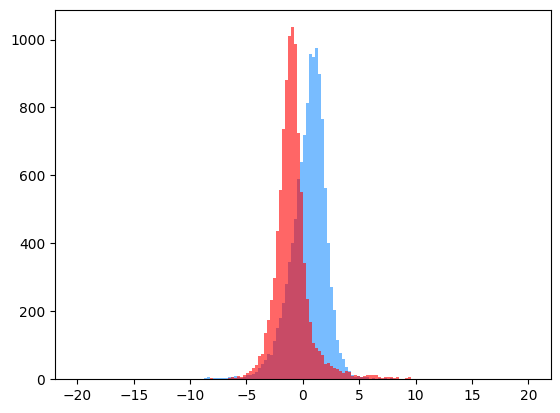

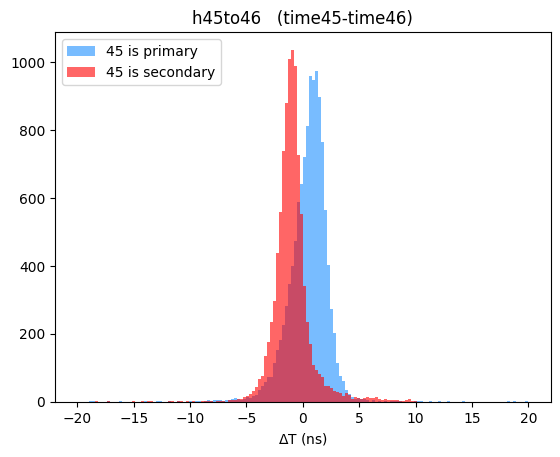

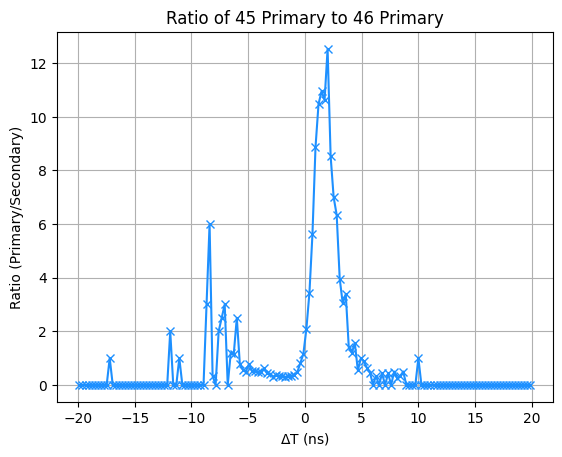

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histograms and extract the counts and bin edges
hp = plt.hist(histograms["hPrimary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='dodgerblue', label="45 is primary")
hs = plt.hist(histograms["hSecondary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='red', label="45 is secondary")

# Extract counts and bin edges
counts_hp, bins = hp[0], hp[1]
counts_hs = hs[0]

# Calculate bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate the ratio with handling for division by zero
ratio = np.divide(counts_hp, counts_hs, out=np.zeros_like(counts_hp, dtype=float), where=counts_hs != 0)

# Plot the histograms
plt.figure()
plt.hist(histograms["hPrimary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='dodgerblue', label="45 is primary")
plt.hist(histograms["hSecondary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='red', label="45 is secondary")
plt.title("h45to46   (time45-time46)")
plt.legend(loc="upper left")
plt.xlabel("$\Delta$T (ns)")

# Plot the ratio
plt.figure()
plt.plot(bin_centers, ratio, 'x-', color='dodgerblue')
plt.title("Ratio of 45 Primary to 46 Primary")
plt.xlabel("$\Delta$T (ns)")
plt.ylabel("Ratio (Primary/Secondary)")
plt.grid(True)
plt.show()


Text(0.5, 0, '$\\Delta$T (ns)')

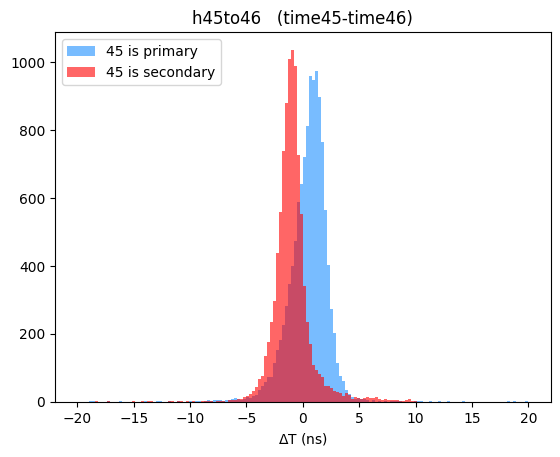

In [157]:
hp=plt.hist(histograms["hPrimary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='dodgerblue',label="45 is primary")
hs=plt.hist(histograms["hSecondary45to46"], bins=150, range=(-20, 20), alpha=0.6, color='red',label="45 is secondary")
plt.title("h45to46   (time45-time46)")
plt.legend(loc="upper left")
plt.xlabel("$\Delta$T (ns)")


Text(0.5, 0, '$\\Delta$T (ns)')

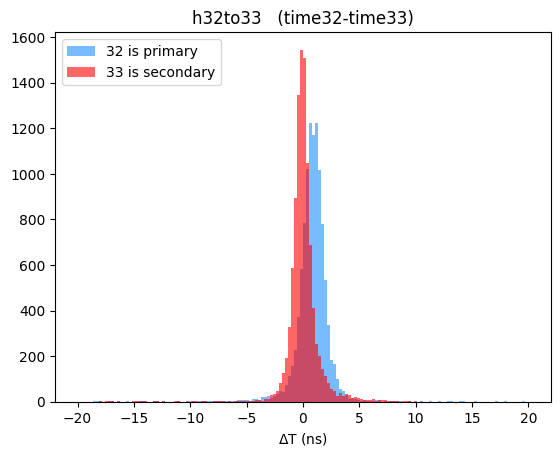

In [138]:
p=plt.hist(histograms["hPrimary32to33"], bins=150, range=(-20, 20), alpha=0.6, color='dodgerblue',label="32 is primary")
p=plt.hist(histograms["hSecondary32to33"], bins=150, range=(-20, 20), alpha=0.6, color='red',label="33 is secondary")
plt.title("h32to33   (time32-time33)")
plt.legend(loc="upper left")
plt.xlabel("$\Delta$T (ns)")

# Gary's way

Starting File 0


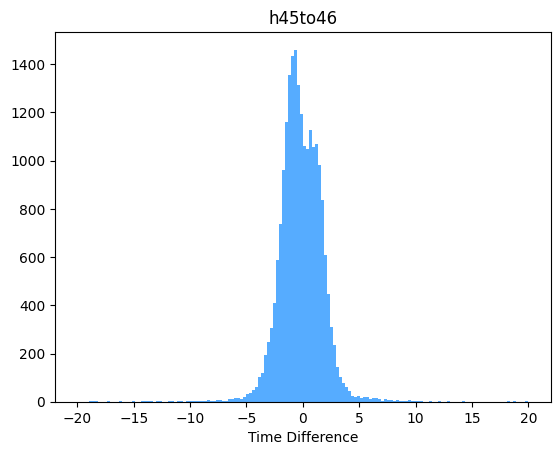

CPU times: user 1min 34s, sys: 551 ms, total: 1min 35s
Wall time: 1min 34s


In [62]:
%%time
"""
import numpy as np
def populate_histograms_multiple_events_1d(cblkid_2d, cblktime_2d, nbar_array, histograms):
    for k in range(0, 1):
        print(f"Starting File {k}")
        dataToLoad = np.load(f"../outfiles/HodoArrays/hodo_data{k}.npz")
        id_array = dataToLoad["hodoID_array"].astype(int)
        time_array = dataToLoad["hodoTime_array"]
        nbars_array = dataToLoad["nbars_array"].astype(int)

        cblkid_2d = id_array
        cblktime_2d = time_array
        nbar_array = nbars_array

        num_events = len(cblkid_2d)
        #num_events=100000
        for event_idx in range(num_events):
            cblkid = cblkid_2d[event_idx]  # Bar IDs for this event
            cblktime = cblktime_2d[event_idx]  # Bar times for this event
            nbar = nbar_array[event_idx]  # Number of valid bars in this event
            
            for i in range(0, 89):
                id1 = i
                id2 = i + 1
                time1 = -999
                time2 = -999

                for j, bar in enumerate(cblkid[:nbar]):
                    
                    if bar == id1:
                        time1 = cblktime[j]
                    if bar == id2:
                        time2 = cblktime[j]
                
                if time1 == -999 or time2 == -999:
                    continue
                
                time_diff = time1 - time2
                histograms[f"h{id1}to{id2}"] = np.append(histograms.get(f"h{id1}to{id2}", np.array([])), time_diff)
                histograms[f"h{id2}to{id1}"] = np.append(histograms.get(f"h{id2}to{id1}", np.array([])), -time_diff)

histograms = initialize_adjacent_histograms_1d()

populate_histograms_multiple_events_1d(id_array, time_array, nbars_array, histograms)

plot_histogram(histograms, 'h45to46')
"""

# Fitting with double gaussian

[0.4739584171864878, 1.614557346939602, 233.75, 1.4739584171864877, 1.614557346939602, 116.875]
Double Gaussian fit failed, trying single


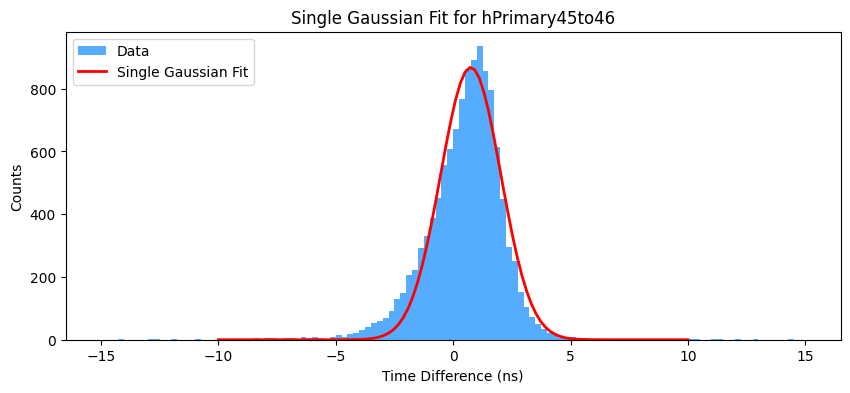

Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Double Gaussian function
def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    """Double Gaussian function: sum of two Gaussian curves."""
    return (A1 * norm.pdf(x, mu1, sigma1)) + (A2 * norm.pdf(x, mu2, sigma2))
def single_gaussian(x, mu, sigma, A):
    """Single Gaussian function."""
    return A * norm.pdf(x, mu, sigma)
def find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2):
    # Create a fine grid of x-values within the relevant range (adjust this range as needed)
    x = np.linspace(-15, 15, 1000)
    
    # Evaluate the double Gaussian function over this grid
    y = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
    
    # Find the x-value where the function reaches its maximum
    peak_x = x[np.argmax(y)]
    peak_y = np.max(y)
    
    return peak_x, peak_y

def calculate_fwhm(x, y, peak_y):
    half_max = peak_y / 2  # Half of the maximum value
    # Find indices where the Gaussian curve crosses the half-max value
    indices = np.where(y >= half_max)[0]
    if len(indices) < 2:
        return None, None, None, None  # In case FWHM cannot be determined

    # The left and right boundaries for the FWHM
    left_idx = indices[0]
    right_idx = indices[-1]

    # The x-values corresponding to the FWHM
    left_fwhm = x[left_idx]
    right_fwhm = x[right_idx]

    fwhm_value = right_fwhm - left_fwhm
    
    return left_fwhm, right_fwhm, fwhm_value, half_max

# Function to plot a histogram and fit a double Gaussian function to it
def plot_histogram_with_double_gaussian(histograms, hist_name,pdf=False):
    fig = plt.figure(figsize=(10, 4))  # Initialize the figure here
    try:        
        if hist_name in histograms:
            datah = histograms[hist_name]
            # Filter the data to only include values in the range [-10, 10]
            data = datah[(datah >= -10) & (datah <= 10)]
            nEntries = len(data)
            # Plot the histogram of the original data with counts on the y-axis
            counts, bins, _ = plt.hist(datah, bins=120, alpha=0.75, color='dodgerblue', range=(-15, 15), label='Data')
            bin_width = bins[1] - bins[0]

            # Use bin centers for fitting
            bin_centers = (bins[:-1] + bins[1:]) / 2

            # Initial guesses for the parameters of the double Gaussian
            mu1_initial, sigma1_initial = norm.fit(data)
            mu2_initial, sigma2_initial = mu1_initial + 1, sigma1_initial
            A1_initial, A2_initial = max(counts) * bin_width, max(counts) * bin_width / 2  # Scale amplitudes to match the histogram

            initial_guess = [mu1_initial, sigma1_initial, A1_initial, mu2_initial, sigma2_initial, A2_initial]
            print(initial_guess)
            # Fit the double Gaussian to the data
            popt, _ = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
            mu1, sigma1, A1, mu2, sigma2, A2 = popt
            peak_x, peak_y = find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2)

            x = np.linspace(-10, 10, 100)
            # Generate the fitted double Gaussian curve
            p_double_gaussian = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
            #fwhm addition
            left_fwhm, right_fwhm, fwhm_value, half_max = calculate_fwhm(x, p_double_gaussian, peak_y)
            print(f"Peak of the double Gaussian occurs at x = {peak_x:.2f} with height = {peak_y:.2f}")

            # PLOTTING
            plt.plot(x, p_double_gaussian, 'r', linewidth=2, label=f'Double Gaussian Fit: \nMean 1={mu1:.2f}, std1={sigma1:.2f} \nMean 2={mu2:.2f}, std2={sigma2:.2f}')

            if fwhm_value != None:
                plt.hlines(half_max, left_fwhm, right_fwhm, colors='blue', linestyles='-', lw=2, label=f"FWHM = {np.round(fwhm_value, 3)}ns")

            # Add labels and title
            plt.title(f"Double Gaussian Fit for {hist_name}")
            plt.xlabel('Time Difference (ns)')
            plt.ylabel("Counts")
            if fwhm_value != None:
                plt.text(-13, half_max, f"N Entries: {nEntries}")
                plt.text(-13, half_max / 1.5, f"FWHM/sqrt(N): {np.round(fwhm_value / np.sqrt(nEntries), 3)}")
                error = fwhm_value / np.sqrt(nEntries)
            else:
                error = 100
            plt.legend(loc='upper left')

            # MEAN1,2 and X^2-----------------------------------------

            # Step 1: Calculate the number of events under each Gaussian
            N1 = abs(A1) * np.sqrt(2 * np.pi) * sigma1  # Number of events under Gaussian 1
            N2 = abs(A2) * np.sqrt(2 * np.pi) * sigma2  # Number of events under Gaussian 2

            # Step 2: Calculate the accuracy as standard error
            accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
            accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2

            # Step 3: Calculate the combined weighted mean (mean1-2)
            mean1_2 = (mu1 / accuracy1**2 + mu2 / accuracy2**2) / (1 / accuracy1**2 + 1 / accuracy2**2)

            # Step 4: Calculate the uncertainty in the combined mean
            sigma_mean1_2 = 1 / np.sqrt(1 / accuracy1**2 + 1 / accuracy2**2)

            # Step 5: Chi-squared calculation for the combined mean
            chi_squared = ((mu1 - mean1_2)**2 / accuracy1**2) + ((mu2 - mean1_2)**2 / accuracy2**2)

            # Plot the combined mean on the graph
            if A1 > 0 and A2 > 0:
                plt.axvline(mean1_2, color='black', lw=1, label=f"Mean1-2: {np.round(mean1_2, 3)}ns ± {np.round(sigma_mean1_2, 3)}")
            else:
                plt.axvline(peak_x, color='black', lw=1, label=f"Mean1-2: {np.round(peak_x, 3)}ns ± {np.round(error, 3)}")

            

            # Print out the combined mean and chi-squared
            print(f"Combined Mean (mean1-2): {mean1_2:.3f}")
            print(f"Uncertainty in Combined Mean: {sigma_mean1_2:.3f}")
            print(f"Chi-Squared/DOF: {chi_squared:.3f}")
            print(f"(A1, A2): ({A1}, {A2})")

            # Optionally, you could return these values if you need to use them later
            if not pdf:
                plt.show()
                if A1 > 0 and A2 > 0:
                    return peak_x, error, mean1_2, sigma_mean1_2, chi_squared / 2
                else:
                    return peak_x, error, peak_x, error, chi_squared / 2
            else:
                return fig
            # ---------------------------------------------------------

        else:
            print(f"Histogram {hist_name} not found!")
    except:
        print("Double Gaussian fit failed, trying single")
        mu_initial, sigma_initial = norm.fit(data)
        A_initial = max(counts) * bin_width
        initial_guess = [mu_initial, sigma_initial, A_initial]
        try:
            # Fit single Gaussian
            popt, _ = curve_fit(single_gaussian, bin_centers, counts, p0=initial_guess)
            mu, sigma, A = popt
            x = np.linspace(-10, 10, 100)
    
            p_single_gaussian = single_gaussian(x, mu, sigma, A)
            
            plt.plot(x, p_single_gaussian, 'r', linewidth=2, label='Single Gaussian Fit')
            plt.title(f"Single Gaussian Fit for {hist_name}")
            plt.xlabel('Time Difference (ns)')
            plt.ylabel("Counts")
            plt.legend(loc='upper left')
            if pdf==False:
                plt.show()
            else:
                return fig
            print(f"Single Gaussian peak at mu = {mu:.2f} with std dev = {sigma:.2f} and amplitude = {A:.2f}")

        except Exception as e:
            print(f"Single Gaussian fit also failed: {e}")
            
# Example usage:
plot_histogram_with_double_gaussian(histograms, 'hPrimary45to46')


# $X ^2$ Minimization

In [ ]:
[0.4739584171864878, 1.614557346939602, 233.75, 1.4739584171864877, 1.614557346939602, 116.875]

In [ ]:
[-0.9444752735951278, 1.6657156058530478, 240.0, 0.05552472640487216, 1.6657156058530478, 120.0]

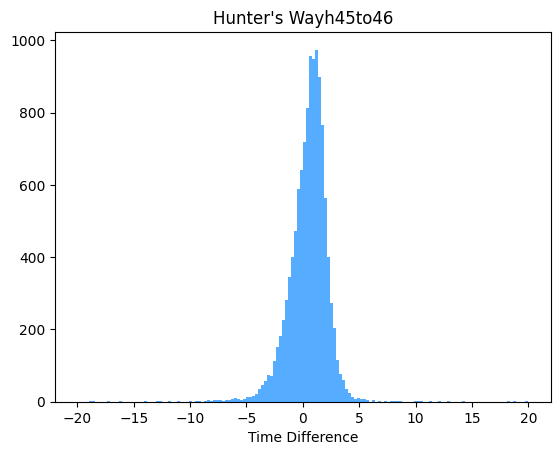

In [69]:
plot_histogram(histograms, 'h45to46')


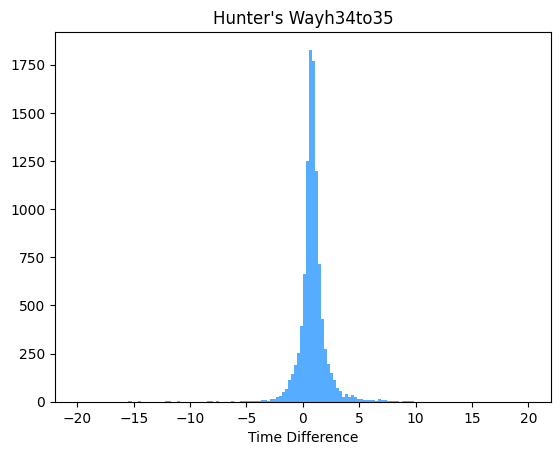

In [86]:
plot_histogram(histograms, 'h34to35')


# Pathfinding Histograms

In [71]:
#BadPaths

['0to1', '1to2', '2to3', '3to4', '4to5', '5to6', '6to7', '7to8', '8to9', '9to10', '10to11', '11to12', '12to13', '13to14', '14to15', '15to16', '16to17', '17to18', '18to19', '19to20', '20to21', '21to22', '22to23', '23to24', '24to25', '25to26', '26to27', '27to28', '28to29', '29to30', '30to31', '31to32', '32to33', '33to34', '34to35', '35to36', '36to37', '37to38', '38to39', '39to40', '40to41', '41to42', '42to43', '43to44', '44to45', '45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82', '82to83', '83to84', '84to85', '85to86', '86to87', '87to88', '88to89']


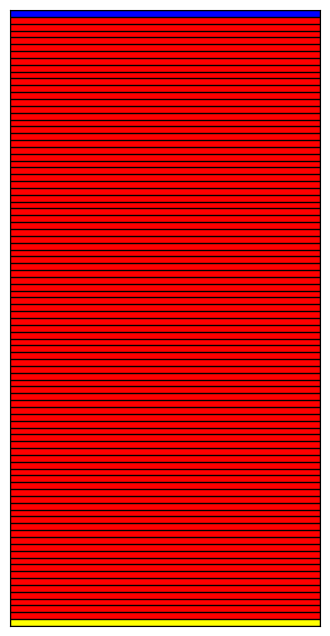

In [119]:
master_block = 0
target_block = 89
path = find_path_to_block_1d(master_block, target_block)  # Assume you already have the path function
print(path)
draw_1d_grid_with_path(master_block, target_block, path)
histogramPathPrimary= ['hPrimary' + p for p in path]

['0to1', '1to2', '2to3', '3to4', '4to5', '5to6', '6to7', '7to8', '8to9', '9to10', '10to11', '11to12', '12to13', '13to14', '14to15', '15to16', '16to17', '17to18', '18to19', '19to20', '20to21', '21to22', '22to23', '23to24', '24to25', '25to26', '26to27', '27to28', '28to29', '29to30', '30to31', '31to32', '32to33', '33to34', '34to35', '35to36', '36to37', '37to38', '38to39', '39to40', '40to41', '41to42', '42to43', '43to44', '44to45', '45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82', '82to83', '83to84', '84to85', '85to86', '86to87', '87to88', '88to89']


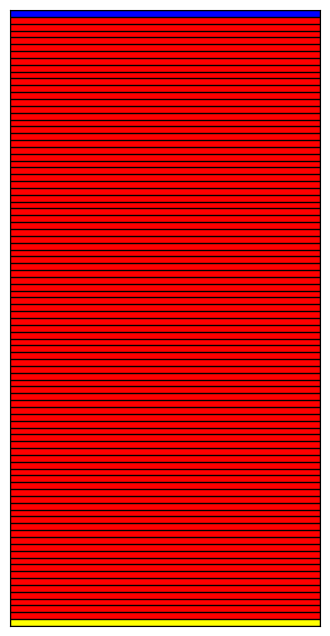

In [120]:
master_block = 0
target_block = 89
path = find_path_to_block_1d(master_block, target_block)  # Assume you already have the path function
print(path)
draw_1d_grid_with_path(master_block, target_block, path)
histogramPathSecondary= ['hSecondary' + p for p in path]

In [121]:

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Initialize the PDF file to save all plots
with PdfPages('Hodo-Primary.pdf') as pdf:
    for i in range(len(histogramPathPrimary)):
        # Generate the plot and store the result
        fig=plot_histogram_with_double_gaussian(histograms, histogramPathPrimary[i],True)
        print(fig)
        # Save the current figure to the PDF file
        pdf.savefig(fig)
        
        # Close the figure to free memory
        plt.close()

# Initialize the PDF file to save all plots
with PdfPages('Hodo-Secondary.pdf') as pdf:
    for i in range(len(histogramPathSecondary)):
        # Generate the plot and store the result
        fig=plot_histogram_with_double_gaussian(histograms, histogramPathSecondary[i],True)
        print(fig)
        # Save the current figure to the PDF file
        pdf.savefig(fig)
        
        # Close the figure to free memory
        plt.close()

print("All histograms saved to output_histograms.pdf")


[0.9351416450300125, 1.4319093061847332, 16.0, 1.9351416450300125, 1.4319093061847332, 8.0]
Peak of the double Gaussian occurs at x = 1.28 with height = 59.04
Combined Mean (mean1-2): 1.059
Uncertainty in Combined Mean: 0.051
Chi-Squared/DOF: 36.325
(A1, A2): (38.908949651005166, 99.43304262848007)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]


/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:409: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/research/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:414: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/home/research/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)
[-2.947225822010439, 0.9424725073075372, 8.25, -1.9472258220104388, 0.9424725073075372, 4.125]
Peak of the double Gaussian occurs at x = -2.90 with height = 27.79
Combined Mean (mean1-2): -3.048
Uncertainty in Combined Mean: 0.069
Chi-Squared/DOF: 26.330
(A1, A2): (3.4360127377267027, 46.64171341672195)
Figure(1000x400)
[3.3158646795482456, 1.556755838936561, 14.5, 4.315864679548246, 1.556755838936561, 7.25]
Peak of the double Gaussian occurs at x = 3.29 with height = 52.59
Combined Mean (mean1-2): 3.565
Uncertainty in Combined Mean: 0.049
Chi-Squared/DOF: 149.363
(A1, A2): (149.7975082916101, 15.390570302620674)
Figure(1000x400)
[-2.0403754368366234, 1.7146906087427367, 10.75, -1.0403754368366234, 1.7146906087427367, 5.375]
Peak of the double Gaussian occurs at x = -1.97 with height = 38.88
Combined

[0.24949973090806132, 1.4388823204992969, 225.25, 1.2494997309080613, 1.4388823204992969, 112.625]
Peak of the double Gaussian occurs at x = 0.44 with height = 874.79
Combined Mean (mean1-2): 0.396
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 54.797
(A1, A2): (822.2086018086206, 813.8105432124411)
Figure(1000x400)
[0.3476592639320697, 1.2714007944317263, 314.25, 1.3476592639320697, 1.2714007944317263, 157.125]
Peak of the double Gaussian occurs at x = 0.47 with height = 1250.51
Combined Mean (mean1-2): 0.451
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 64.327
(A1, A2): (545.0296935654104, 1528.831802882231)
Figure(1000x400)
[-0.19518496644471714, 0.8890863529880725, 253.5, 0.8048150335552828, 0.8890863529880725, 126.75]
Peak of the double Gaussian occurs at x = -0.11 with height = 1016.24
Combined Mean (mean1-2): -0.121
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 11.518
(A1, A2): (331.78471913195716, 1133.1115401127931)
Figure(1000x400)
[0.7558917295284953, 1.1

[0.6131794679242697, 1.5620415655639157, 186.75, 1.6131794679242697, 1.5620415655639157, 93.375]
Peak of the double Gaussian occurs at x = 0.77 with height = 756.57
Combined Mean (mean1-2): 0.712
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 24.349
(A1, A2): (1104.9473498956354, 510.0061146136078)
Figure(1000x400)
[0.4965872668773689, 1.268682351107743, 373.5, 1.496587266877369, 1.268682351107743, 186.75]
Peak of the double Gaussian occurs at x = 0.56 with height = 1514.14
Combined Mean (mean1-2): 0.584
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 40.340
(A1, A2): (920.1848641627712, 1806.2461687980258)
Figure(1000x400)
[-0.31578674285257047, 1.7855792628435607, 33.25, 0.6842132571474295, 1.7855792628435607, 16.625]
Peak of the double Gaussian occurs at x = 0.14 with height = 127.73
Combined Mean (mean1-2): -0.146
Uncertainty in Combined Mean: 0.034
Chi-Squared/DOF: 95.886
(A1, A2): (326.2492687132955, 86.76517715951891)
Figure(1000x400)
[-0.7947981329892783, 1.902676320

[0.26603058486559616, 1.3418156567580026, 2.0, 1.2660305848655962, 1.3418156567580026, 1.0]
Peak of the double Gaussian occurs at x = 0.05 with height = 6.45
Combined Mean (mean1-2): 0.829
Uncertainty in Combined Mean: 0.123
Chi-Squared/DOF: 64.018
(A1, A2): (11.878870900104477, 2.0049356879145472)
Figure(1000x400)
[2.0992268799035037, 1.4590989099075773, 1.0, 3.0992268799035037, 1.4590989099075773, 0.5]
Peak of the double Gaussian occurs at x = 0.62 with height = 4.01
Combined Mean (mean1-2): 1.216
Uncertainty in Combined Mean: 0.173
Chi-Squared/DOF: 28.898
(A1, A2): (1.2856114991208867, 4.23880495502494)
Figure(1000x400)
[4.143403394, 5.537401180272003, 0.25, 5.143403394, 5.537401180272003, 0.125]
Peak of the double Gaussian occurs at x = 9.62 with height = 1.00
Combined Mean (mean1-2): 4.131
Uncertainty in Combined Mean: 0.282
Chi-Squared/DOF: 380.588
(A1, A2): (0.08969726658009958, 0.08840870827424005)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occu

/home/research/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/research/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_6627/2771965967.py:105: RuntimeWarning: invalid value encountered in double_scalars
  accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
/tmp/ipykernel_6627/2771965967.py:106: RuntimeWarning: invalid value encountered in double_scalars
  accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2


[-1.5246893863722553, 1.4316190206416426, 40.5, -0.5246893863722553, 1.4316190206416426, 20.25]
Peak of the double Gaussian occurs at x = -2.06 with height = 156.85
Combined Mean (mean1-2): -1.721
Uncertainty in Combined Mean: 0.029
Chi-Squared/DOF: 114.980
(A1, A2): (27.403912510331, 388.47940562643856)
Figure(1000x400)
[-1.098280091613437, 1.8805331100694367, 12.0, -0.09828009161343698, 1.8805331100694367, 6.0]
Peak of the double Gaussian occurs at x = -0.56 with height = 44.48
Combined Mean (mean1-2): -1.093
Uncertainty in Combined Mean: 0.047
Chi-Squared/DOF: 20.709
(A1, A2): (162.8784206581719, -21.83310906834385)
Figure(1000x400)
[-2.668760342946357, 1.8105560338515065, 11.5, -1.668760342946357, 1.8105560338515065, 5.75]
Peak of the double Gaussian occurs at x = -2.78 with height = 37.20
Combined Mean (mean1-2): -2.413
Uncertainty in Combined Mean: 0.058
Chi-Squared/DOF: 191.376
(A1, A2): (136.52185062478662, 17.46423480545141)
Figure(1000x400)
[0.9962979429178749, 0.831790883000

[0.6337298643308118, 0.8315309512709737, 167.5, 1.6337298643308118, 0.8315309512709737, 83.75]
Peak of the double Gaussian occurs at x = 0.59 with height = 671.79
Combined Mean (mean1-2): 0.594
Uncertainty in Combined Mean: 0.015
Chi-Squared/DOF: 0.394
(A1, A2): (165.82317309172936, 658.2823792981177)
Figure(1000x400)
[0.2787914415225031, 1.1079207811781937, 376.75, 1.278791441522503, 1.1079207811781937, 188.375]
Peak of the double Gaussian occurs at x = 0.20 with height = 1495.01
Combined Mean (mean1-2): 0.209
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 27.675
(A1, A2): (547.4318852226359, 2009.7210417133274)
Figure(1000x400)
[0.08780277236177078, 1.2666920194960898, 365.0, 1.0878027723617707, 1.2666920194960898, 182.5]
Peak of the double Gaussian occurs at x = -0.08 with height = 1474.59
Combined Mean (mean1-2): -0.058
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 39.468
(A1, A2): (966.709920942481, 1512.5000419869698)
Figure(1000x400)
[0.5937603729690116, 1.343877466

[1.5548146339074085, 1.7240156774374922, 33.25, 2.5548146339074087, 1.7240156774374922, 16.625]
Peak of the double Gaussian occurs at x = 1.01 with height = 131.22
Combined Mean (mean1-2): 1.336
Uncertainty in Combined Mean: 0.033
Chi-Squared/DOF: 367.599
(A1, A2): (184.2364108556689, 232.65413159250164)
Figure(1000x400)
[0.9817747521893991, 1.8377827265884437, 33.25, 1.9817747521893991, 1.8377827265884437, 16.625]
Peak of the double Gaussian occurs at x = 0.62 with height = 134.04
Combined Mean (mean1-2): 0.830
Uncertainty in Combined Mean: 0.034
Chi-Squared/DOF: 126.362
(A1, A2): (166.2256950649935, 244.11225587002897)
Figure(1000x400)
[0.1449002036670138, 1.4354115545535207, 332.75, 1.1449002036670137, 1.4354115545535207, 166.375]
Peak of the double Gaussian occurs at x = -0.11 with height = 1320.61
Combined Mean (mean1-2): -0.061
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 52.598
(A1, A2): (604.8965921690702, 1037.1349155600128)
Figure(1000x400)
[0.31344182833505274, 1.226

Peak of the double Gaussian occurs at x = -2.24 with height = 4.89
Combined Mean (mean1-2): -1.719
Uncertainty in Combined Mean: 0.167
Chi-Squared/DOF: 63.307
(A1, A2): (0.8518855519785369, 3.191638073620679)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)


/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:409: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/research/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:414: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Figure(1000x400)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan
Combined Mean (mean1-2

[0.9351416450300125, 1.4319093061847332, 16.0, 1.9351416450300125, 1.4319093061847332, 8.0]
Peak of the double Gaussian occurs at x = 1.28 with height = 59.04


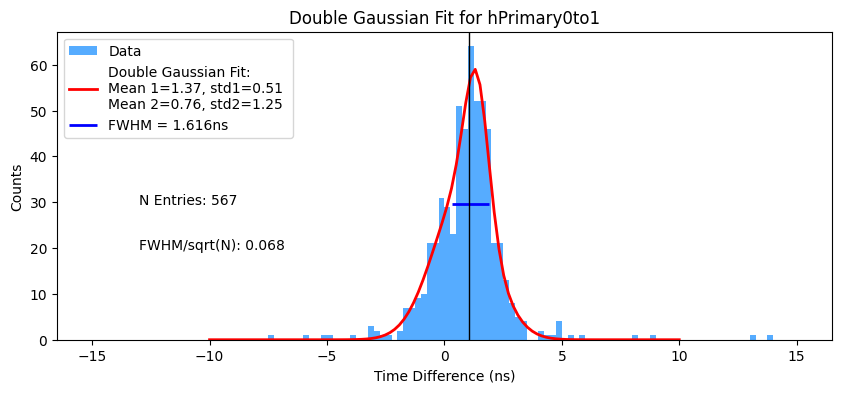

Combined Mean (mean1-2): 1.059
Uncertainty in Combined Mean: 0.051
Chi-Squared/DOF: 36.325
(A1, A2): (38.908949651005166, 99.43304262848007)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:409: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/research/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:414: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/home/research/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


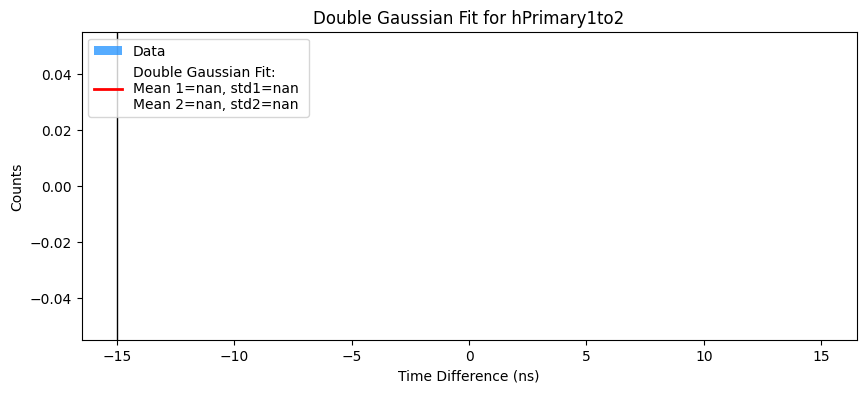

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
[-2.947225822010439, 0.9424725073075372, 8.25, -1.9472258220104388, 0.9424725073075372, 4.125]
Peak of the double Gaussian occurs at x = -2.90 with height = 27.79


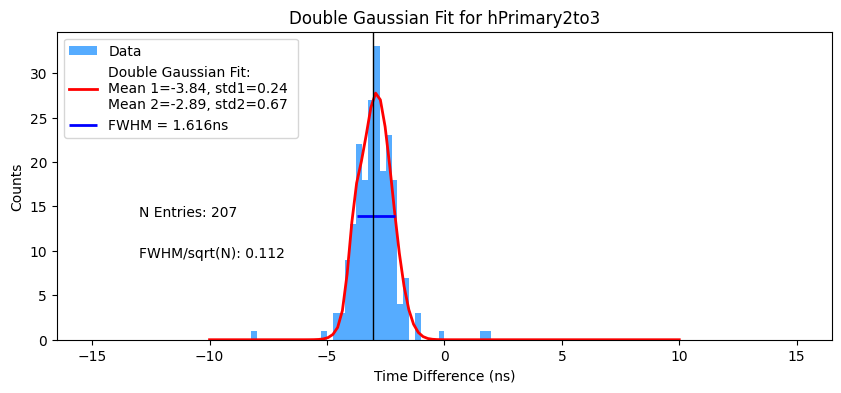

Combined Mean (mean1-2): -3.048
Uncertainty in Combined Mean: 0.069
Chi-Squared/DOF: 26.330
(A1, A2): (3.4360127377267027, 46.64171341672195)
[3.3158646795482456, 1.556755838936561, 14.5, 4.315864679548246, 1.556755838936561, 7.25]
Peak of the double Gaussian occurs at x = 3.29 with height = 52.59


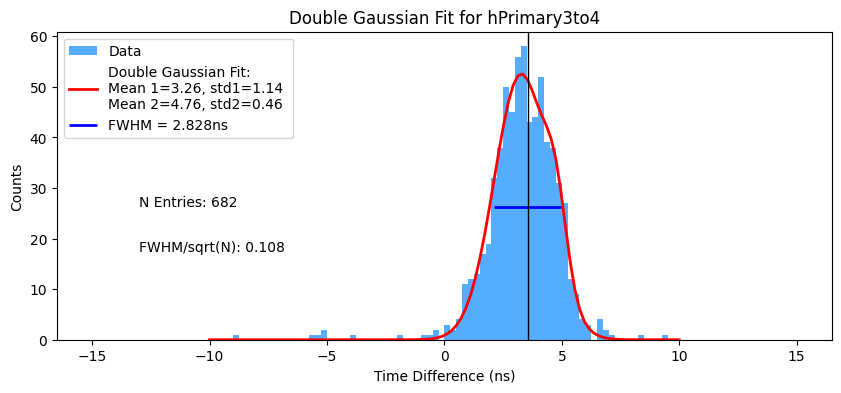

Combined Mean (mean1-2): 3.565
Uncertainty in Combined Mean: 0.049
Chi-Squared/DOF: 149.363
(A1, A2): (149.7975082916101, 15.390570302620674)
[-2.0403754368366234, 1.7146906087427367, 10.75, -1.0403754368366234, 1.7146906087427367, 5.375]
Peak of the double Gaussian occurs at x = -1.97 with height = 38.88


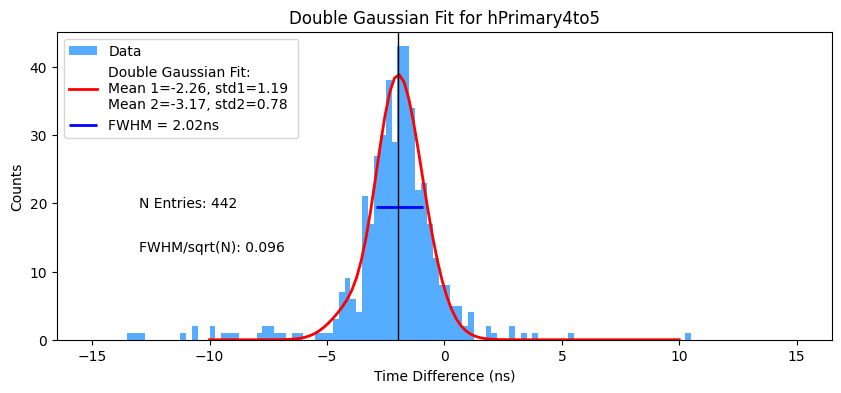

Combined Mean (mean1-2): -2.489
Uncertainty in Combined Mean: 0.051
Chi-Squared/DOF: 59.171
(A1, A2): (134.1567232163298, -29.787817634436948)
[2.2452695778564435, 1.9378363910388088, 17.5, 3.2452695778564435, 1.9378363910388088, 8.75]
Peak of the double Gaussian occurs at x = 1.67 with height = 58.69


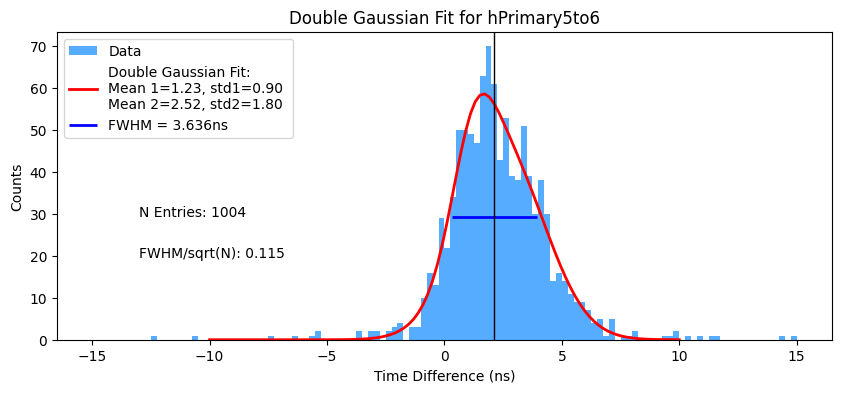

Combined Mean (mean1-2): 2.092
Uncertainty in Combined Mean: 0.049
Chi-Squared/DOF: 151.798
(A1, A2): (49.34763254875591, 197.71610912724447)
[-2.0205329386347124, 3.0564888423498147, 7.75, -1.0205329386347124, 3.0564888423498147, 3.875]
Peak of the double Gaussian occurs at x = -2.81 with height = 23.01


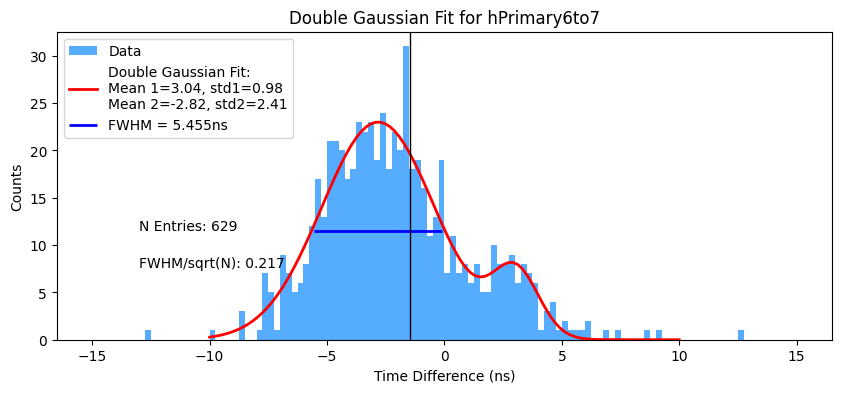

Combined Mean (mean1-2): -1.473
Uncertainty in Combined Mean: 0.073
Chi-Squared/DOF: 1141.811
(A1, A2): (16.944256955547026, 139.06772352865835)
[0.06663717129402047, 1.0968959812828434, 9.0, 1.0666371712940204, 1.0968959812828434, 4.5]
Peak of the double Gaussian occurs at x = 0.20 with height = 35.19


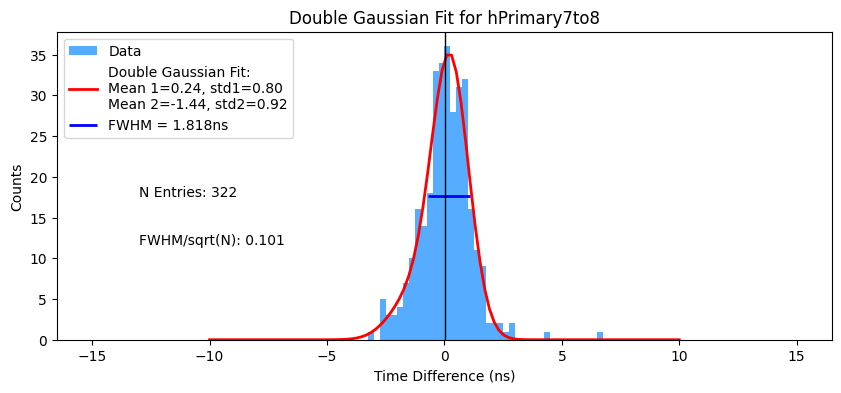

Combined Mean (mean1-2): 0.033
Uncertainty in Combined Mean: 0.064
Chi-Squared/DOF: 73.110
(A1, A2): (68.852977499518, 10.85231669119019)
[-1.0217492640787218, 1.8708229479810128, 2.25, -0.021749264078721797, 1.8708229479810128, 1.125]
Peak of the double Gaussian occurs at x = -0.44 with height = 6.34


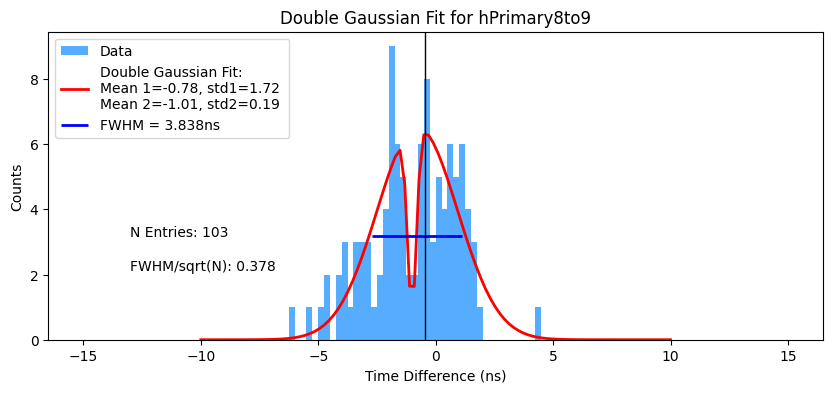

Combined Mean (mean1-2): -0.884
Uncertainty in Combined Mean: 0.115
Chi-Squared/DOF: 0.970
(A1, A2): (28.08760167294885, -2.627698536050161)
[-0.23176405264489272, 1.943749506184051, 1.75, 0.7682359473551073, 1.943749506184051, 0.875]
Peak of the double Gaussian occurs at x = -1.25 with height = 5.69


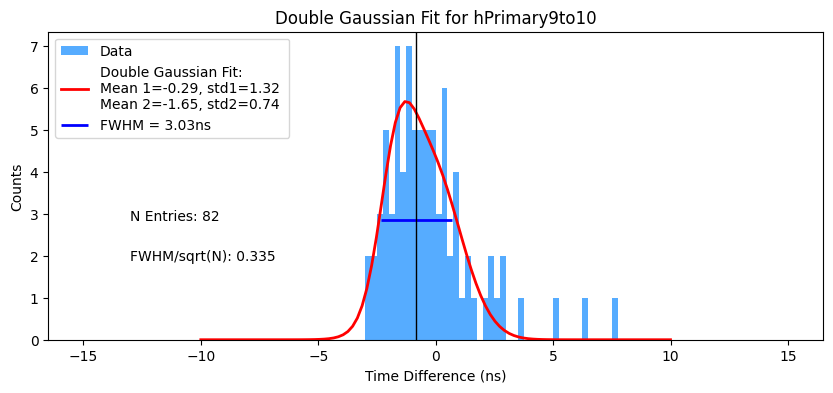

Combined Mean (mean1-2): -0.835
Uncertainty in Combined Mean: 0.150
Chi-Squared/DOF: 19.968
(A1, A2): (14.04695429745859, 5.27061097549163)
[0.013145043356460835, 1.2315275738073679, 123.75, 1.0131450433564608, 1.2315275738073679, 61.875]
Peak of the double Gaussian occurs at x = 0.26 with height = 506.11


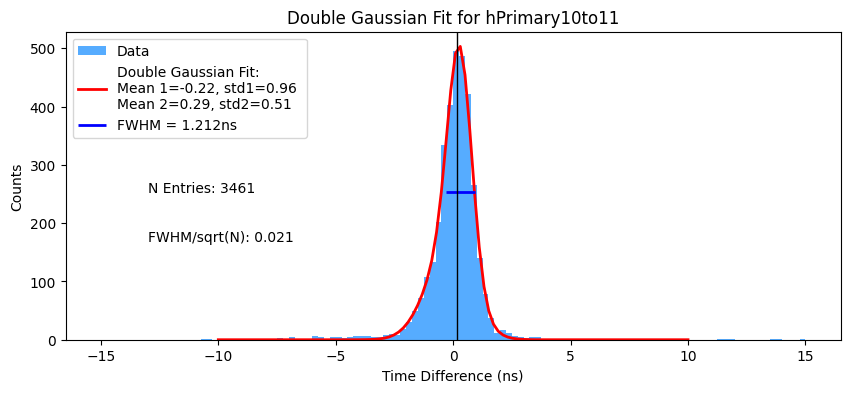

Combined Mean (mean1-2): 0.147
Uncertainty in Combined Mean: 0.017
Chi-Squared/DOF: 165.333
(A1, A2): (348.36701533639257, 485.60068834833226)
[-0.938585218907804, 1.266162379074351, 99.25, 0.061414781092196, 1.266162379074351, 49.625]
Peak of the double Gaussian occurs at x = -1.07 with height = 396.44


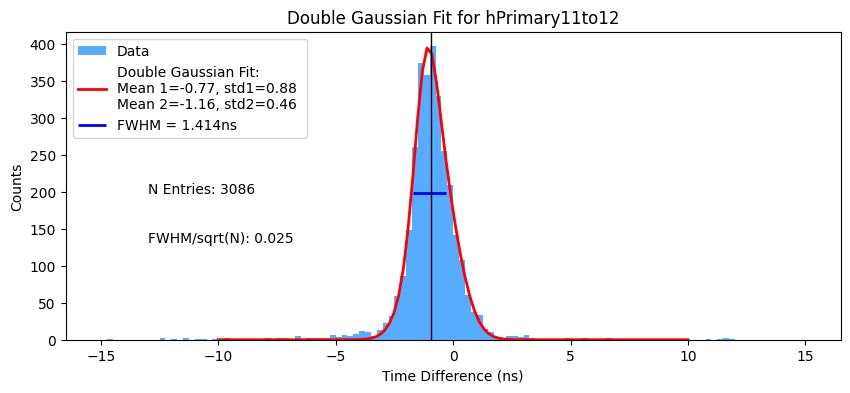

Combined Mean (mean1-2): -0.933
Uncertainty in Combined Mean: 0.020
Chi-Squared/DOF: 95.411
(A1, A2): (539.5160514360466, 196.2412265414336)
[-0.6182847143589175, 1.3475842739042838, 123.5, 0.3817152856410825, 1.3475842739042838, 61.75]
Peak of the double Gaussian occurs at x = -0.41 with height = 510.92


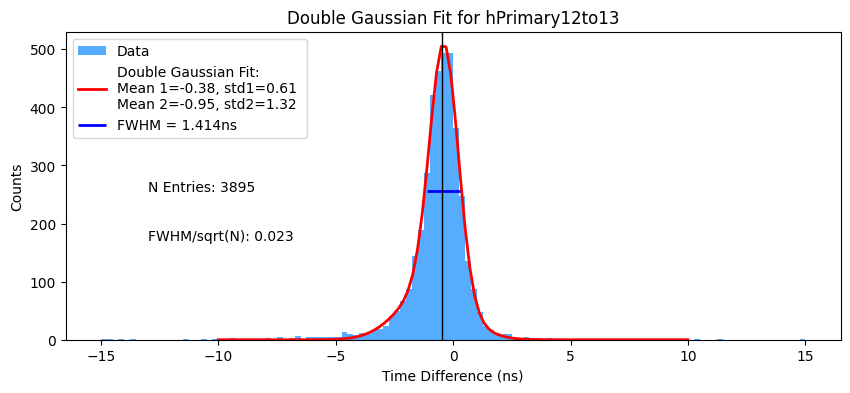

Combined Mean (mean1-2): -0.481
Uncertainty in Combined Mean: 0.018
Chi-Squared/DOF: 146.033
(A1, A2): (651.7229401799717, 293.62149706280525)
[0.1637018992125587, 1.3751084029559157, 184.5, 1.1637018992125587, 1.3751084029559157, 92.25]
Peak of the double Gaussian occurs at x = 0.08 with height = 740.27


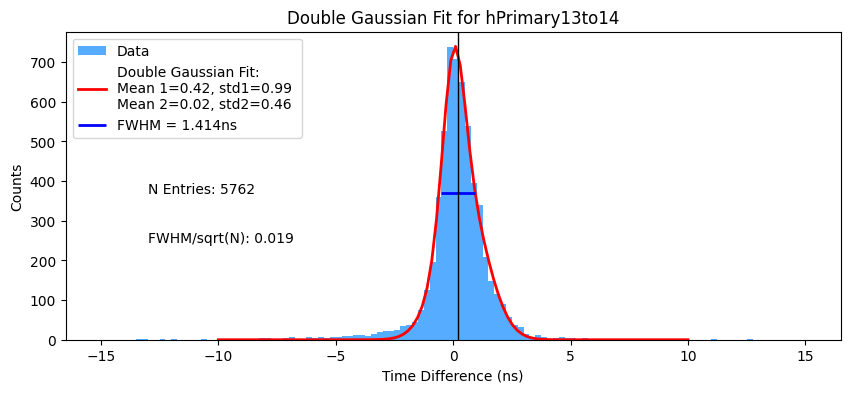

Combined Mean (mean1-2): 0.208
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 188.041
(A1, A2): (904.668259736145, 458.3353778023204)
[0.018662791647851014, 1.2461702258099308, 190.75, 1.018662791647851, 1.2461702258099308, 95.375]
Peak of the double Gaussian occurs at x = 0.17 with height = 791.69


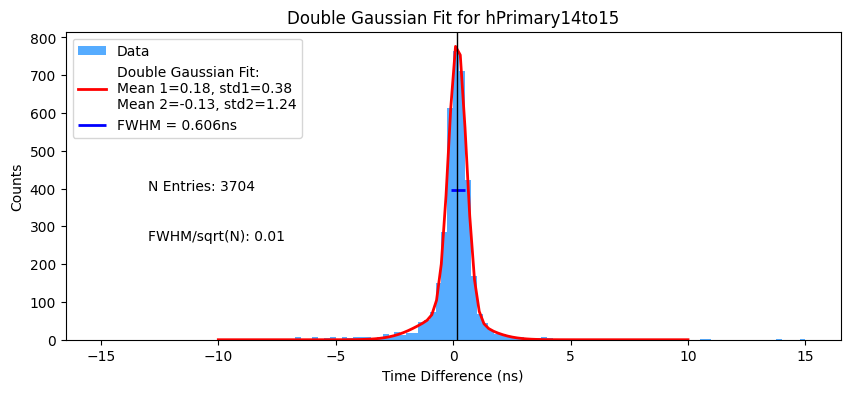

Combined Mean (mean1-2): 0.156
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 37.923
(A1, A2): (683.3089759333302, 210.4313589994283)
[-0.6972571498679936, 1.4307130707032263, 78.0, 0.3027428501320064, 1.4307130707032263, 39.0]
Peak of the double Gaussian occurs at x = -0.44 with height = 312.44


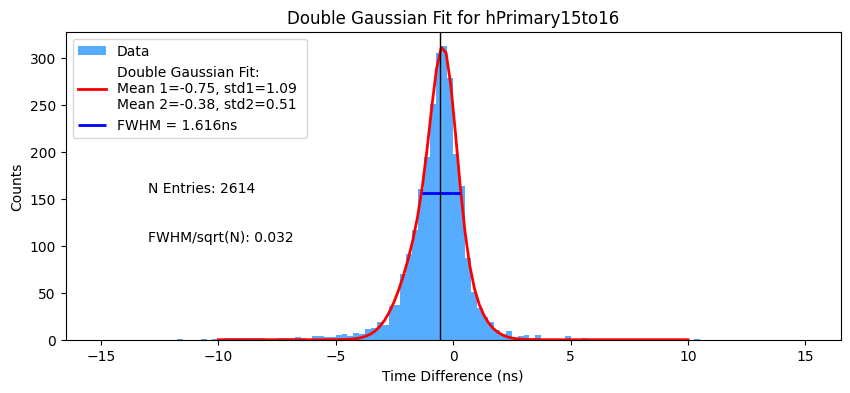

Combined Mean (mean1-2): -0.553
Uncertainty in Combined Mean: 0.022
Chi-Squared/DOF: 65.710
(A1, A2): (406.24839381595325, 219.57076445980928)
[-0.18383030897080616, 1.4937564480405092, 77.25, 0.8161696910291938, 1.4937564480405092, 38.625]
Peak of the double Gaussian occurs at x = -0.32 with height = 311.51


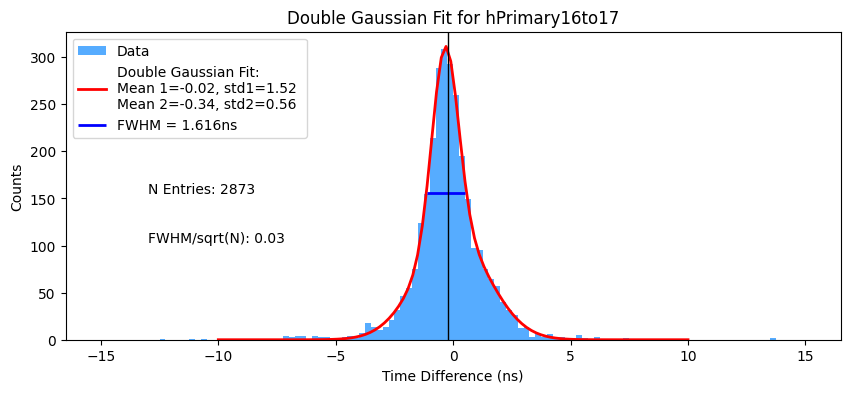

Combined Mean (mean1-2): -0.227
Uncertainty in Combined Mean: 0.023
Chi-Squared/DOF: 46.163
(A1, A2): (420.9128261414474, 283.81384793772054)
[0.16167820579573916, 1.5096290335491471, 177.75, 1.161678205795739, 1.5096290335491471, 88.875]
Peak of the double Gaussian occurs at x = 0.35 with height = 710.71


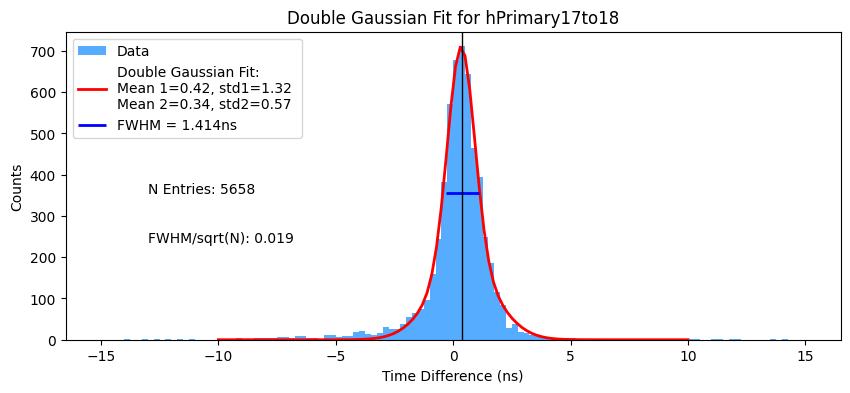

Combined Mean (mean1-2): 0.357
Uncertainty in Combined Mean: 0.015
Chi-Squared/DOF: 5.461
(A1, A2): (596.9900809644425, 760.5270084486289)
[0.1649337073512709, 1.3945253239330868, 241.25, 1.1649337073512709, 1.3945253239330868, 120.625]
Peak of the double Gaussian occurs at x = 0.38 with height = 947.18


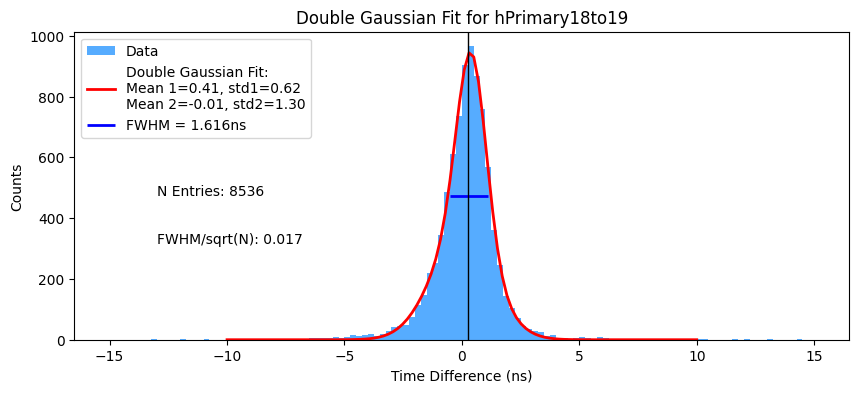

Combined Mean (mean1-2): 0.265
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 241.068
(A1, A2): (981.8523273113786, 1090.9115901388027)
[0.231866365459593, 1.3848878581992785, 156.25, 1.231866365459593, 1.3848878581992785, 78.125]
Peak of the double Gaussian occurs at x = 0.32 with height = 625.14


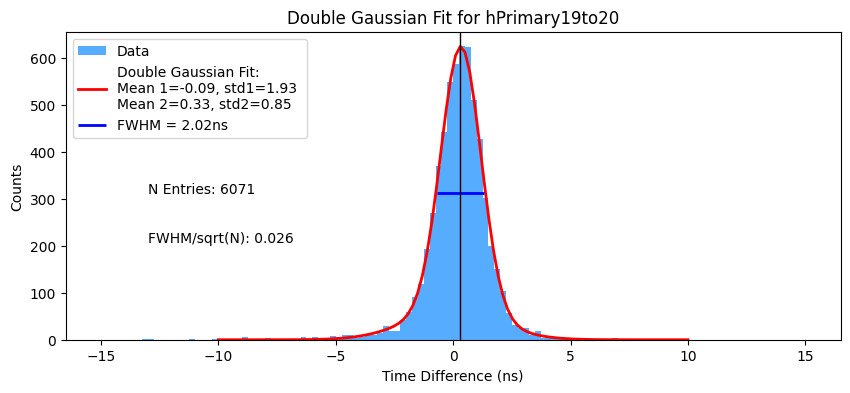

Combined Mean (mean1-2): 0.295
Uncertainty in Combined Mean: 0.016
Chi-Squared/DOF: 59.492
(A1, A2): (287.3164977182454, 1212.1706238396794)
[0.5904366151675752, 1.3359807390836362, 123.25, 1.590436615167575, 1.3359807390836362, 61.625]
Peak of the double Gaussian occurs at x = 0.89 with height = 493.21


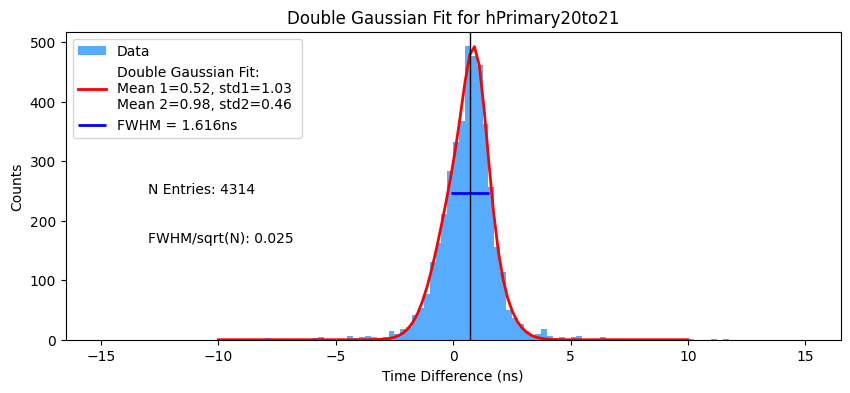

Combined Mean (mean1-2): 0.702
Uncertainty in Combined Mean: 0.018
Chi-Squared/DOF: 165.426
(A1, A2): (805.1822845635237, 236.96122211771254)
[0.3090948548989284, 1.21129584274095, 331.5, 1.3090948548989285, 1.21129584274095, 165.75]
Peak of the double Gaussian occurs at x = 0.47 with height = 1352.73


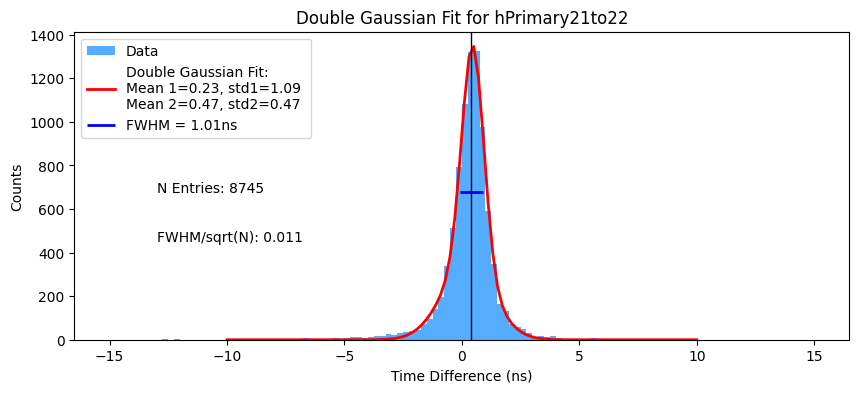

Combined Mean (mean1-2): 0.408
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 91.576
(A1, A2): (905.2137353959224, 1202.501283175215)
[0.20740199434951503, 1.1507810791083246, 314.75, 1.2074019943495151, 1.1507810791083246, 157.375]
Peak of the double Gaussian occurs at x = 0.32 with height = 1234.89


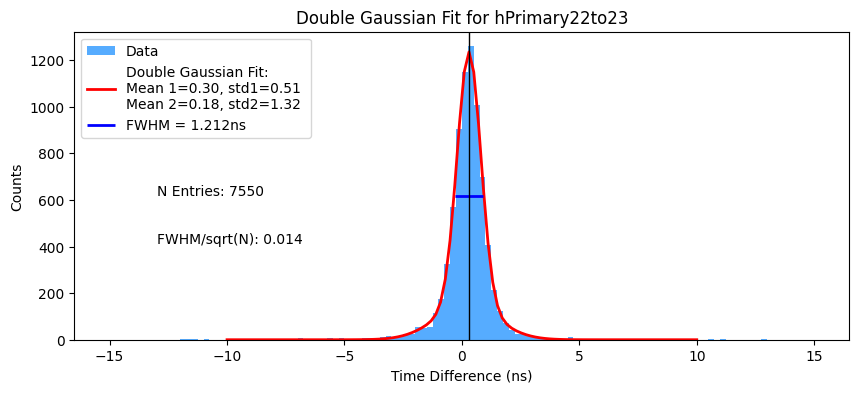

Combined Mean (mean1-2): 0.291
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 12.028
(A1, A2): (1385.3526848744875, 467.0554367414425)
[0.08268466995561445, 1.140658144174308, 338.0, 1.0826846699556145, 1.140658144174308, 169.0]
Peak of the double Gaussian occurs at x = 0.17 with height = 1413.61


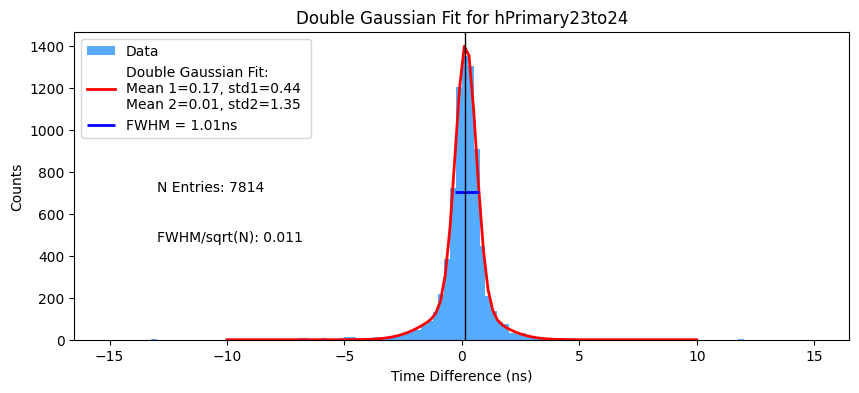

Combined Mean (mean1-2): 0.152
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 21.730
(A1, A2): (1403.5422941606264, 511.3840343461963)
[-0.048900864245543116, 1.1805676646953462, 395.5, 0.9510991357544569, 1.1805676646953462, 197.75]
Peak of the double Gaussian occurs at x = -0.02 with height = 1592.76


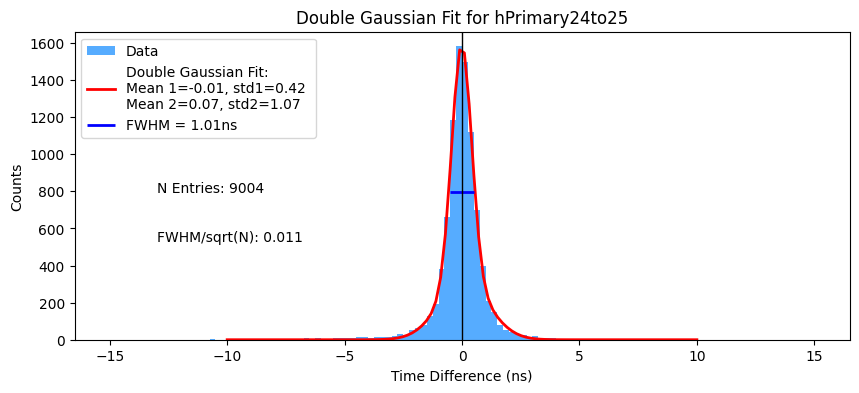

Combined Mean (mean1-2): 0.001
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 10.341
(A1, A2): (1379.4489389326484, 798.8804838919096)
[0.032587598212556676, 1.2645999280502773, 345.5, 1.0325875982125567, 1.2645999280502773, 172.75]
Peak of the double Gaussian occurs at x = 0.17 with height = 1350.15


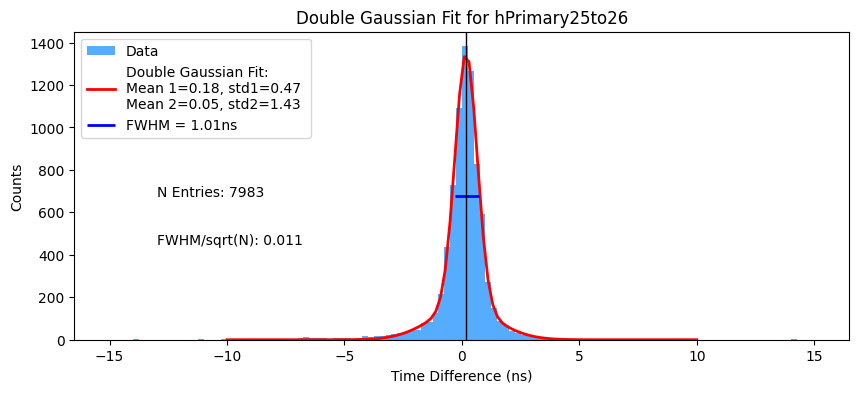

Combined Mean (mean1-2): 0.166
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 14.590
(A1, A2): (1425.1917696531332, 522.5118087678103)
[0.01863064127270477, 1.1993462706689964, 393.5, 1.0186306412727049, 1.1993462706689964, 196.75]
Peak of the double Gaussian occurs at x = 0.08 with height = 1579.16


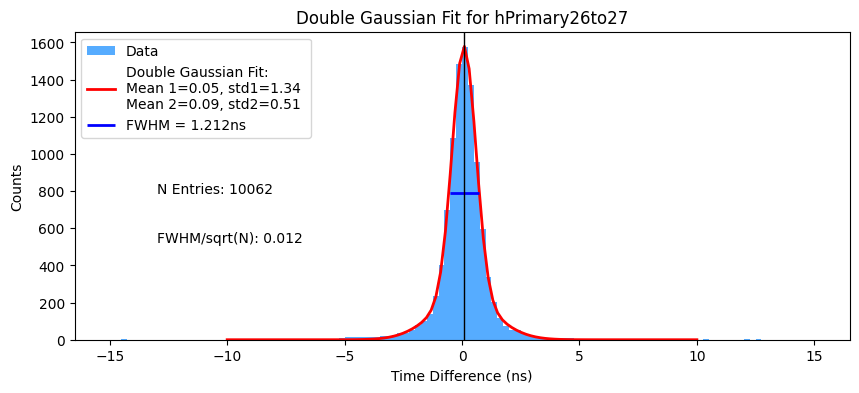

Combined Mean (mean1-2): 0.082
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 1.895
(A1, A2): (727.925982909263, 1732.477138664201)
[0.24949973090806132, 1.4388823204992969, 225.25, 1.2494997309080613, 1.4388823204992969, 112.625]
Peak of the double Gaussian occurs at x = 0.44 with height = 874.79


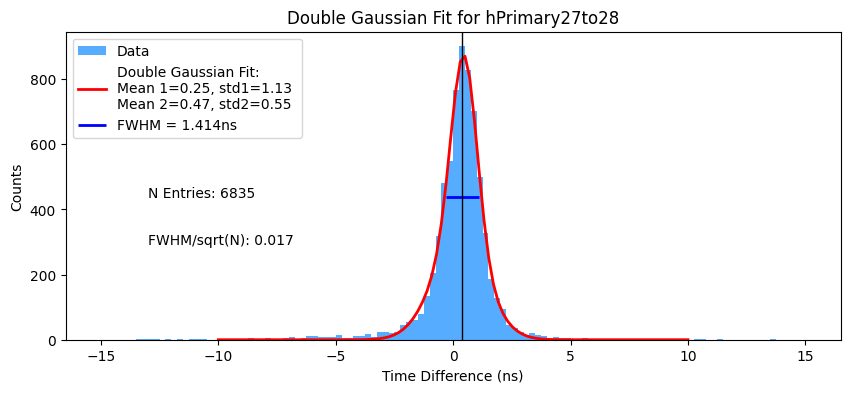

Combined Mean (mean1-2): 0.396
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 54.797
(A1, A2): (822.2086018086206, 813.8105432124411)
[0.3476592639320697, 1.2714007944317263, 314.25, 1.3476592639320697, 1.2714007944317263, 157.125]
Peak of the double Gaussian occurs at x = 0.47 with height = 1250.51


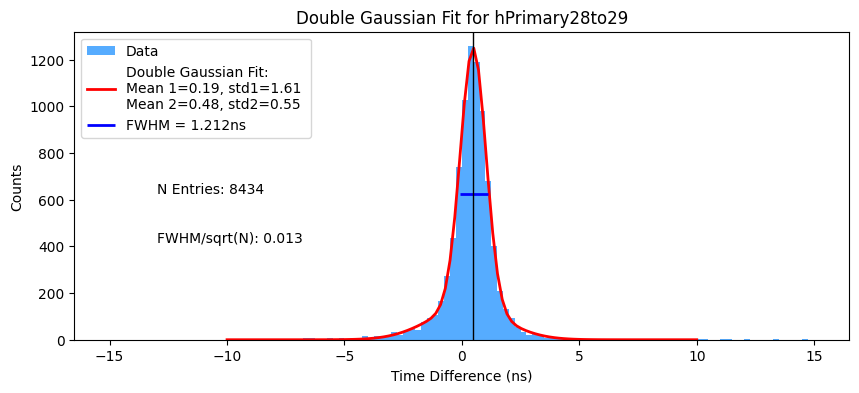

Combined Mean (mean1-2): 0.451
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 64.327
(A1, A2): (545.0296935654104, 1528.831802882231)
[-0.19518496644471714, 0.8890863529880725, 253.5, 0.8048150335552828, 0.8890863529880725, 126.75]
Peak of the double Gaussian occurs at x = -0.11 with height = 1016.24


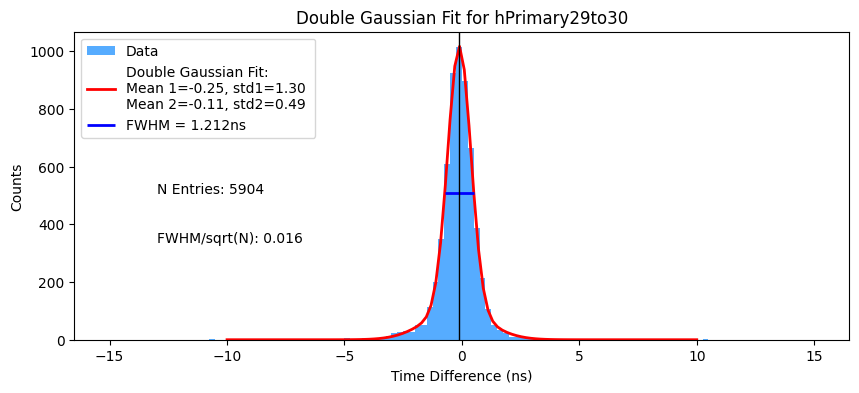

Combined Mean (mean1-2): -0.121
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 11.518
(A1, A2): (331.78471913195716, 1133.1115401127931)
[0.7558917295284953, 1.1461076916844368, 33.25, 1.7558917295284953, 1.1461076916844368, 16.625]
Peak of the double Gaussian occurs at x = 0.83 with height = 217.74


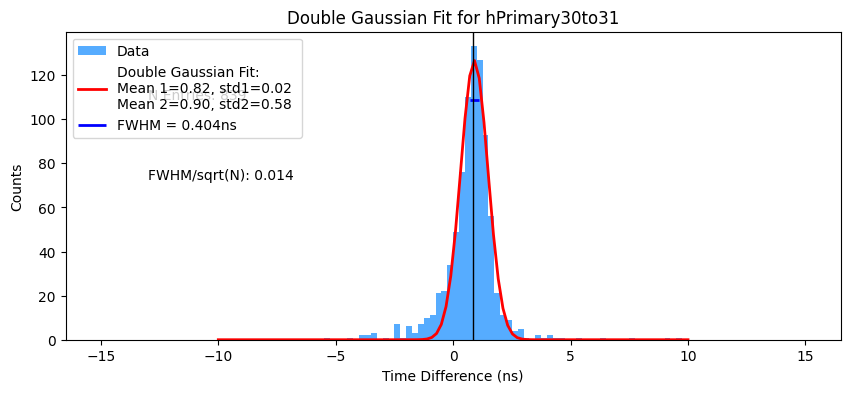

Combined Mean (mean1-2): 0.865
Uncertainty in Combined Mean: 0.027
Chi-Squared/DOF: 2.445
(A1, A2): (6.10804878777692, 184.96311144882333)
[0.8401397715048569, 1.205819925703061, 335.0, 1.8401397715048569, 1.205819925703061, 167.5]
Peak of the double Gaussian occurs at x = 0.92 with height = 1334.76


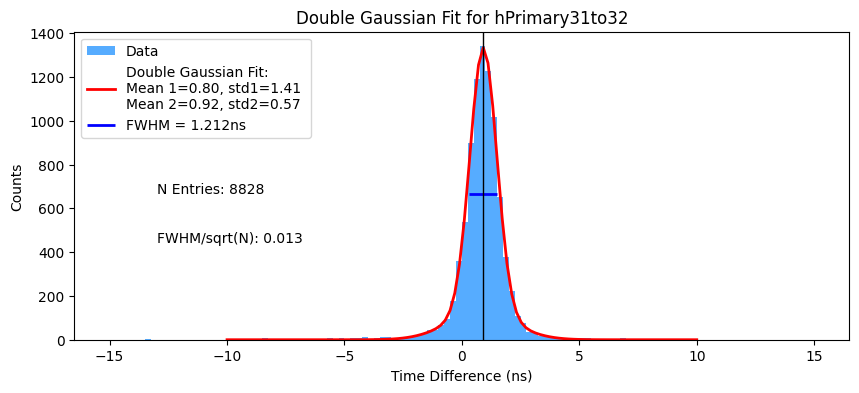

Combined Mean (mean1-2): 0.906
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 10.259
(A1, A2): (425.7599970837564, 1738.2496817341519)
[0.8332716997444736, 1.3127532155229376, 294.75, 1.8332716997444736, 1.3127532155229376, 147.375]
Peak of the double Gaussian occurs at x = 0.92 with height = 1174.45


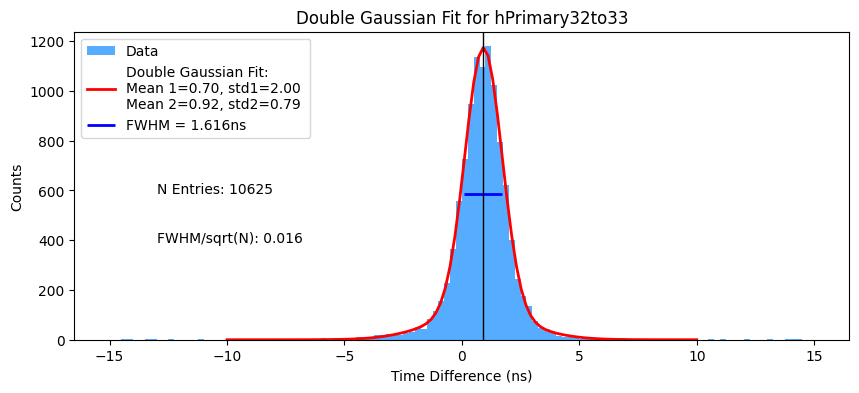

Combined Mean (mean1-2): 0.902
Uncertainty in Combined Mean: 0.012
Chi-Squared/DOF: 30.237
(A1, A2): (517.5763174374902, 2118.0236262417716)
[0.6461852219637134, 1.4233410621404692, 252.75, 1.6461852219637134, 1.4233410621404692, 126.375]
Peak of the double Gaussian occurs at x = 0.80 with height = 1028.51


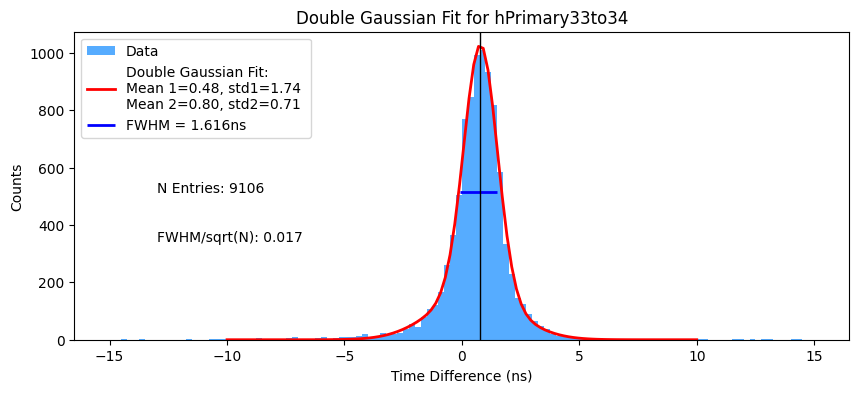

Combined Mean (mean1-2): 0.749
Uncertainty in Combined Mean: 0.012
Chi-Squared/DOF: 85.096
(A1, A2): (691.7975061905003, 1549.3796729082774)
[0.5018101234705619, 1.258330707466142, 445.0, 1.5018101234705619, 1.258330707466142, 222.5]
Peak of the double Gaussian occurs at x = 0.68 with height = 1802.45


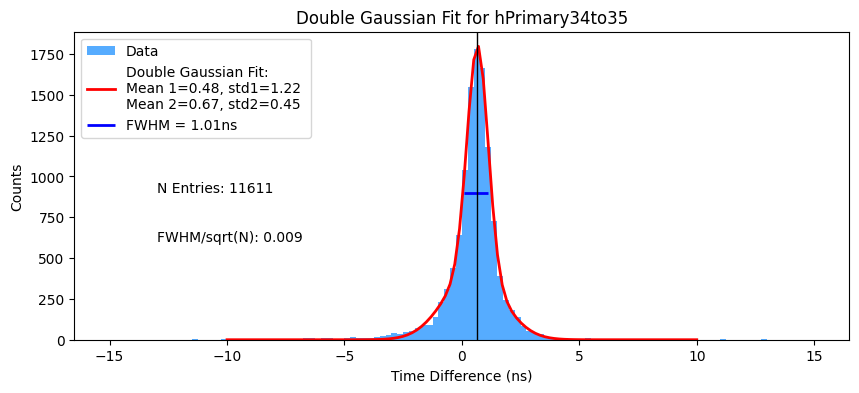

Combined Mean (mean1-2): 0.628
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 71.470
(A1, A2): (1262.838025553916, 1557.5177470587469)
[-0.13224269415850537, 1.3575632526983423, 330.5, 0.8677573058414947, 1.3575632526983423, 165.25]
Peak of the double Gaussian occurs at x = -0.02 with height = 1330.10


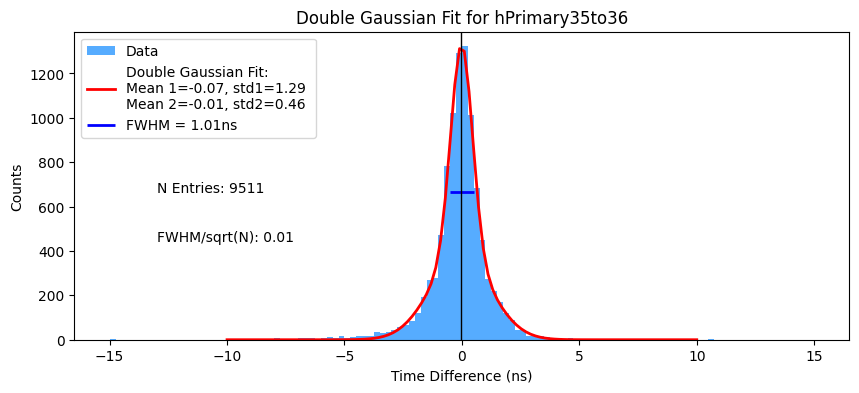

Combined Mean (mean1-2): -0.027
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 5.995
(A1, A2): (1205.0404188442826, 1109.7437754568223)
[-0.11977469407271411, 1.3146299055872712, 537.0, 0.8802253059272859, 1.3146299055872712, 268.5]
Peak of the double Gaussian occurs at x = 0.02 with height = 2131.76


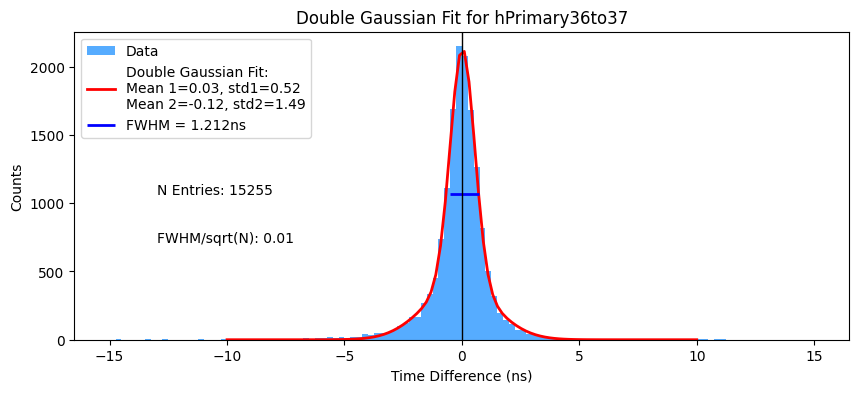

Combined Mean (mean1-2): -0.001
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 43.006
(A1, A2): (2270.8856745265048, 1472.9210615964278)
[0.039774090971032024, 1.2771594054025976, 383.75, 1.039774090971032, 1.2771594054025976, 191.875]
Peak of the double Gaussian occurs at x = 0.17 with height = 1500.97


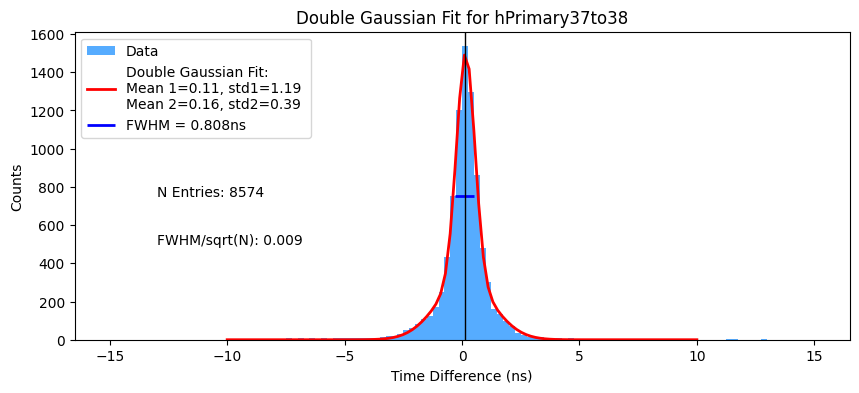

Combined Mean (mean1-2): 0.147
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 3.269
(A1, A2): (910.3044702741208, 1173.6656008826621)
[-0.4465313992801601, 1.4124522938584783, 394.5, 0.5534686007198399, 1.4124522938584783, 197.25]
Peak of the double Gaussian occurs at x = -0.20 with height = 1628.27


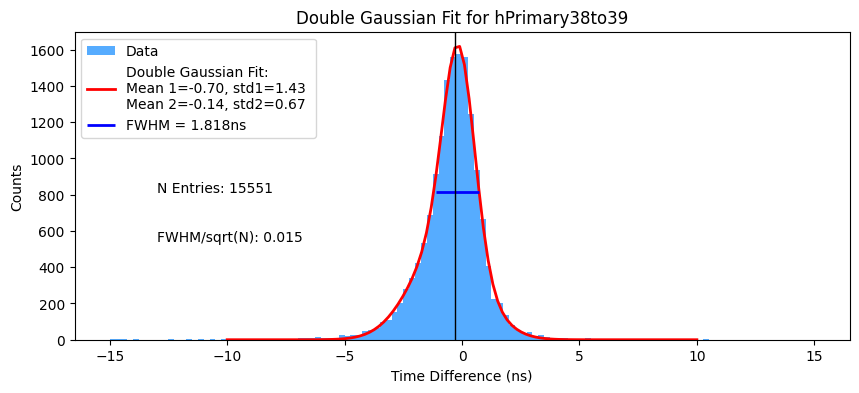

Combined Mean (mean1-2): -0.318
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 722.523
(A1, A2): (1911.6377365482424, 1900.3203181206045)
[-0.12145144488831901, 1.5601698085238815, 193.25, 0.878548555111681, 1.5601698085238815, 96.625]
Peak of the double Gaussian occurs at x = -0.41 with height = 772.64


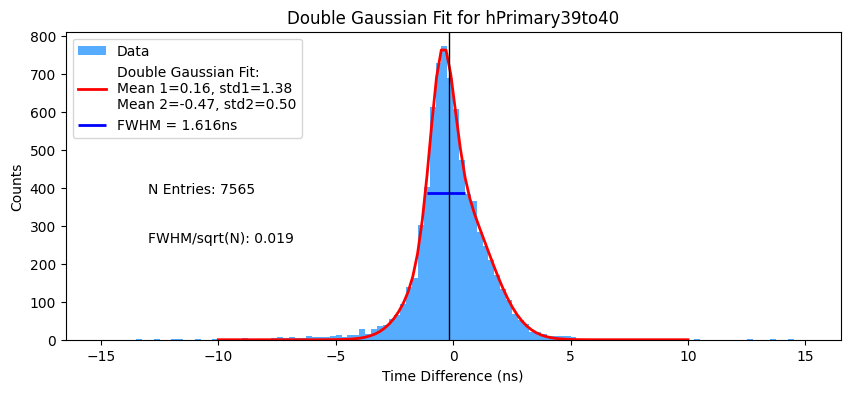

Combined Mean (mean1-2): -0.176
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 495.019
(A1, A2): (1286.1999989666006, 546.329809250723)
[-0.05708649330676114, 1.1165587887957935, 675.75, 0.9429135066932388, 1.1165587887957935, 337.875]
Peak of the double Gaussian occurs at x = 0.08 with height = 2728.05


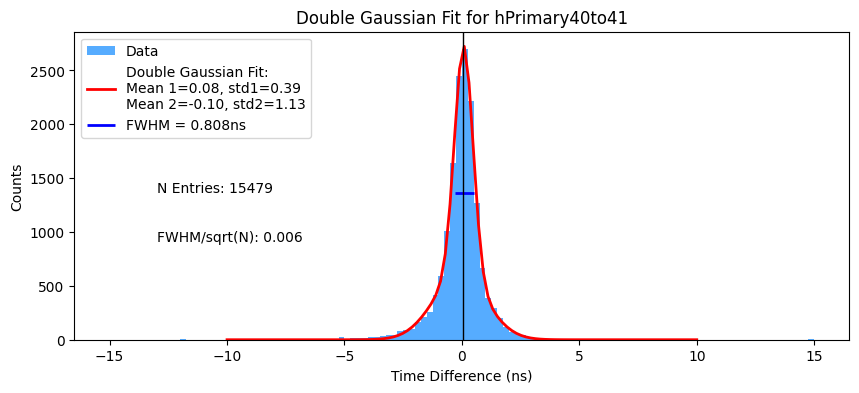

Combined Mean (mean1-2): 0.044
Uncertainty in Combined Mean: 0.008
Chi-Squared/DOF: 91.724
(A1, A2): (2123.0726068367326, 1660.6596988960678)
[-0.20754381062347838, 1.2555308326638135, 591.75, 0.7924561893765216, 1.2555308326638135, 295.875]
Peak of the double Gaussian occurs at x = -0.11 with height = 2403.44


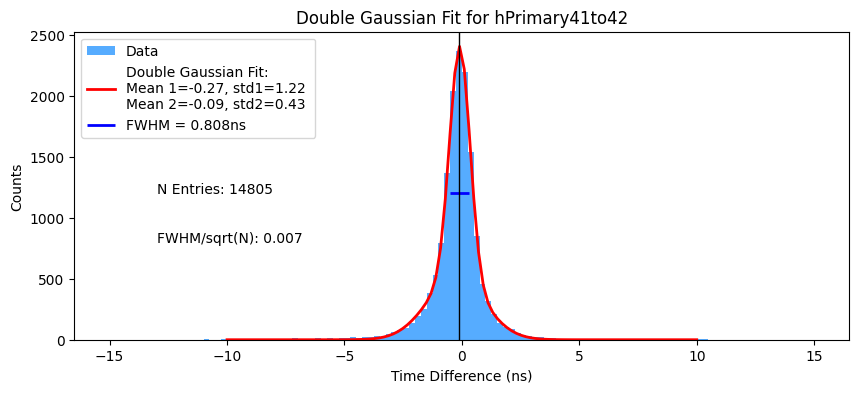

Combined Mean (mean1-2): -0.125
Uncertainty in Combined Mean: 0.008
Chi-Squared/DOF: 86.647
(A1, A2): (1518.2165154083684, 2083.43995565505)
[-0.19862040704308034, 1.2736183865280717, 490.5, 0.8013795929569196, 1.2736183865280717, 245.25]
Peak of the double Gaussian occurs at x = -0.14 with height = 2003.03


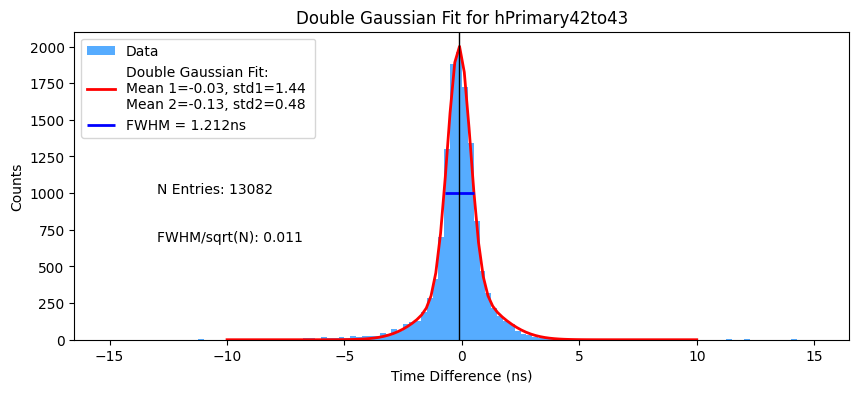

Combined Mean (mean1-2): -0.111
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 17.664
(A1, A2): (1159.6959778639985, 2043.252830170418)
[-0.14441686618126096, 1.331347027592212, 356.5, 0.8555831338187391, 1.331347027592212, 178.25]
Peak of the double Gaussian occurs at x = -0.02 with height = 1440.24


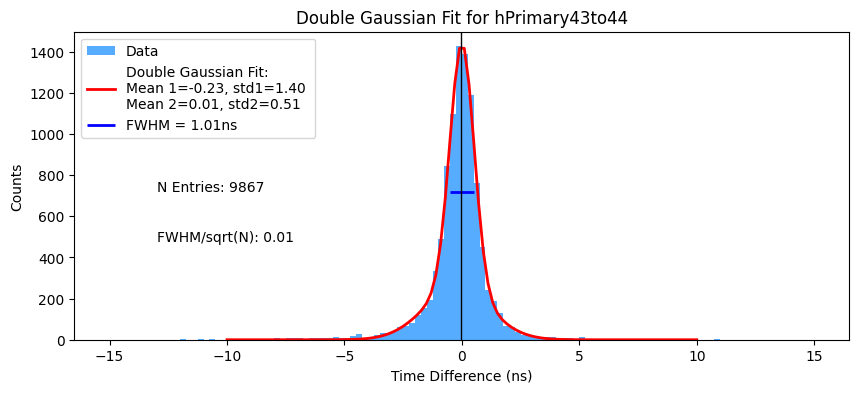

Combined Mean (mean1-2): -0.034
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 70.424
(A1, A2): (860.3970417558011, 1544.1402721836341)
[0.23065887042790725, 1.5043335418222705, 284.75, 1.2306588704279073, 1.5043335418222705, 142.375]
Peak of the double Gaussian occurs at x = 0.26 with height = 1130.92


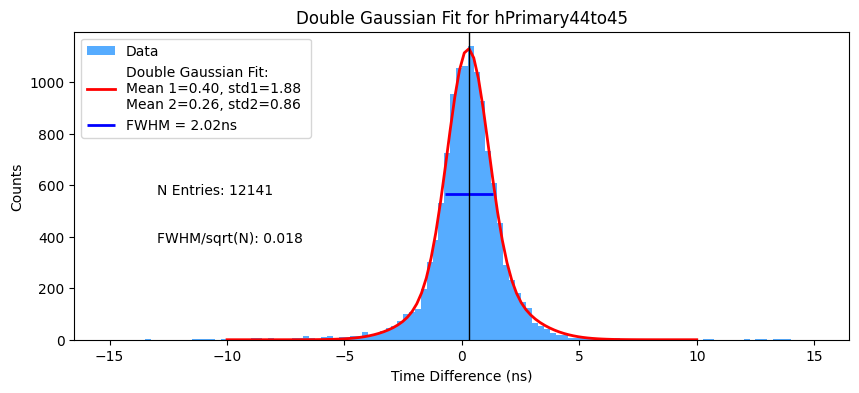

Combined Mean (mean1-2): 0.286
Uncertainty in Combined Mean: 0.012
Chi-Squared/DOF: 21.933
(A1, A2): (1036.1036222103708, 1964.7563385777387)
[0.4739584171864878, 1.614557346939602, 233.75, 1.4739584171864877, 1.614557346939602, 116.875]
Double Gaussian fit failed, trying single


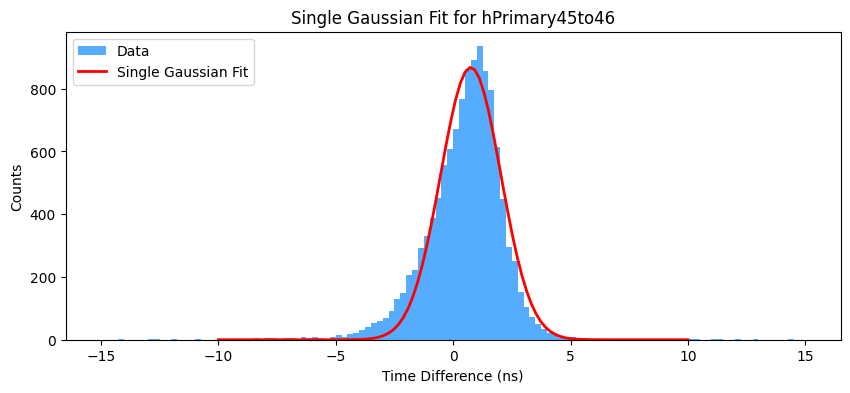

Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06
[-0.07555703477436637, 1.3463979668458437, 448.5, 0.9244429652256336, 1.3463979668458437, 224.25]
Peak of the double Gaussian occurs at x = 0.05 with height = 1846.00


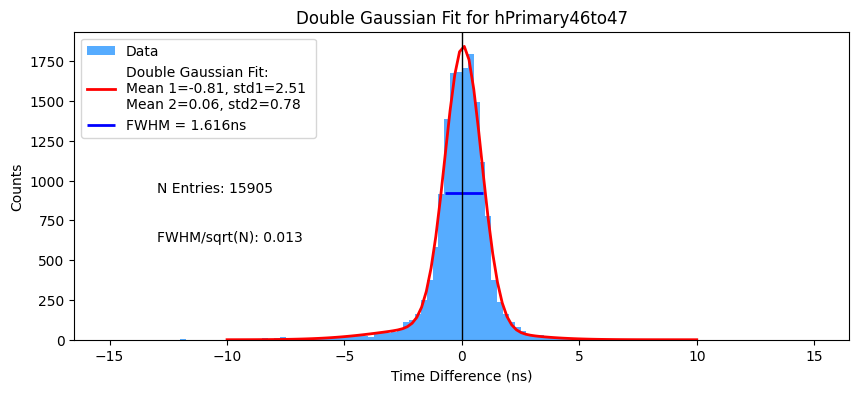

Combined Mean (mean1-2): 0.024
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 356.136
(A1, A2): (494.95931192225913, 3456.6144343207275)
[0.6058467636092032, 1.3969968068630922, 315.75, 1.605846763609203, 1.3969968068630922, 157.875]
Peak of the double Gaussian occurs at x = 0.77 with height = 1276.66


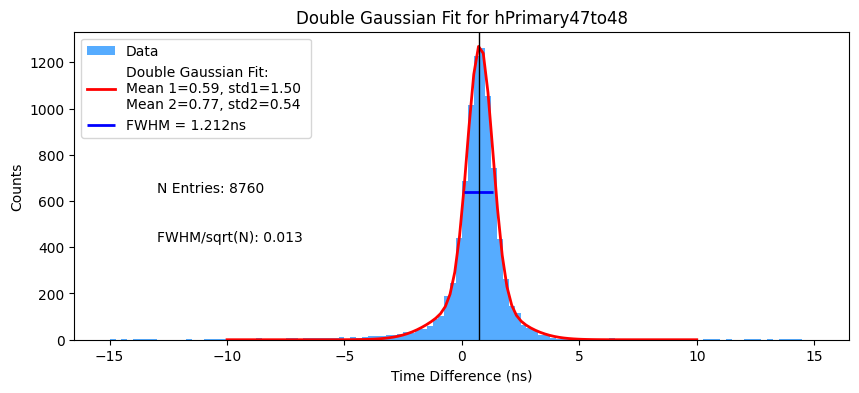

Combined Mean (mean1-2): 0.748
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 32.942
(A1, A2): (648.0725966524026, 1486.3614035628898)
[0.6094750882776012, 1.1110212581770595, 918.75, 1.6094750882776012, 1.1110212581770595, 459.375]
Peak of the double Gaussian occurs at x = 0.65 with height = 3721.52


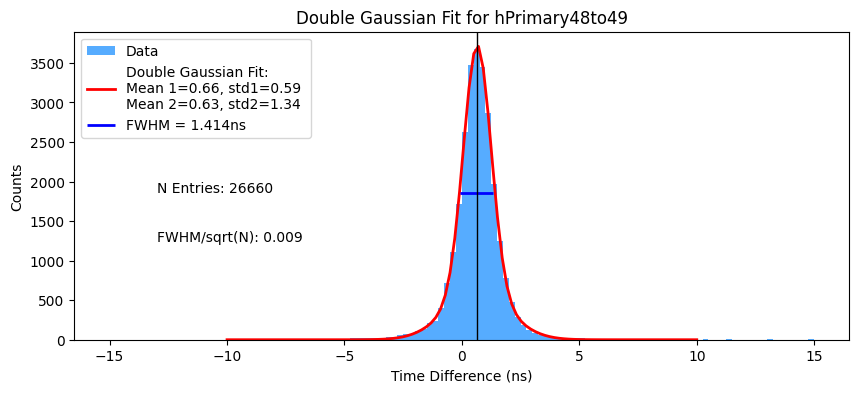

Combined Mean (mean1-2): 0.653
Uncertainty in Combined Mean: 0.007
Chi-Squared/DOF: 1.525
(A1, A2): (4629.4700728057605, 1942.8567867673564)
[0.33125502047866695, 1.283142690170285, 590.5, 1.3312550204786668, 1.283142690170285, 295.25]
Peak of the double Gaussian occurs at x = 0.50 with height = 2425.37


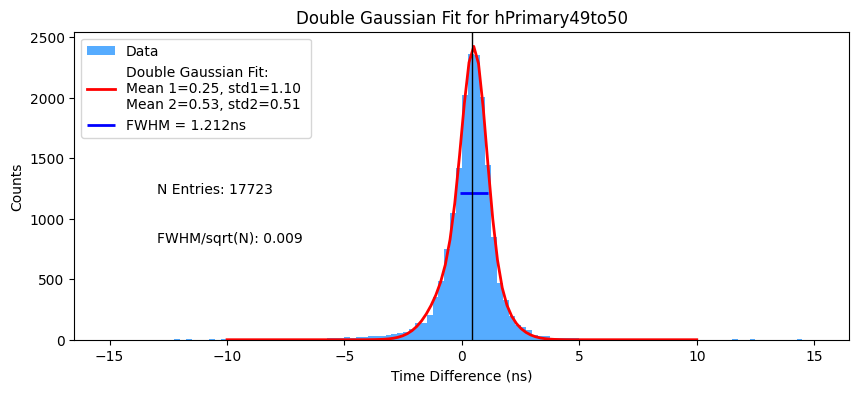

Combined Mean (mean1-2): 0.440
Uncertainty in Combined Mean: 0.008
Chi-Squared/DOF: 258.445
(A1, A2): (2122.914904087761, 2155.112989861957)
[-0.16597147693566422, 1.488966848853697, 524.5, 0.8340285230643358, 1.488966848853697, 262.25]
Peak of the double Gaussian occurs at x = -0.14 with height = 2104.03


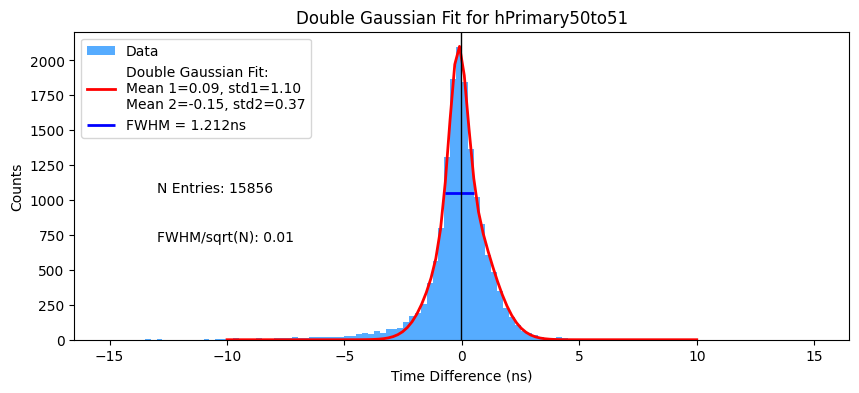

Combined Mean (mean1-2): -0.041
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 183.760
(A1, A2): (2690.4634170426043, 1071.0584953390687)
[-0.2245247817840086, 1.311740679400415, 432.75, 0.7754752182159914, 1.311740679400415, 216.375]
Peak of the double Gaussian occurs at x = -0.26 with height = 1734.14


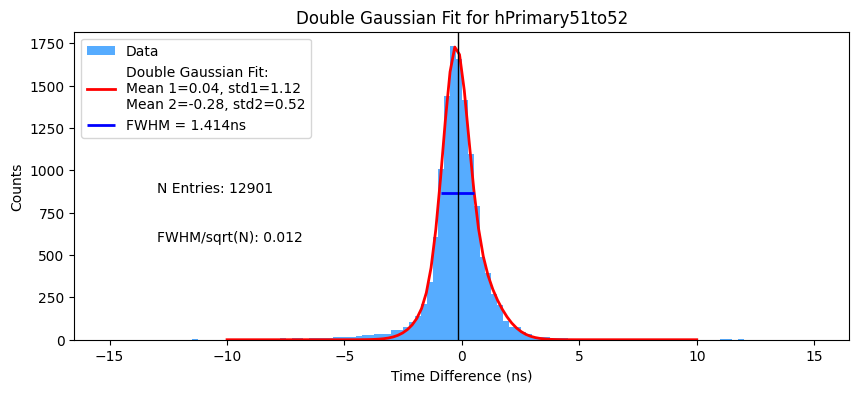

Combined Mean (mean1-2): -0.177
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 241.990
(A1, A2): (1532.0420422961326, 1571.0070912232798)
[0.01428181358196339, 1.2327700597391862, 418.0, 1.0142818135819633, 1.2327700597391862, 209.0]
Peak of the double Gaussian occurs at x = -0.02 with height = 6456.94


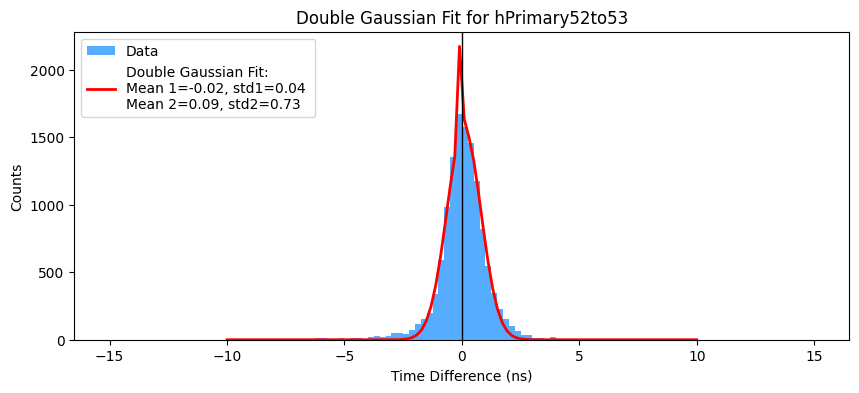

Combined Mean (mean1-2): 0.006
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 81.256
(A1, A2): (503.9213788417671, 2858.7333483027282)
[-0.0402682072300859, 1.4911066286260026, 224.25, 0.959731792769914, 1.4911066286260026, 112.125]
Peak of the double Gaussian occurs at x = 0.08 with height = 892.48


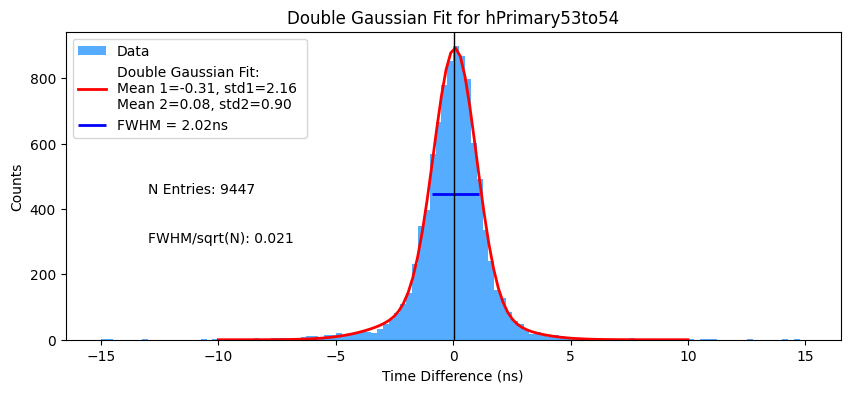

Combined Mean (mean1-2): 0.039
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 83.373
(A1, A2): (536.0600799474505, 1801.815640771888)
[0.6131794679242697, 1.5620415655639157, 186.75, 1.6131794679242697, 1.5620415655639157, 93.375]
Peak of the double Gaussian occurs at x = 0.77 with height = 756.57


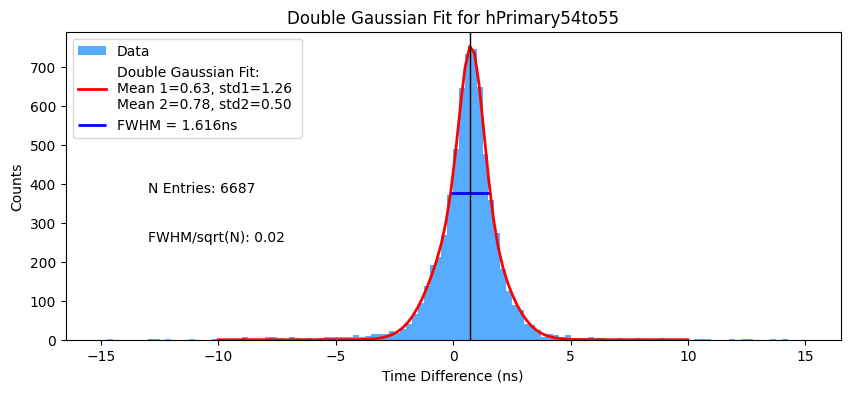

Combined Mean (mean1-2): 0.712
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 24.349
(A1, A2): (1104.9473498956354, 510.0061146136078)
[0.4965872668773689, 1.268682351107743, 373.5, 1.496587266877369, 1.268682351107743, 186.75]
Peak of the double Gaussian occurs at x = 0.56 with height = 1514.14


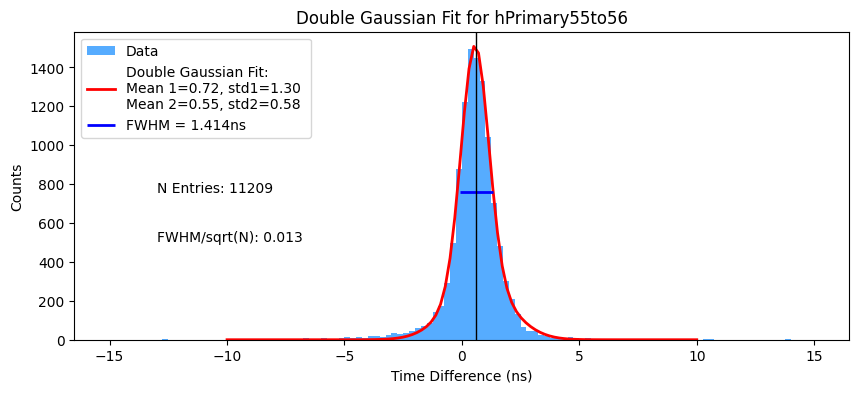

Combined Mean (mean1-2): 0.584
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 40.340
(A1, A2): (920.1848641627712, 1806.2461687980258)
[-0.31578674285257047, 1.7855792628435607, 33.25, 0.6842132571474295, 1.7855792628435607, 16.625]
Peak of the double Gaussian occurs at x = 0.14 with height = 127.73


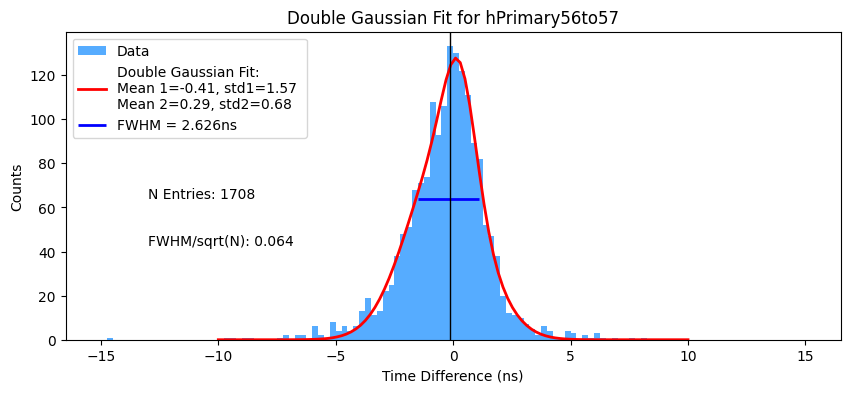

Combined Mean (mean1-2): -0.146
Uncertainty in Combined Mean: 0.034
Chi-Squared/DOF: 95.886
(A1, A2): (326.2492687132955, 86.76517715951891)
[-0.7947981329892783, 1.9026763205001336, 23.25, 0.20520186701072174, 1.9026763205001336, 11.625]
Peak of the double Gaussian occurs at x = -0.80 with height = 89.30


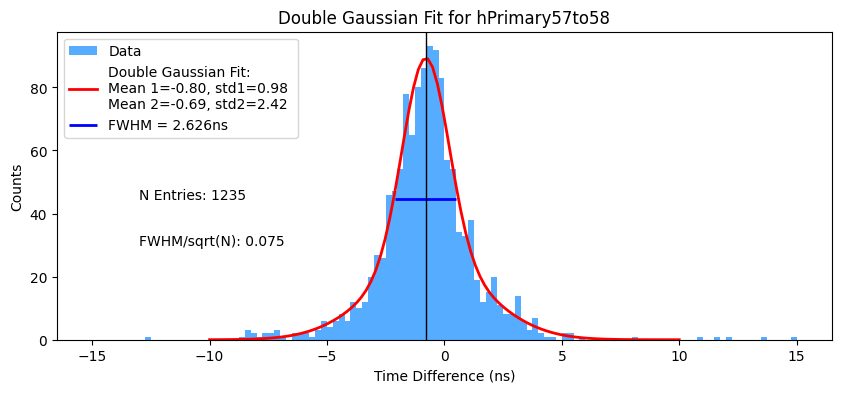

Combined Mean (mean1-2): -0.767
Uncertainty in Combined Mean: 0.042
Chi-Squared/DOF: 1.274
(A1, A2): (159.47643747682085, 147.70849607285624)
[0.19941323701448058, 1.1496153604634167, 594.25, 1.1994132370144805, 1.1496153604634167, 297.125]
Peak of the double Gaussian occurs at x = 0.29 with height = 2404.37


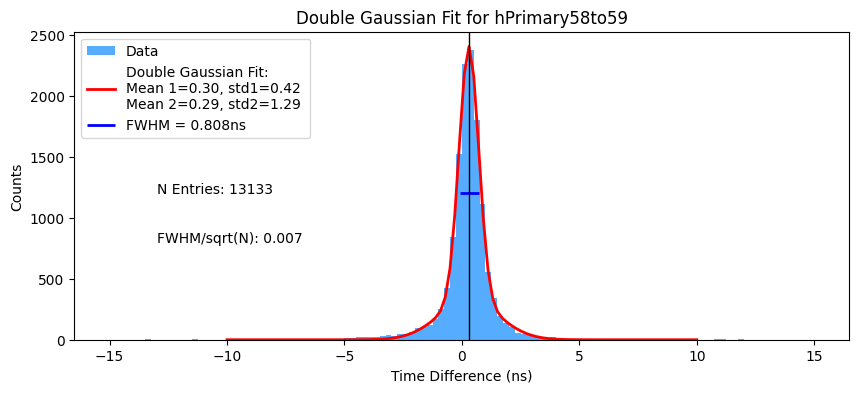

Combined Mean (mean1-2): 0.297
Uncertainty in Combined Mean: 0.008
Chi-Squared/DOF: 0.179
(A1, A2): (2181.425464703261, 1024.8849766722117)
[0.3406787477623248, 1.2988887254109223, 295.5, 1.3406787477623248, 1.2988887254109223, 147.75]
Peak of the double Gaussian occurs at x = 0.53 with height = 1215.47


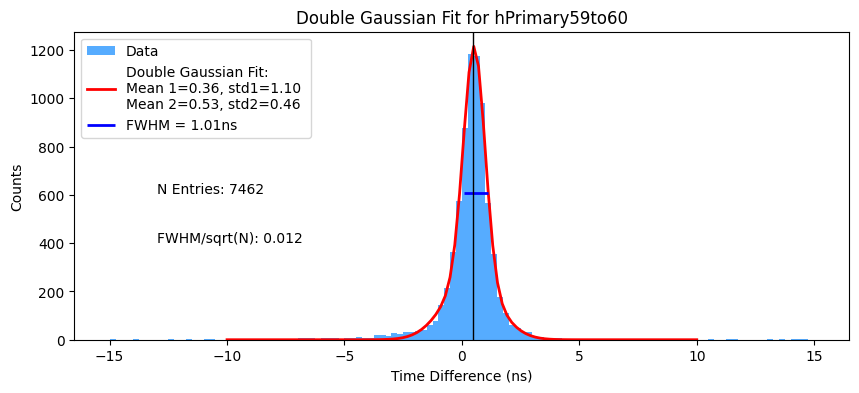

Combined Mean (mean1-2): 0.492
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 35.092
(A1, A2): (693.488584542145, 1103.7429800786076)
[0.09383120376808511, 1.3143263508843435, 239.5, 1.093831203768085, 1.3143263508843435, 119.75]
Peak of the double Gaussian occurs at x = 0.23 with height = 971.72


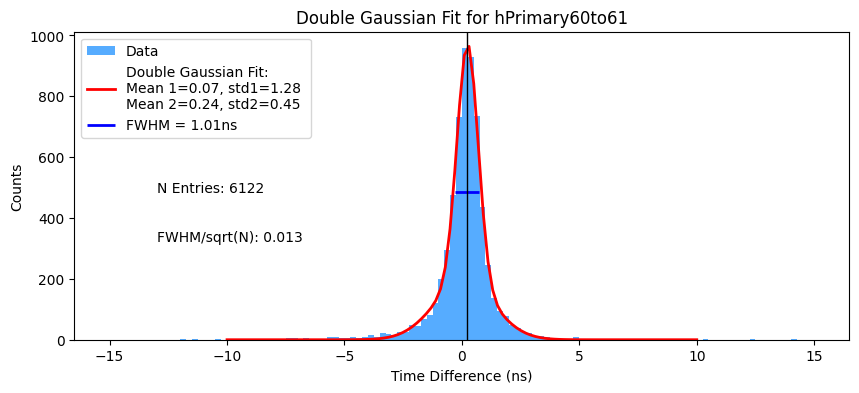

Combined Mean (mean1-2): 0.212
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 27.164
(A1, A2): (592.463707831078, 890.6973816695579)
[-0.004383232786061057, 1.147163150972361, 470.75, 0.995616767213939, 1.147163150972361, 235.375]
Peak of the double Gaussian occurs at x = 0.08 with height = 1873.43


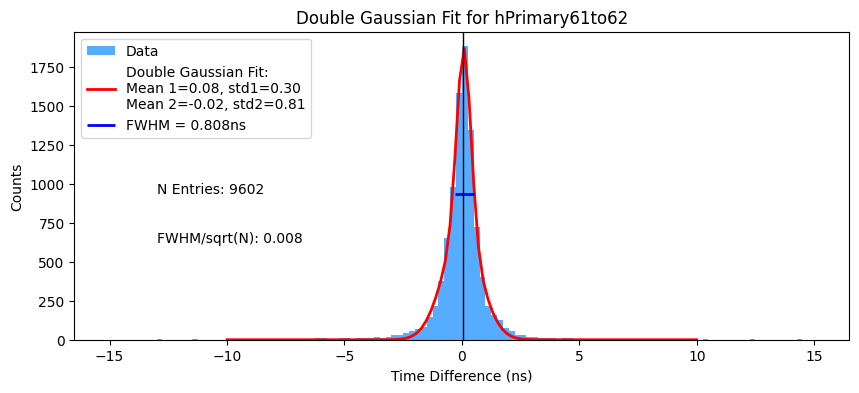

Combined Mean (mean1-2): 0.049
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 28.063
(A1, A2): (906.3303133052993, 1368.7150825663214)
[0.10277851793826, 1.2201433525706624, 394.0, 1.10277851793826, 1.2201433525706624, 197.0]
Peak of the double Gaussian occurs at x = 0.20 with height = 1597.30


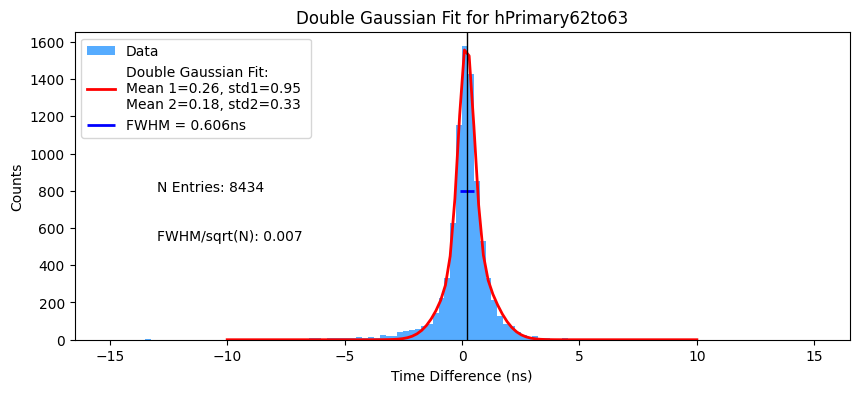

Combined Mean (mean1-2): 0.206
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 13.223
(A1, A2): (1058.3731371545346, 951.7861874090169)
[-0.06753282912626797, 1.1979883713582486, 244.5, 0.932467170873732, 1.1979883713582486, 122.25]
Peak of the double Gaussian occurs at x = 0.05 with height = 991.48


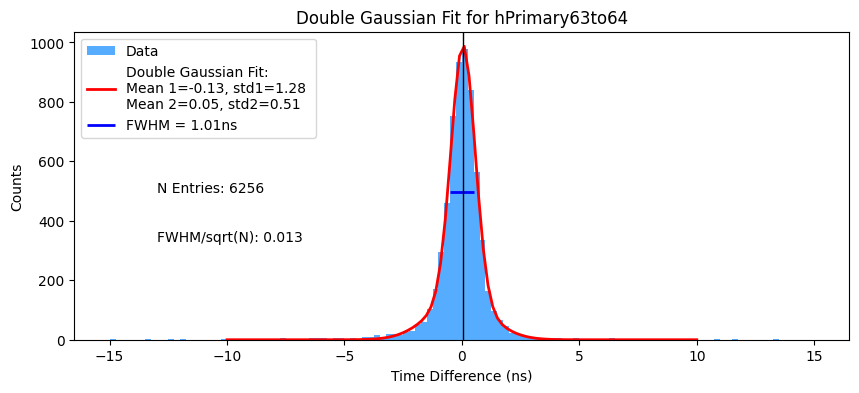

Combined Mean (mean1-2): 0.028
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 23.105
(A1, A2): (426.6338017897783, 1100.5775991556259)
[-0.7595306475727742, 1.2163641860061325, 467.75, 0.24046935242722578, 1.2163641860061325, 233.875]
Peak of the double Gaussian occurs at x = -0.83 with height = 1876.44


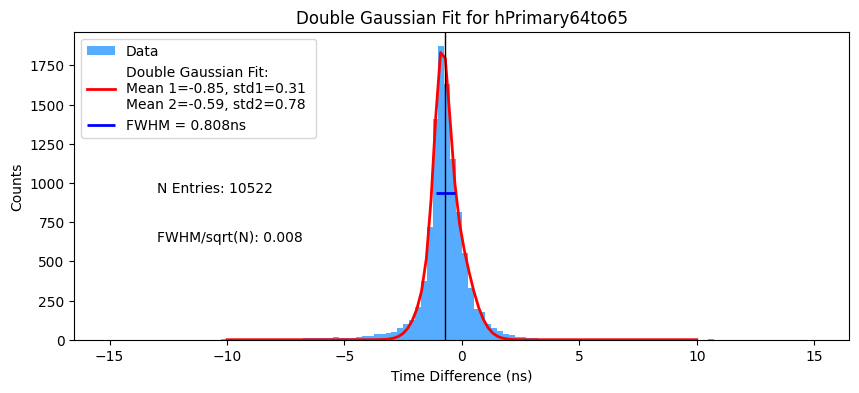

Combined Mean (mean1-2): -0.737
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 207.563
(A1, A2): (840.5847621689267, 1623.747554867442)
[-0.3464002029505064, 1.3937566825473595, 224.5, 0.6535997970494936, 1.3937566825473595, 112.25]
Peak of the double Gaussian occurs at x = -0.38 with height = 913.84


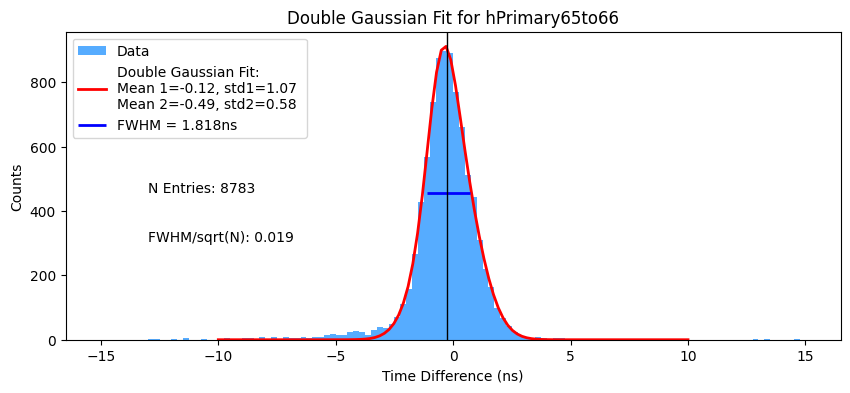

Combined Mean (mean1-2): -0.252
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 184.349
(A1, A2): (1639.576713313402, 473.1534288807972)
[-0.20151714719591546, 1.4717481527457228, 170.0, 0.7984828528040846, 1.4717481527457228, 85.0]
Peak of the double Gaussian occurs at x = 0.38 with height = 683.86


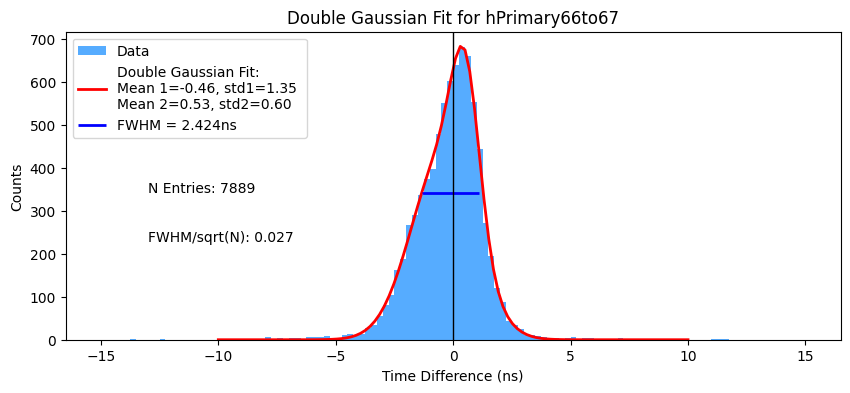

Combined Mean (mean1-2): -0.008
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 1186.969
(A1, A2): (1416.0488216573776, 526.1366751361993)
[-0.4649824942884354, 1.371771183446242, 148.25, 0.5350175057115646, 1.371771183446242, 74.125]
Peak of the double Gaussian occurs at x = -0.38 with height = 588.11


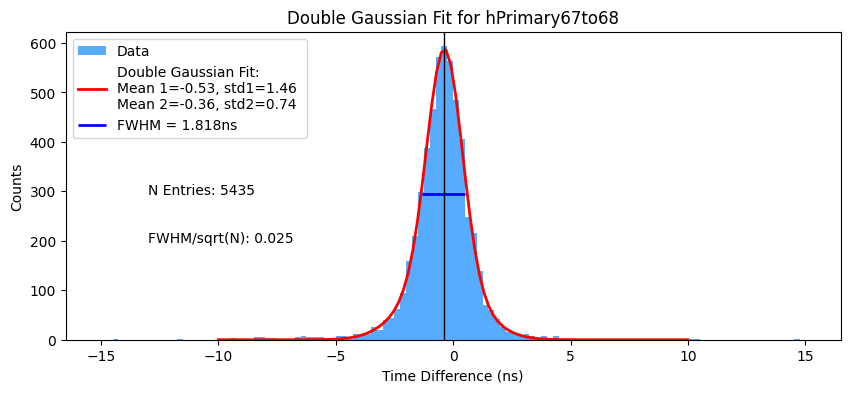

Combined Mean (mean1-2): -0.399
Uncertainty in Combined Mean: 0.016
Chi-Squared/DOF: 17.936
(A1, A2): (477.37498675122845, 854.4417271632307)
[-1.303280136137893, 1.1309080616275784, 242.75, -0.30328013613789295, 1.1309080616275784, 121.375]
Peak of the double Gaussian occurs at x = -1.25 with height = 989.40


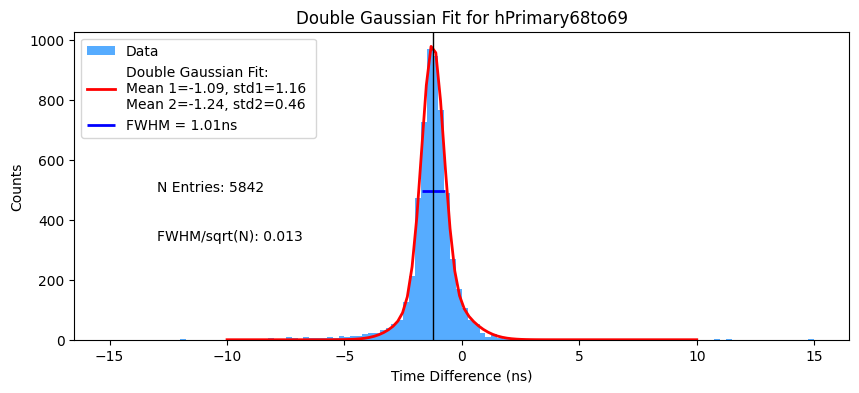

Combined Mean (mean1-2): -1.220
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 18.329
(A1, A2): (447.43347493114106, 972.8065804328883)
[-1.0641315033466159, 1.2217940171757464, 186.75, -0.06413150334661588, 1.2217940171757464, 93.375]
Peak of the double Gaussian occurs at x = -1.01 with height = 750.00


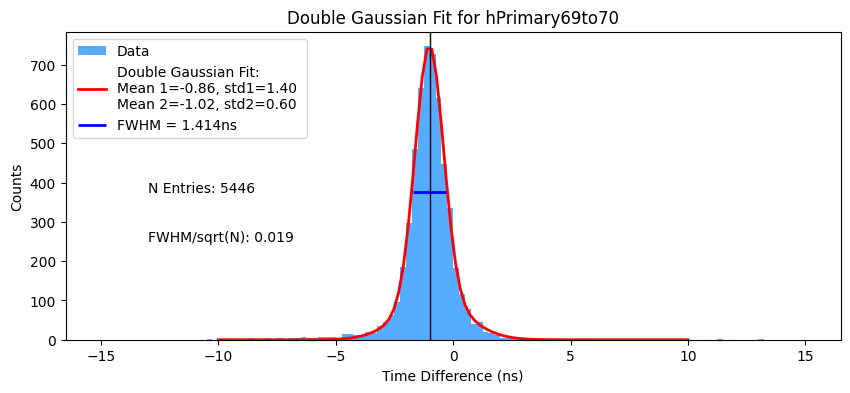

Combined Mean (mean1-2): -0.995
Uncertainty in Combined Mean: 0.015
Chi-Squared/DOF: 13.204
(A1, A2): (353.02171493110444, 979.8589388625631)
[-1.6382575625787805, 1.4760241700756886, 48.75, -0.6382575625787805, 1.4760241700756886, 24.375]
Peak of the double Gaussian occurs at x = -1.70 with height = 191.81


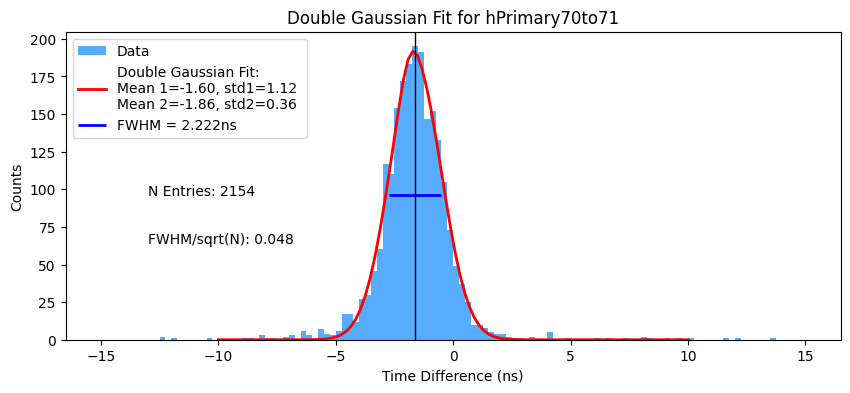

Combined Mean (mean1-2): -1.620
Uncertainty in Combined Mean: 0.029
Chi-Squared/DOF: 4.449
(A1, A2): (509.6480665528169, 10.488055769253554)
[0.7018753560906181, 1.464450065453927, 41.0, 1.7018753560906181, 1.464450065453927, 20.5]
Peak of the double Gaussian occurs at x = 0.14 with height = 160.51


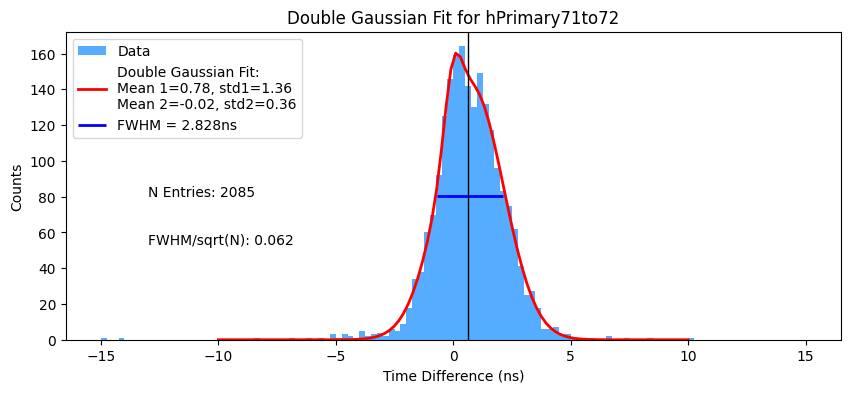

Combined Mean (mean1-2): 0.609
Uncertainty in Combined Mean: 0.030
Chi-Squared/DOF: 117.437
(A1, A2): (482.1564347293064, 33.877305528142905)
[0.49404564494130243, 1.457505023674138, 107.25, 1.4940456449413024, 1.457505023674138, 53.625]
Peak of the double Gaussian occurs at x = 1.19 with height = 420.23


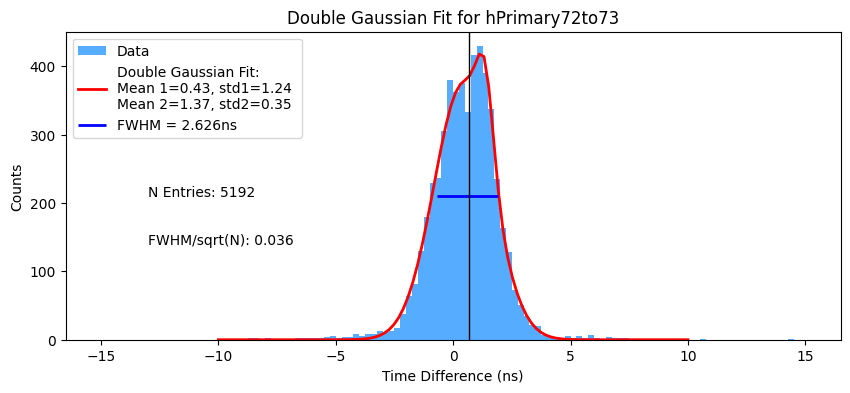

Combined Mean (mean1-2): 0.665
Uncertainty in Combined Mean: 0.018
Chi-Squared/DOF: 517.626
(A1, A2): (1165.018480903497, 110.38936878999651)
[0.5178048556555906, 1.1746517315394642, 232.0, 1.5178048556555908, 1.1746517315394642, 116.0]
Peak of the double Gaussian occurs at x = 0.62 with height = 923.82


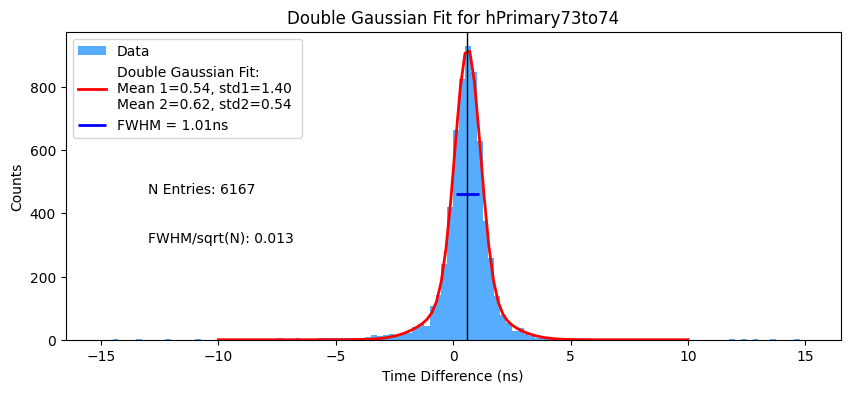

Combined Mean (mean1-2): 0.609
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 4.119
(A1, A2): (419.08167035751075, 1094.5656809548746)
[-0.02893790319513646, 1.1749769904172698, 174.75, 0.9710620968048636, 1.1749769904172698, 87.375]
Peak of the double Gaussian occurs at x = 0.11 with height = 696.44


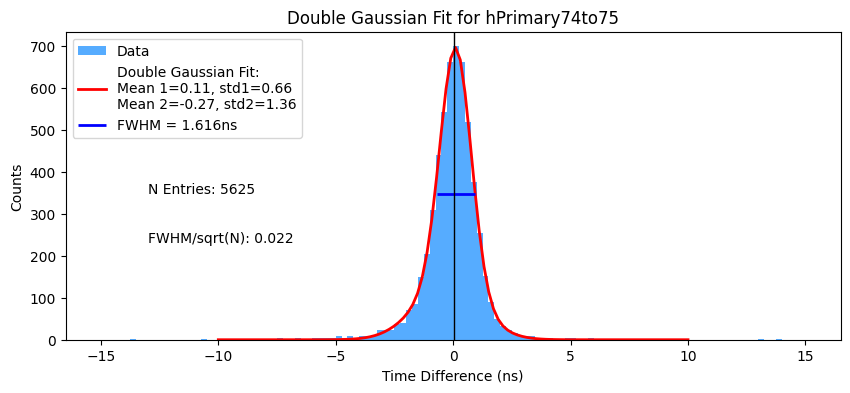

Combined Mean (mean1-2): 0.044
Uncertainty in Combined Mean: 0.015
Chi-Squared/DOF: 93.277
(A1, A2): (950.272458691502, 432.38402642683167)
[-0.40355471709780755, 1.2938574837903842, 150.25, 0.5964452829021925, 1.2938574837903842, 75.125]
Peak of the double Gaussian occurs at x = -0.20 with height = 575.54


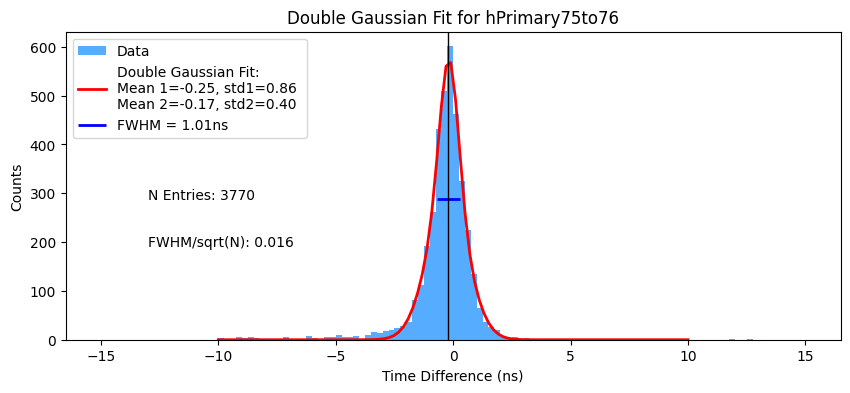

Combined Mean (mean1-2): -0.209
Uncertainty in Combined Mean: 0.017
Chi-Squared/DOF: 5.459
(A1, A2): (598.5470414003564, 300.2564758778584)
[-2.602359712239833, 2.8607060371016493, 1.25, -1.6023597122398332, 2.8607060371016493, 0.625]
Peak of the double Gaussian occurs at x = -2.60 with height = 1.24


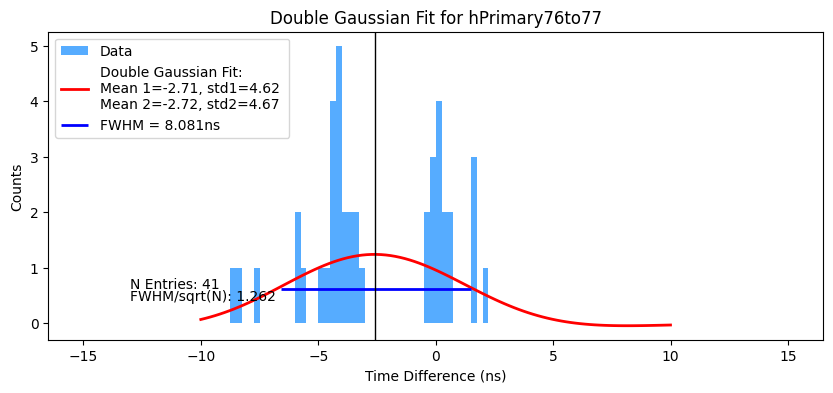

Combined Mean (mean1-2): -2.715
Uncertainty in Combined Mean: 0.043
Chi-Squared/DOF: 0.004
(A1, A2): (508.9620724953929, -499.01916768079116)
[0.4126416781600831, 2.3643524844088417, 0.5, 1.412641678160083, 2.3643524844088417, 0.25]
Peak of the double Gaussian occurs at x = -0.53 with height = 7.74


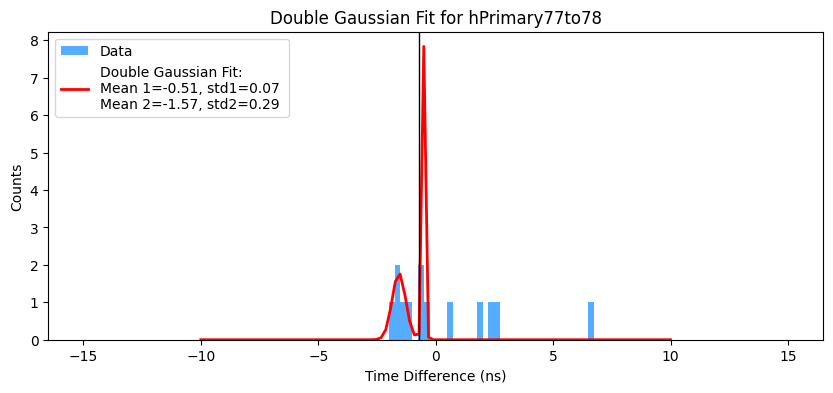

Combined Mean (mean1-2): -0.707
Uncertainty in Combined Mean: 0.128
Chi-Squared/DOF: 10.138
(A1, A2): (1.3381897594459768, 1.2818984215444589)
[-1.6651088794340307, 0.9335792467613431, 34.0, -0.6651088794340307, 0.9335792467613431, 17.0]
Peak of the double Gaussian occurs at x = -1.46 with height = 138.97


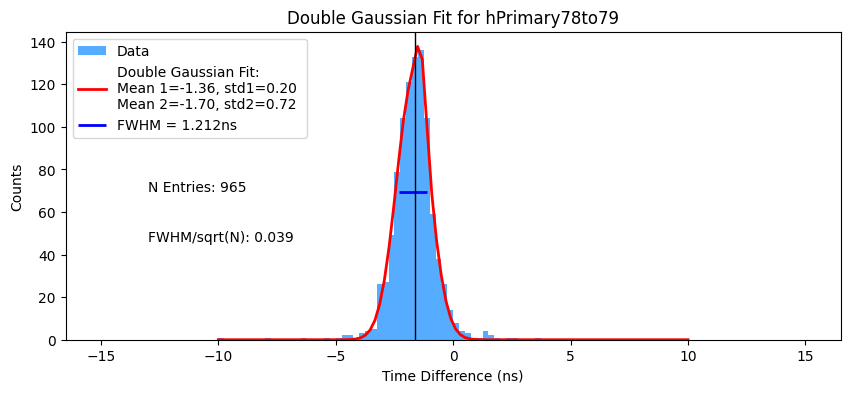

Combined Mean (mean1-2): -1.639
Uncertainty in Combined Mean: 0.033
Chi-Squared/DOF: 16.370
(A1, A2): (13.62284335124134, 219.06238278531842)
[1.8665300787219095, 0.9437484952018161, 18.5, 2.8665300787219095, 0.9437484952018161, 9.25]
Peak of the double Gaussian occurs at x = 2.51 with height = 179.94


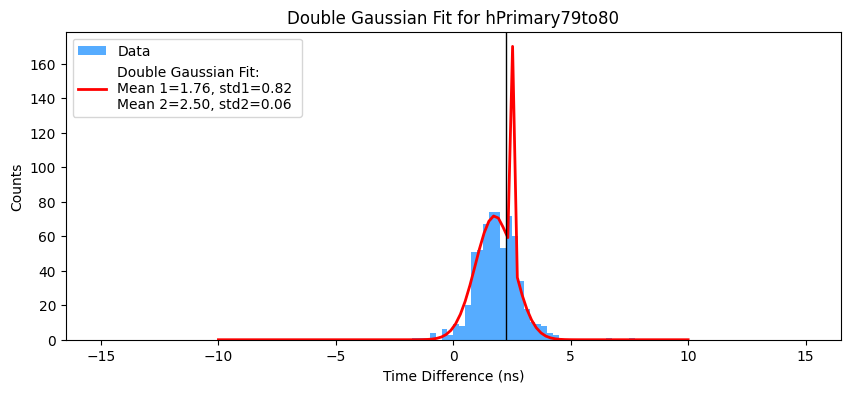

Combined Mean (mean1-2): 2.242
Uncertainty in Combined Mean: 0.028
Chi-Squared/DOF: 160.433
(A1, A2): (147.6691470031008, 20.923724098499896)
[-1.0674316352790483, 1.0668313884654415, 4.0, -0.06743163527904827, 1.0668313884654415, 2.0]
Peak of the double Gaussian occurs at x = -1.04 with height = 16.05


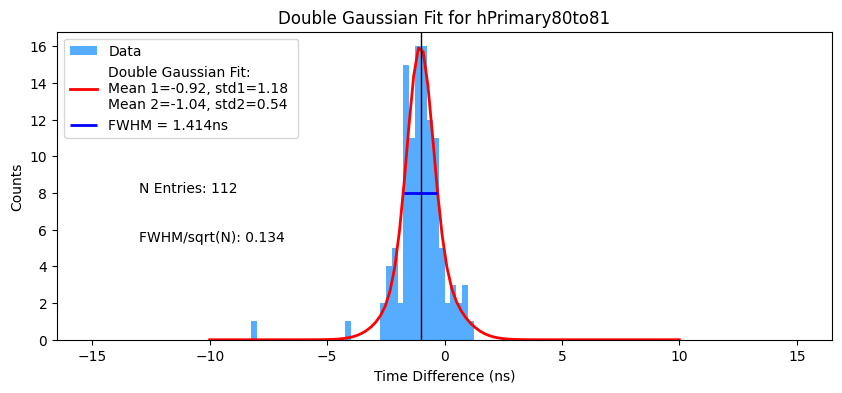

Combined Mean (mean1-2): -1.012
Uncertainty in Combined Mean: 0.100
Chi-Squared/DOF: 0.258
(A1, A2): (11.678832591355158, 16.268479723452923)
[0.26603058486559616, 1.3418156567580026, 2.0, 1.2660305848655962, 1.3418156567580026, 1.0]
Peak of the double Gaussian occurs at x = 0.05 with height = 6.45


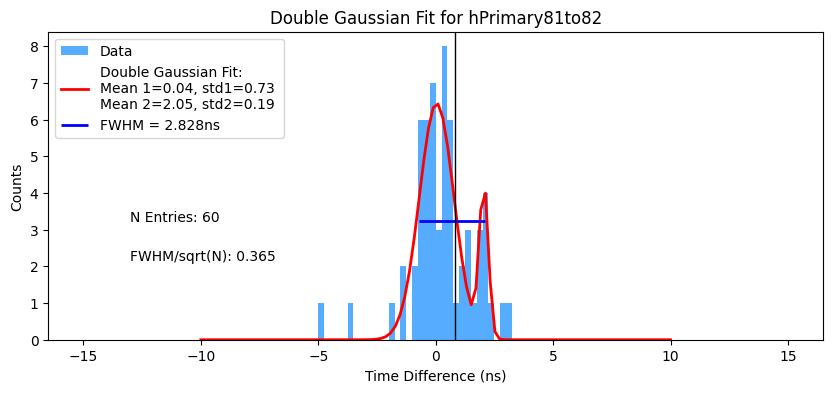

Combined Mean (mean1-2): 0.829
Uncertainty in Combined Mean: 0.123
Chi-Squared/DOF: 64.018
(A1, A2): (11.878870900104477, 2.0049356879145472)
[2.0992268799035037, 1.4590989099075773, 1.0, 3.0992268799035037, 1.4590989099075773, 0.5]
Peak of the double Gaussian occurs at x = 0.62 with height = 4.01


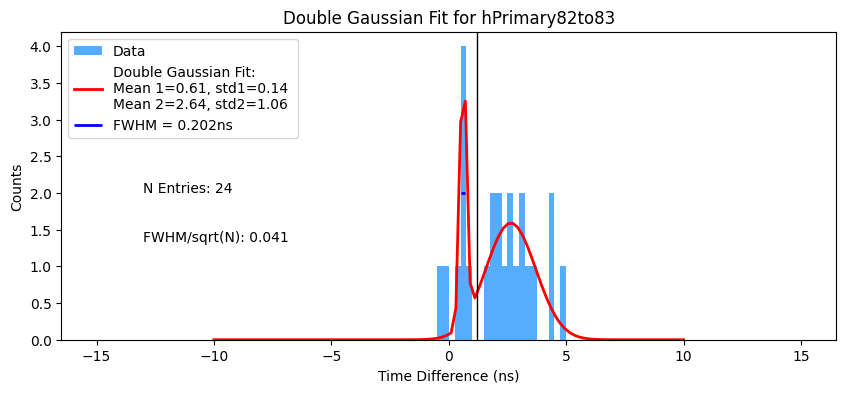

Combined Mean (mean1-2): 1.216
Uncertainty in Combined Mean: 0.173
Chi-Squared/DOF: 28.898
(A1, A2): (1.2856114991208867, 4.23880495502494)
[4.143403394, 5.537401180272003, 0.25, 5.143403394, 5.537401180272003, 0.125]
Peak of the double Gaussian occurs at x = 9.62 with height = 1.00


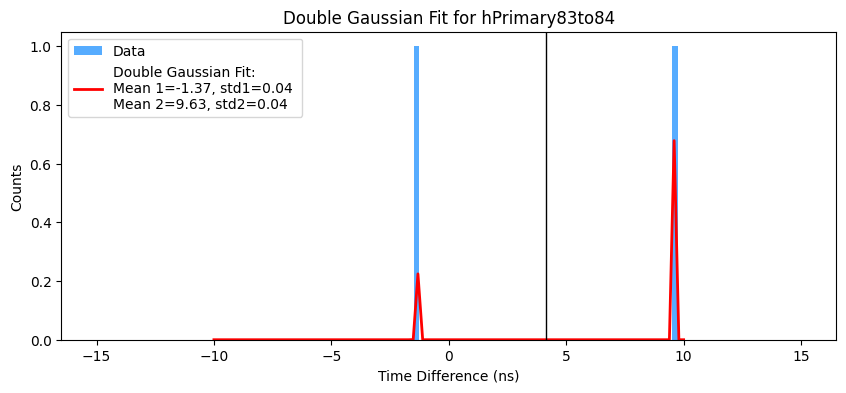

Combined Mean (mean1-2): 4.131
Uncertainty in Combined Mean: 0.282
Chi-Squared/DOF: 380.588
(A1, A2): (0.08969726658009958, 0.08840870827424005)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


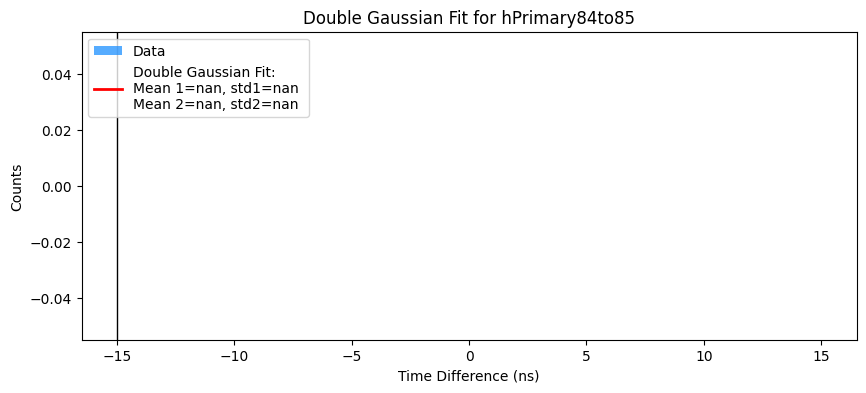

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


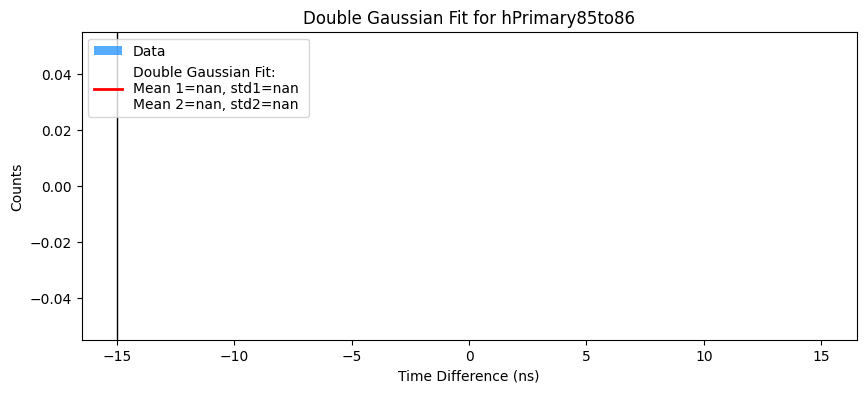

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


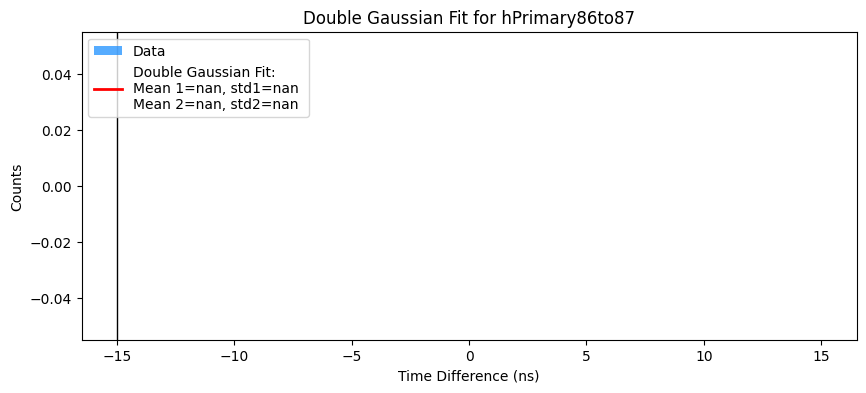

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


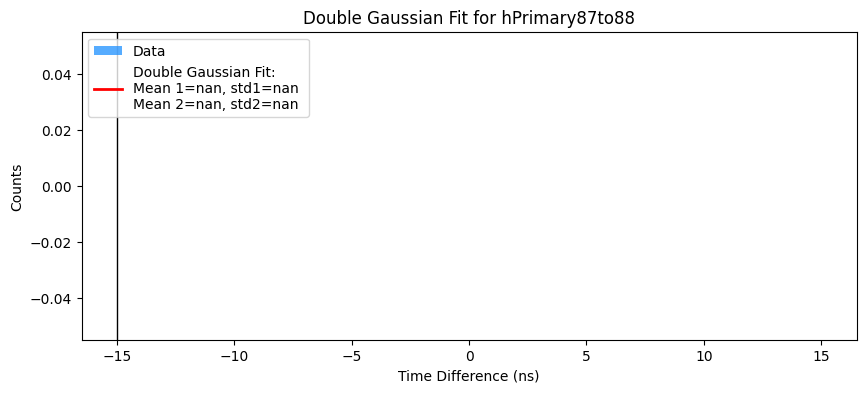

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
[nan, nan, 0.0, nan, nan, 0.0]
Peak of the double Gaussian occurs at x = -15.00 with height = nan


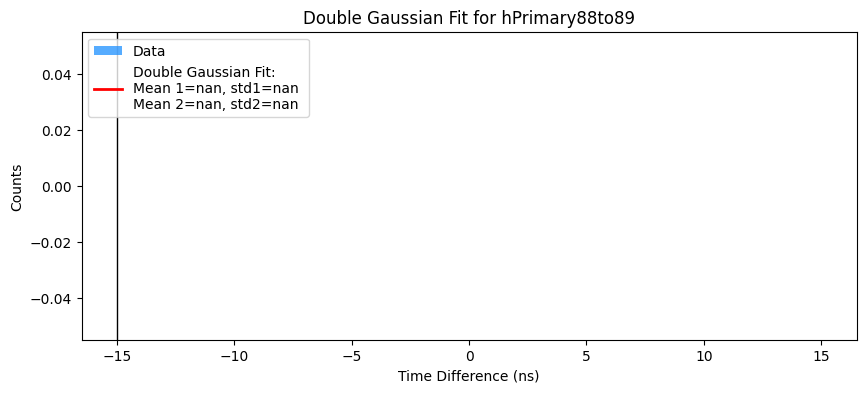

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)


In [45]:
peak=[]
for i in range(0,len(histogramPath)):
    peak.append(plot_histogram_with_double_gaussian(histograms, histogramPathPrimary[i]))
    

# Path Offset Calculation

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to plot a histogram and fit a Gaussian to it
def get_histogram_with_gaussian(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        
        # Filter the data to only include values in the range [-30, 30]
        data = datah[(datah >= -10) & (datah <= 10)]
        
       
        
        # Fit a Gaussian to the filtered data
        mu, std = norm.fit(data)
        
        # Generate the fitted Gaussian curve
        x = np.linspace(-10, 10, 100)
        p = norm.pdf(x, mu, std)
        
        # Plot the fitted Gaussian curve
        #plt.plot(x, p, 'k', linewidth=2, label=f'mean={mu:.2f}, std={std:.2f}')
        #plt.hist(datah, bins=60, alpha=0.75, range=(-30, 30), density=True, label='Data')
        # Add labels and title
        #plt.title(f"Histogram and Gaussian Fit for {hist_name}")
        #plt.xlabel('Time Difference (ns)')
        #plt.ylabel("Normalized")
        #plt.legend()
        
        # Show the plot
        return [mu,std,np.sqrt(len(data))]
    else:
        print(f"Histogram {hist_name} not found!")



def get_histogram_with_gaussian_secondary(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        
        # Filter the data to only include values in the range [-10, 10]
        data = datah[(datah >= -10) & (datah <= 10)]
        
        # First Gaussian fit to the filtered data
        mu, std = norm.fit(data)
        
        # Perform a secondary fit using data within one standard deviation of the first mean
        data_secondary = data[(data >= mu - std) & (data <= mu + std)]
        
        # Fit a Gaussian to the secondary filtered data
        mu_secondary, std_secondary = norm.fit(data_secondary)
        return [mu_secondary, std,np.sqrt(len(data))]
    else:
        print(f"Histogram {hist_name} not found!")
        return None

    
    
def get_histogram_with_double_gaussian(histograms, hist_name):
    try:
        if hist_name in histograms:
            datah = histograms[hist_name]
            #plt.figure(figsize=(10, 4))
            # Filter the data to only include values in the range [-10, 10]
            data = datah[(datah >= -10) & (datah <= 10)]
            nEntries=len(data)
            # Plot the histogram of the original data with counts on the y-axis
            counts, bins = np.histogram(data, bins=120, range=(-15, 15))
            bin_width = bins[1] - bins[0]        

            # Use bin centers for fitting
            bin_centers = (bins[:-1] + bins[1:]) / 2

            # Initial guesses for the parameters of the double Gaussian
            mu1_initial, sigma1_initial = norm.fit(data)
            mu2_initial, sigma2_initial = mu1_initial + 1, sigma1_initial
            A1_initial, A2_initial = max(counts) * bin_width, max(counts) * bin_width / 2  # Scale amplitudes to match the histogram

            initial_guess = [mu1_initial, sigma1_initial, A1_initial, mu2_initial, sigma2_initial, A2_initial]

            # Fit the double Gaussian to the data
            popt, _ = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
            mu1, sigma1, A1, mu2, sigma2, A2 = popt
            peak_x, peak_y = find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2)
            # Generate the fitted double Gaussian curve
            x = np.linspace(-10, 10, 100)
            p_double_gaussian = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
            left_fwhm, right_fwhm, fwhm_value,half_max = calculate_fwhm(x, p_double_gaussian, peak_y)

            if fwhm_value!=None:
                error=fwhm_value/np.sqrt(nEntries)
            else:
                error=100
           
        # Step 1: Calculate the number of events under each Gaussian
            N1 = abs(A1) * np.sqrt(2 * np.pi) * sigma1  # Number of events under Gaussian 1
            N2 = abs(A2) * np.sqrt(2 * np.pi) * sigma2  # Number of events under Gaussian 2

            # Step 2: Calculate the accuracy as standard error
            accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
            accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2

            # Step 3: Calculate the combined weighted mean (mean1-2)
            mean1_2 = (mu1 / accuracy1**2 + mu2 / accuracy2**2) / (1 / accuracy1**2 + 1 / accuracy2**2)

            # Step 4: Calculate the uncertainty in the combined mean
            sigma_mean1_2 = 1 / np.sqrt(1 / accuracy1**2 + 1 / accuracy2**2)

            # Step 5: Chi-squared calculation for the combined mean
            chi_squared = ((mu1 - mean1_2)**2 / accuracy1**2) + ((mu2 - mean1_2)**2 / accuracy2**2)
            if A1>0 and A2>0:
                return mean1_2,sigma_mean1_2
            else:
                return peak_x,error
            """return {
                'mu1': mu1,
                'sigma1': sigma1,
                'A1': A1,
                'mu2': mu2,
                'sigma2': sigma2,
                'A2': A2
            """
        else:
            print(f"Histogram {hist_name} not found!")
    except:
        print("Double Gaussian fit failed, trying single")
        mu_initial, sigma_initial = norm.fit(data)
        A_initial = max(counts) * bin_width
        initial_guess = [mu_initial, sigma_initial, A_initial]
        try:
            # Fit single Gaussian
            popt, _ = curve_fit(single_gaussian, bin_centers, counts, p0=initial_guess)
            mu, sigma, A = popt
            N1 = abs(A) * np.sqrt(2 * np.pi) * sigma
            accuracy1 = sigma / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
        

            print(f"Single Gaussian peak at mu = {mu:.2f} with std dev = {sigma:.2f} and amplitude = {A:.2f}")
            return mu,accuracy1
        except Exception as e:
            print(f"Single Gaussian fit also failed: {e}")

# Example usage:
# Example usage:
# primary_fit, secondary_fit = get_histogram_with_gaussian_secondary(histograms, 'h152to151')


In [84]:
meanPrimary=[]
errorPrimary=[]
barsPrimary=[]
for i in range(0,len(histogramPath)):
    barsPrimary.append(i)
    result=get_histogram_with_double_gaussian(histograms, histogramPathSecondary[i])
    meanPrimary.append(result[0])
    errorPrimary.append(result[1])

/tmp/ipykernel_6627/4251895545.py:101: RuntimeWarning: invalid value encountered in double_scalars
  accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
/tmp/ipykernel_6627/4251895545.py:102: RuntimeWarning: invalid value encountered in double_scalars
  accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2


In [85]:
meanSecondary=[]
errorSecondary=[]
barsSecondary=[]
for i in range(0,len(histogramPath)):
    barsSecondary.append(i)
    result=get_histogram_with_double_gaussian(histograms, histogramPathPrimary[i])
    meanSecondary.append(result[0])
    errorSecondary.append(result[1])

Double Gaussian fit failed, trying single
Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06


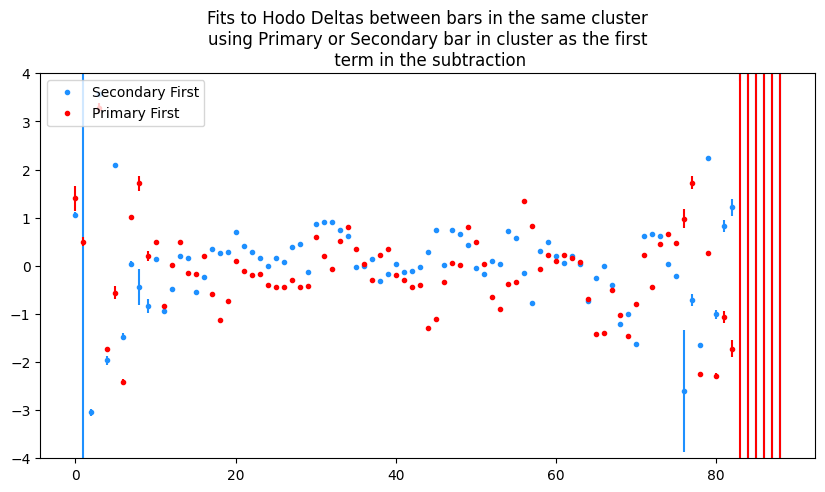

In [139]:
plt.figure(figsize=(10,5))
plt.errorbar(barsSecondary,meanSecondary,errorSecondary,linestyle="none",color='dodgerblue')
plt.errorbar(barsPrimary,meanPrimary,errorPrimary,linestyle="none",color='red')
plt.plot(barsSecondary,meanSecondary,'.',color='dodgerblue',label='Secondary First')
plt.plot(barsPrimary,meanPrimary,'.',color='red',label="Primary First")
#plt.plot(barsSecondary,np.array(meanSecondary)+np.array(meanPrimary))
plt.title("Fits to Hodo Deltas between bars in the same cluster\nusing Primary or Secondary bar in cluster as the first\n term in the subtraction")
plt.ylim(-4,4)
plt.legend(loc='upper left')

In [287]:
np.sum(mean)

-29.9777477570572

In [288]:
target_block

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88])

In [289]:
#old fits

"""master_block = 45
target_block = np.arange(0,89)
id_offset=[]
for i in target_block:
    mean=[]
    error=[]
    if i == master_block:
        continue
    
    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function
    print(path)
    #draw_grid_with_path(master_block, i, path)
    histogramPath= ['h' + p for p in path]
    for j in range(0,len(histogramPath)):
        result=get_histogram_with_gaussian_secondary(histograms, histogramPath[j])
        mean.append(result[0])
        error.append(0)
    npError=np.array(error)    
    offset=np.sum(mean)
    e=np.sqrt(np.sum(npError**2))
    id_offset.append([i,offset,e])"""

"master_block = 45\ntarget_block = np.arange(0,89)\nid_offset=[]\nfor i in target_block:\n    mean=[]\n    error=[]\n    if i == master_block:\n        continue\n    \n    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function\n    print(path)\n    #draw_grid_with_path(master_block, i, path)\n    histogramPath= ['h' + p for p in path]\n    for j in range(0,len(histogramPath)):\n        result=get_histogram_with_gaussian_secondary(histograms, histogramPath[j])\n        mean.append(result[0])\n        error.append(0)\n    npError=np.array(error)    \n    offset=np.sum(mean)\n    e=np.sqrt(np.sum(npError**2))\n    id_offset.append([i,offset,e])"

In [90]:
master_block = 45
target_block = np.arange(0, 89)
id_offsetPrimary = []

for i in target_block:
    mean = []
    error = []

    if i == master_block:
        continue

    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function
    print(path)
    # draw_grid_with_path(master_block, i, path)
    histogramPath = ['hPrimary' + p for p in path]

    for j in range(0, len(histogramPath)):
        try:
            # Try to get the result using the double Gaussian fit
            result = get_histogram_with_double_gaussian(histograms, histogramPath[j])
            if result is not None:
                mean.append(result[0])  # Append the result (peak_x) if the fit succeeds
                error.append(result[1])  # Placeholder error for now, change as needed
            else:
                mean.append(0)  # If no result (None), append 0 as placeholder
                error.append(100)  # Placeholder error, 0 for now
        except RuntimeError:
            # If the curve_fit function fails, append 0 as a placeholder for both mean and error
            print(f"Fit failed for {histogramPath[j]}, adding 0 as a placeholder.")
            mean.append(0)  # Append 0 for the failed fit
            error.append(100)  # Append 0 for the error

    # Convert error list to numpy array for calculations
    npError = np.array(error)

    # Calculate the offset and error using numpy functions
    offset = np.sum(mean)  # Sum of the means
    e = np.sqrt(np.sum(npError**2))  # Combined error (currently 0 but ready for real error)

    # Append the id, offset, and error to the result list
    id_offsetPrimary.append([i, offset, e])

# id_offset now contains the offsets and errors for all target blocks


['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1', '1to0']


/tmp/ipykernel_6627/4251895545.py:101: RuntimeWarning: invalid value encountered in double_scalars
  accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
/tmp/ipykernel_6627/4251895545.py:102: RuntimeWarning: invalid value encountered in double_scalars
  accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2


Double Gaussian fit failed, trying single
Single Gaussian peak at mu = -0.64 with std dev = 1.19 and amplitude = 46.71
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1']
Double Gaussian fit failed, trying single
Single Gaussian peak at mu = -0.64 with std dev = 1.19 and amplitude = 46.71
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11

['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39

Double Gaussian fit failed, trying single
Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72']
Double Gaussian fit failed, trying single
Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73']
Double Gaussian fit failed, trying single
Single Gaussian peak at mu = 0.75 with std dev = 1.28 and amplitude = 2790.06
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54

In [91]:
master_block = 45
target_block = np.arange(0, 89)
id_offsetSecondary = []

for i in target_block:
    mean = []
    error = []

    if i == master_block:
        continue

    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function
    print(path)
    # draw_grid_with_path(master_block, i, path)
    histogramPath = ['hSecondary' + p for p in path]

    for j in range(0, len(histogramPath)):
        try:
            # Try to get the result using the double Gaussian fit
            result = get_histogram_with_double_gaussian(histograms, histogramPath[j])
            if result is not None:
                mean.append(result[0])  # Append the result (peak_x) if the fit succeeds
                error.append(result[1])  # Placeholder error for now, change as needed
            else:
                mean.append(0)  # If no result (None), append 0 as placeholder
                error.append(100)  # Placeholder error, 0 for now
        except RuntimeError:
            # If the curve_fit function fails, append 0 as a placeholder for both mean and error
            print(f"Fit failed for {histogramPath[j]}, adding 0 as a placeholder.")
            mean.append(0)  # Append 0 for the failed fit
            error.append(100)  # Append 0 for the error

    # Convert error list to numpy array for calculations
    npError = np.array(error)

    # Calculate the offset and error using numpy functions
    offset = np.sum(mean)  # Sum of the means
    e = np.sqrt(np.sum(npError**2))  # Combined error (currently 0 but ready for real error)

    # Append the id, offset, and error to the result list
    id_offsetSecondary.append([i, offset, e])

# id_offset now contains the offsets and errors for all target blocks


['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1', '1to0']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31

['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31']
['45

['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81']
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82']
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72

In [98]:
#result=np.array(id_offset)
#result=np.transpose(result)
#plt.plot(result[0],result[1],'.',color='black')
#plt.errorbar(result[0],result[1],result[2],color='black',alpha=.3)

#plt.xlabel('Block ID')
#plt.ylabel('Block 150 time - Block I time (ns)')
#plt.title('Travel Calibration Offsets')
#plt.ylim(-6,6)

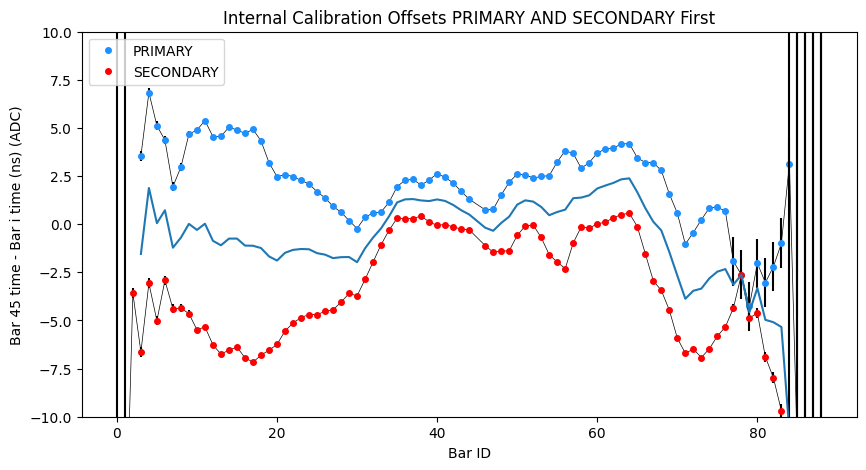

In [152]:
lw=1
plt.figure(figsize=(10,5))
resultPrimary=np.array(id_offsetPrimary)
resultPrimary=np.transpose(resultPrimary)
plt.errorbar(resultPrimary[0],resultPrimary[1],resultPrimary[2],ls='none',color='black',lw=lw*1.5)

plt.plot(resultPrimary[0],resultPrimary[1],color='black',lw=lw/2)
plt.plot(resultPrimary[0],resultPrimary[1],'.',color='dodgerblue',markersize=8,label="PRIMARY")

resultSecondary=np.array(id_offsetSecondary)
resultSecondary=np.transpose(resultSecondary)
plt.errorbar(resultSecondary[0],resultSecondary[1],resultSecondary[2],ls='none',color='black',lw=lw*1.5)


plt.plot(resultSecondary[0],resultSecondary[1],color='black',lw=lw/2)
plt.plot(resultSecondary[0],resultSecondary[1],'.',color='red',markersize=8,label="SECONDARY")
plt.plot(resultSecondary[0],(resultSecondary[1]+resultPrimary[1])/2)

#plt.plot(resultSecondary[0],resultSecondary[1]+resultPrimary[1])
plt.xlabel('Bar ID')
plt.ylabel('Bar 45 time - Bar i time (ns) (ADC)')
plt.title('Internal Calibration Offsets PRIMARY AND SECONDARY First')
plt.ylim(-10,10)
plt.legend(loc='upper left')

In [153]:
first_array=resultPrimary[0]
second_array=resultPrimary[1]

insert_index = np.searchsorted(first_array, 45)

first_array = np.insert(first_array, insert_index, 45)

second_array = np.insert(second_array, insert_index, 0)
new_offset=np.nan_to_num(second_array, nan=0)
np.save("TDCOffsetHodoPrimary.npy",new_offset)
first_array=resultSecondary[0]
second_array=resultSecondary[1]

insert_index = np.searchsorted(first_array, 45)

first_array = np.insert(first_array, insert_index, 45)

second_array = np.insert(second_array, insert_index, 0)
new_offset=np.nan_to_num(second_array, nan=0)
np.save("TDCOffsetHodoSecondary.npy",new_offset)



first_array=resultSecondary[0]
second_array=(resultSecondary[1]+resultPrimary[1])/2

insert_index = np.searchsorted(first_array, 45)

first_array = np.insert(first_array, insert_index, 45)

second_array = np.insert(second_array, insert_index, 0)
new_offset=np.nan_to_num(second_array, nan=0)
np.save("TDCOffsetHodoAveraged.npy",new_offset)



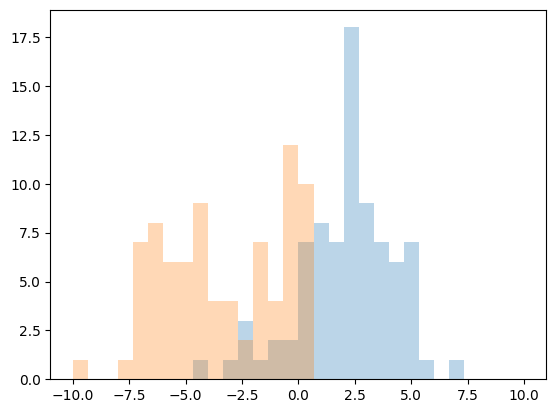

In [150]:
p=plt.hist(resultPrimary[1],range=(-10,10),bins=30,alpha=.3)
p=plt.hist(resultSecondary[1],range=(-10,10),bins=30,alpha=.3)

(-11.0, 10.0)

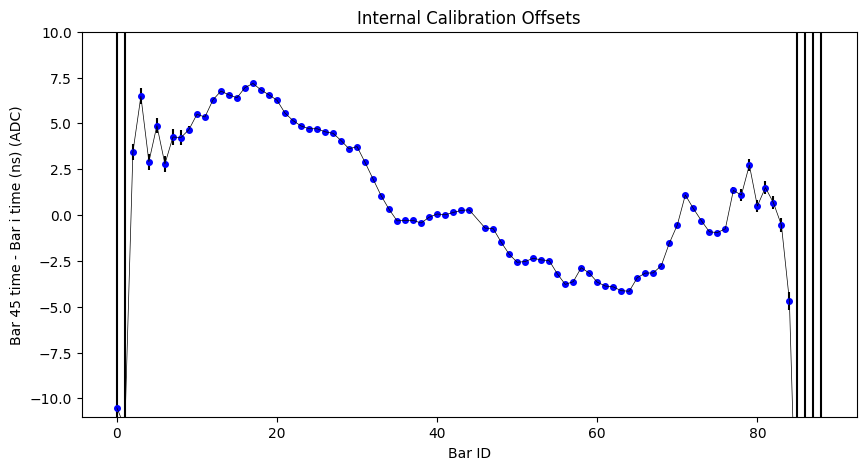

In [101]:
lw=1
plt.figure(figsize=(10,5))
result=np.array(id_offset)
result=np.transpose(result)
plt.errorbar(result[0],result[1],result[2],ls='none',color='black',lw=lw*1.5)

plt.plot(result[0],result[1],'.',color='blue',markersize=8)
plt.plot(result[0],result[1],color='black',lw=lw/2)

plt.xlabel('Bar ID')
plt.ylabel('Bar 45 time - Bar i time (ns) (ADC)')
plt.title('Internal Calibration Offsets')
plt.ylim(-11,10)

(-11.0, 3.0)

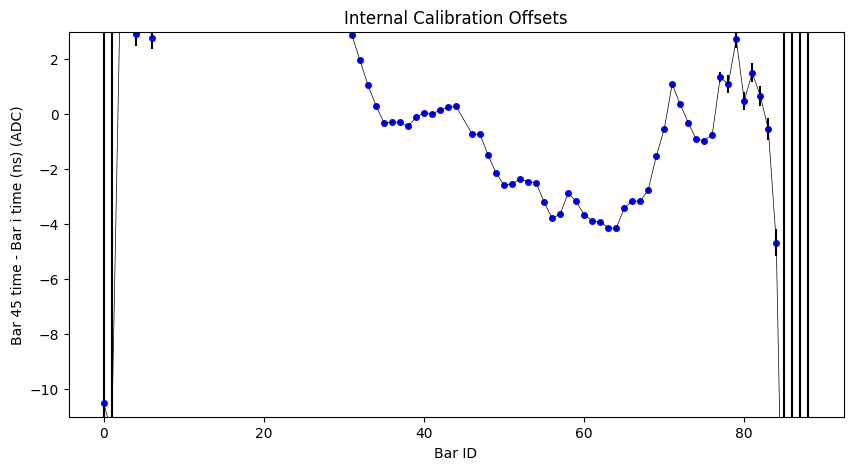

In [97]:
lw=1
plt.figure(figsize=(10,5))
result=np.array(id_offset)
result=np.transpose(result)
plt.errorbar(result[0],result[1],result[2],ls='none',color='black',lw=lw*1.5)

plt.plot(result[0],result[1],'.',color='blue',markersize=8)
plt.plot(result[0],result[1],color='black',lw=lw/2)

plt.xlabel('Bar ID')
plt.ylabel('Bar 45 time - Bar i time (ns) (ADC)')
plt.title('Internal Calibration Offsets')
plt.ylim(-11,3)

In [296]:
first_array=result[0]
second_array=result[1]

insert_index = np.searchsorted(first_array, 45)

first_array = np.insert(first_array, insert_index, 45)

second_array = np.insert(second_array, insert_index, 0)
new_offset=np.nan_to_num(second_array, nan=0)
np.save("TDCOffsetHodoPrimary.npy",new_offset)


np.round(new_offset,4)

array([ 6.88400e-01,  1.67730e+00,  1.67730e+00, -1.37360e+00,
        2.17140e+00,  4.23600e-01,  1.14570e+00, -1.03010e+00,
       -1.20200e-01, -3.34300e-01, -3.60300e-01, -1.08200e-01,
       -9.71400e-01, -1.21980e+00, -8.66400e-01, -8.72800e-01,
       -1.19270e+00, -1.29370e+00, -1.52090e+00, -1.74290e+00,
       -1.87240e+00, -1.55620e+00, -1.33650e+00, -1.25670e+00,
       -1.27980e+00, -1.46010e+00, -1.53060e+00, -1.66810e+00,
       -1.67740e+00, -1.66950e+00, -1.81600e+00, -1.17350e+00,
       -6.48100e-01, -2.77800e-01,  3.48600e-01,  1.04520e+00,
        1.24040e+00,  1.25830e+00,  1.16800e+00,  1.01390e+00,
        1.26370e+00,  1.22990e+00,  1.03300e+00,  7.63300e-01,
        5.40400e-01,  0.00000e+00, -3.41300e-01, -4.50900e-01,
       -2.26600e-01,  1.98100e-01,  7.93400e-01,  1.05840e+00,
        1.02430e+00,  7.91200e-01,  2.97000e-01,  3.13200e-01,
        5.06400e-01,  1.12750e+00,  1.35180e+00,  1.53350e+00,
        1.86490e+00,  2.03850e+00,  2.15760e+00,  2.349

(array([ 0.,  0.,  3.,  5.,  7., 20., 22., 25.,  5.,  0.]),
 array([-10. ,  -8.5,  -7. ,  -5.5,  -4. ,  -2.5,  -1. ,   0.5,   2. ,
          3.5,   5. ]),
 <BarContainer object of 10 artists>)

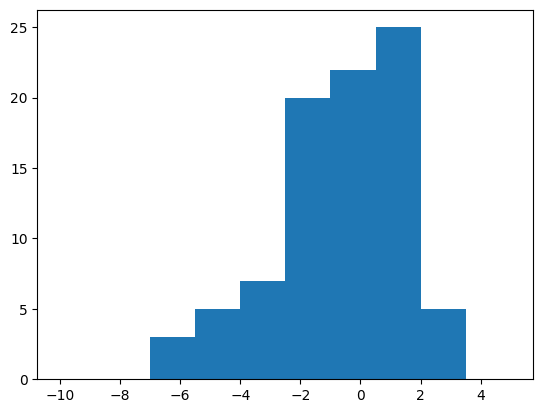

In [298]:
plt.hist(new_offset,range=(-10,5))

In [231]:


def Load_HodoNew(config):
    rootfile = f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
    #rootfile = f"../outfiles/oldhcal.root"
    rootfile2=f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_p_model1.root"
    C = r.TChain("Tout")
    C.Add(rootfile)
    C.SetBranchStatus("*", 0)
   
    
    #HCAL VARS_____________________________________
    #HCAL VARS_____________________________________
    C.SetBranchStatus("cx", 1)
    C.SetBranchStatus("cy", 1)
    C.SetBranchStatus("cblktime",1)
    C.SetBranchStatus("cblkatime",1)
    C.SetBranchStatus("cblkid",1)
    C.SetBranchStatus("cblke",1)
    C.SetBranchStatus("tdc",1)
    C.SetBranchStatus("atime",1)
    C.SetBranchStatus("bbcal_time",1)
    C.SetBranchStatus("pblkid",1)
    C.SetBranchStatus("nclus",1)
    C.SetBranchStatus("nblk",1)
    #C.SetBranchStatus("hodoTOT",1)
    
    bbtime=array.array('d',[0])
    tdc=array.array('d',[0])
    atime=array.array('d',[0])
    pblkid=array.array('d',[0])
    cx = array.array('d', [0]*10) 
    cy = array.array('d', [0]*10) 
    cblktime=array.array('d',[0]*25)
    cblkatime=array.array('d',[0]*25)
    cblkid=array.array('d',[0]*25)
    cblke=array.array('d',[0]*25)
    nclus=array.array('d',[0])
    nblk=array.array('i',[0])
    #hodoTOT=array.array('d',[0]*6)
    
    
    C.SetBranchAddress("cx", cx)
    C.SetBranchAddress("cy", cy)
    C.SetBranchAddress("cblktime",cblktime)
    C.SetBranchAddress("cblkatime",cblkatime)
    C.SetBranchAddress("cblkid",cblkid)
    C.SetBranchAddress("cblke",cblke)
    C.SetBranchAddress("tdc",tdc)
    C.SetBranchAddress("atime",atime)
    C.SetBranchAddress("pblkid",pblkid)
    C.SetBranchAddress("bbcal_time",bbtime)
    C.SetBranchAddress("nclus",nclus)
    C.SetBranchAddress("nblk",nblk)

    #_____________________________________
    
    
    #CUT VARS_____________________________________
    C.SetBranchStatus("W2",1)
    C.SetBranchStatus("dx",1)
    C.SetBranchStatus("dy",1)
    
    W2=array.array('d',[0])
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    
    C.SetBranchAddress("W2",W2)
    C.SetBranchAddress("dx",dx)
    C.SetBranchAddress("dy",dy)
    
    #_____________________________________
    
    cx_array=[]
    cy_array=[]
    cblktime_array=[]
    cblkatime_array=[]
    cblkid_array=[]
    cblke_array=[]
    tdc_array=[]
    bbtime_array=[]
    atime_array=[]
    pblkid_array=[]
    target=[]
    weighted_time=[]
    
    C.GetEntry(0)
    Entries=C.GetEntries()
    passedcut=0
    for i in range(0,Entries):
        
        C.GetEntry(i)
           
        #cut----------------
        wcut=W2min<W2[0]<W2max
        dxcut=dxmin<dx[0]<dxmax
        dycut=dymin<dy[0]<dymax
        cut=wcut and dxcut and dycut
        cut = wcut and dycut
        #-------------------
        
        if cut:
            try:
                
                # Amplitude weighted time
                
                        #adjust offsets of blocks affected
                for i in range(0,len(cblkid[:nblk[0]])):
                    cblktime[i]=cblktime[i]-old_offset[int(cblkid[i])-1]+final_offset[int(cblkid[i])-1]
                
                #print(cblke[:nblk[0]])
                
                npENERGY=np.array(cblke[:nblk[0]])
                npTIME=np.array(cblktime[:nblk[0]])
                weighted_time.append(np.sum(npENERGY*npTIME)/np.sum(npENERGY))
           
                
                
                
                
                
                
                # Amplitude weighted time
                
                
                tdc_array.append(tdc[0]-old_offset[int(pblkid[0]-1)]+final_offset[int(pblkid[0]-1)])
                
                #atime_array.append(atime[0]-old_offsetADC[int(pblkid[0]-1)]+final_offsetADC[int(pblkid[0]-1)])
                bbtime_array.append(bbtime[0])
                passedcut+=1
                cx_array.append(cx)
                cy_array.append(cy)
                
                pblkid_array.append(pblkid[0])
                cblktime_array.append(cblktime)
                cblkatime_array.append(cblkatime)

                cblkid_array.append(cblkid)
                cblke_array.append(cblke)
                target.append(0)
            except:
                print("Error with event")
    
    
    
    
    
   
    HCalArrays=[cx_array,cy_array,cblktime_array,cblkid_array,cblke_array,tdc_array,pblkid_array,cblkatime_array
                ,"atime_array",target,bbtime_array,weighted_time]
    return HCalArrays

# To run the function
